# XGBClassifier validation

This notebook shows different validation strategies used to analyze the performances of the XGBoost Classifier used to classify jumps in a target issuer using other issuers as predictors.

CV is implemented, either using a Stratified Split or a Time Series Split.

In addition, a procedure of HP tuning using Optuna is implemented.

In [1]:
import pandas as pd
import numpy as np
import os
from pgmpy.estimators import HillClimbSearch, BicScore, MaximumLikelihoodEstimator, TreeSearch, MmhcEstimator
import networkx as nx
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches
import time
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
from scipy.optimize import minimize_scalar
from statsmodels.distributions.empirical_distribution import ECDF
from pgmpy.models import BayesianNetwork
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

import time
from collections import Counter
from joblib import Parallel, delayed
from pgmpy.inference import VariableElimination
import sys
sys.path.append('../Modules')
from utils_bayesian_networks import *

In [2]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, KFold
from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
import warnings
warnings.filterwarnings('ignore')

/anaconda/envs/work_env/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Specify sector, min date and max date
sector = 'Real Estate'
min_date = '2016-11-29'
max_date = '2020-03-31'

compute_partial_correlation = False

In [4]:
df_all, df_all_lookup, _, _, _ =\
    import_data_clustering_issuer_rf(issuer_curves_file_name='../Data/Basedati3_spread.csv',
                                    fx_rf_file_name='../Data/Observations - UniverseFX.csv',
                                    local_rf_file_name='../Data/Observations - UniverseLOCAL.csv',sep_issuer_curves_file=';')
df_all['CurveID_Short'] = df_all['CurveID'].apply(lambda x  : str(x).split('-')[0] + '_' + str(x).split('-')[1])

dict_mapping_names = df_all[['CurveID_Short', 'Name']].drop_duplicates().set_index('CurveID_Short').to_dict()['Name']

df_spread = remove_series_mostly_na(df_all_lookup, 0.75)

# Select only curves from a specified sector
curves_sector = df_all[['CurveID', 'MS_Sector']].loc[lambda x: x['CurveID'].isin(list(df_spread.columns))].\
    drop_duplicates().\
    loc[lambda x: x['MS_Sector'] == sector]['CurveID'].unique()
print('Number of curves in sector ' + sector + ': ' + str(len(curves_sector)))

df_sector_spread = df_spread.loc[:,curves_sector]
df_sector_spread.index = pd.to_datetime(df_spread.index)
df_sector_spread.columns = [i.split('-')[0] + '_' + i.split('-')[1] for i in list(df_sector_spread.columns)]
df_sector_spread.shape

Maximum Timestamp of available data point 2016-11-30 00:00:00
Minimum Timestamp of not null data point cross time series 2022-02-04 00:00:00
Number of curves in sector Real Estate: 34


(1353, 34)

In [5]:
# Define discrete status for the specified sector in the 3 periods and on the whole time horizon
define_discrete_states_based_on_volatility_jumps(df_sector_spread, roll_window = 3, final_dates=['2020-03-31'],
                                                 output_path='../Data/discrete_status_bn/', type_name=sector)

Min date: 2016-11-29
Max date: 2020-03-31


Min date: 2020-03-31
Max date: 2022-02-04




In [6]:
# Read discrete data for the specified status (period)

input_data = pd.read_csv('../Data/discrete_status_bn/discrete_data_' + sector + '_' +
                         min_date + '_' + max_date + '.csv', sep=',')

for i in input_data:
    input_data[i] = input_data[i].astype('category')

input_data

ADLERR_100334 AMB_PROPERTY_119304 DWNIGY_111980 FLYFP_11184 IGDIM_51449  \
0             1.0                 0.5           1.0         1.0         1.0   
1             0.0                 0.5           0.0         0.0         0.0   
2             0.0                 0.5           0.0         0.0         0.0   
3             0.0                 1.0           0.0         0.0         0.0   
4             0.0                 0.0           0.0         0.0         0.0   
..            ...                 ...           ...         ...         ...   
861           0.0                 0.5           0.0         0.5         0.0   
862           0.0                 1.0           0.0         1.0         0.0   
863           0.0                 0.0           0.0         0.0         0.0   
864           0.0                 0.0           0.0         1.0         0.0   
865           0.0                 0.0           0.0         0.0         0.0   

    IRM_5892 KIM_15352 LIFP_7145 MERYFP_125403 PSPNSW_9487  ... FDRFP_65964  \
0        0.0       0.5       0.0           0.0         0.0  ...         0.5   
1        0.0       0.5       0.0           0.0         0.0  ...         0.5   
2        0.0       0.5       0.0           0.0         0.0  ...         1.0   
3        0.0       1.0       0.0           0.0         0.0  ...         0.0   
4        0.0       0.0       0.0           0.0         0.0  ...         0.0   
..       ...       ...       ...           ...         ...  ...         ...   
861      0.0       0.0       0.0           0.0         0.0  ...         0.0   
862      0.0       0.0       0.0           0.5         0.0  ...         0.0   
863      0.0       0.0       0.0           0.0         0.0  ...         0.0   
864      0.0       0.0       0.0           0.5         0.0  ...         0.0   
865      0.0       0.0       0.0           1.0         0.0  ...         0.0   

    FLYFP_4066 GFCFP_17375 GYCGR_2649294 ICADFP_124606 KWELN_3275897  \
0          0.0         1.0           0.5           0.0           0.5   
1          0.0         0.0           0.5           0.0           0.5   
2          0.0         0.0           0.5           0.0           1.0   
3          0.0         0.0           1.0           0.0           0.5   
4          0.0         0.0           0.0           0.0           0.0   
..         ...         ...           ...           ...           ...   
861        0.0         0.0           0.0           0.0           0.0   
862        0.0         0.0           0.5           0.0           0.0   
863        0.0         0.0           0.0           0.0           0.0   
864        0.0         0.0           0.5           0.0           0.0   
865        0.0         0.0           1.0           0.0           0.0   

    MRLSM_3418414 SOMI_116850 UNIROD_12827 WPC_45167  
0             0.0         0.0          1.0       0.0  
1             0.0         0.0          0.0       0.0  
2             0.0         0.0          0.0       0.0  
3             0.0         0.0          0.0       0.0  
4             0.0         0.0          0.0       0.0  
..            ...         ...          ...       ...  
861           0.5         0.5          0.0       0.0  
862           0.5         0.5          0.0       0.5  
863           0.0         0.0          0.0       0.0  
864           1.0         1.0          0.0       0.5  
865           0.0         0.0          0.0       1.0  

[866 rows x 34 columns]

In [7]:
input_data_test = pd.read_csv("../Data/discrete_status_bn/discrete_data_Real Estate_2020-03-31_2022-02-04.csv",sep=',')

In [10]:
# Use this cell if you want to read a model saved in previous executions

from pgmpy.readwrite import BIFReader
reader = BIFReader("../Output/5.1._BN_Results/results_pgmpy_plus_tigramite_2000_simulations_BKP_MODELS/" + sector + 
                   "_" + min_date + '_' + max_date + "_model.bif")
model_bn = reader.get_model()
model_graph = nx.Graph()
model_graph.add_nodes_from(list(input_data.columns))
model_graph = model_graph.to_directed()
model_graph.add_edges_from(list(model_bn.edges()))
pos = graphviz_layout(model_graph, prog="dot")

new_arcs = pd.DataFrame(columns=[0,1])
list_edges = list(model_bn.edges())
for i in range(len(list_edges)):
    source = list_edges[i][0]
    sink = list_edges[i][1]
    new_arcs = pd.concat([new_arcs, pd.DataFrame([source, sink]).T], ignore_index=True)
    
significant_arcs = new_arcs.copy()
significant_arcs.columns = ['from', 'to']

# Inference to determine link strength
model_infer = VariableElimination(model_bn)

link_strength = {}
for edge in model_bn.edges():
    q = model_infer.query(variables=[edge[1]], evidence={edge[0]: '1.0'}, show_progress=False)
    link_strength[edge] = q.values[2]
    

# Validation strategies for classification model to identify jumps in target node

In [11]:
model_graph_final = model_graph.copy()

In [12]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from xgboost import XGBClassifier, plot_importance

from sklearn.model_selection import cross_validate, StratifiedShuffleSplit
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

import warnings
warnings.filterwarnings('ignore')

In [13]:
# Build df for classification

class_input = input_data.copy()
class_input.columns = [i for i in class_input.columns]

for i in class_input:
    class_input[i] = class_input[i].astype('str')
    class_input[i] = np.where(class_input[i] != '0.0', 1, 0)

In [14]:
# Build df for classification

class_input_test = input_data_test.copy()
class_input_test.columns = [i for i in class_input_test.columns]

for i in class_input_test:
    class_input_test[i] = class_input_test[i].astype('str')
    class_input_test[i] = np.where(class_input_test[i] != '0.0', 1, 0)

In [15]:
target_list_nodes =['KWELN_3275897','UNIROD_12827','FLYFP_4066']

# STRATEGY 1: Stratified K-fold Experiment

## 1.1: Stratified k-fold CV on local and complete model with recursive feature elimination on local model

{'FLYFP_11184', 'MRLSM_3418414', 'UNIROD_12827', 'ICADFP_124606'}
Target:
KWELN_3275897
Local regressors:
DAIGAG_3061106,GFCFP_17375,DLR_3909442,ICADFP_124606,LIFP_7145,DWNIGY_111980,WRTAU_2967093,DLR_155273,EQIX_3767,FLYFP_11184,MRLSM_3418414,ADLERR_100334,ATRSAV_22701,ALATPF_3576896,GYCGR_2649294,MERYFP_125403,PSPNSW_9487,AMB_PROPERTY_119304,AOXGR_85498,FLYFP_4066,IGDIM_51449,FDRFP_65964,VTR_24720,SOMI_116850,KIM_15352,IRM_5892,SPG_120218,AMT_456,UNIROD_12827,AKFAST_1191331


0.7727615820275789
[07:35:41] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:41] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_16595489

[07:35:42] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:42] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:42] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:46] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:46] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:46] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:47] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:47] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:47] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:48] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:48] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:48] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:49] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:49] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:49] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:50] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:50] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:50] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:51] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:51] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:51] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:52] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:52] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:52] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:53] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:53] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:53] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:54] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:54] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:54] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:55] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:55] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:55] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:56] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:57] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:58] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:58] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:58] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:35:59] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:35:59] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:35:59] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:00] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:00] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:00] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:01] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:02] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:03] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

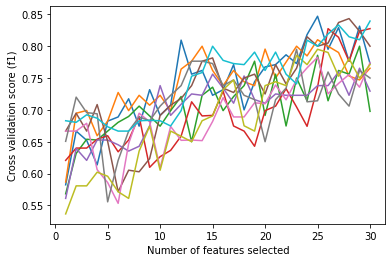

{'MRLSM_3418414'}
Target:
UNIROD_12827
Local regressors:
DAIGAG_3061106,GFCFP_17375,DLR_3909442,ICADFP_124606,LIFP_7145,DWNIGY_111980,WRTAU_2967093,DLR_155273,EQIX_3767,FLYFP_11184,MRLSM_3418414,ADLERR_100334,KWELN_3275897,ATRSAV_22701,ALATPF_3576896,GYCGR_2649294,MERYFP_125403,PSPNSW_9487,AMB_PROPERTY_119304,AOXGR_85498,FLYFP_4066,IGDIM_51449,FDRFP_65964,VTR_24720,SOMI_116850,KIM_15352,IRM_5892,SPG_120218,AMT_456,AKFAST_1191331


0.8572859829167404
[07:36:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:06] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBo

[07:36:07] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:07] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:07] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:08] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:09] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set e

[07:36:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:10] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set e

[07:36:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:11] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:12] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:13] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:13] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:13] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:14] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:14] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:14] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:14] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:14] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:14] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:15] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:15] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:15] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:16] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:16] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:16] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:17] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:17] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:17] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:18] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:18] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:18] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:19] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:19] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:19] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:20] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:20] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:20] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:21] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:21] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:21] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:22] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:22] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:22] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:23] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:23] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:23] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:24] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:24] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:24] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:24] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:24] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:25] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:27] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:27] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:27] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

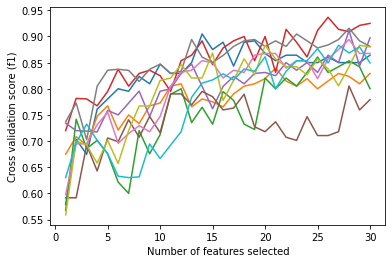

{'MRLSM_3418414', 'UNIROD_12827'}
Target:
FLYFP_4066
Local regressors:
DAIGAG_3061106,GFCFP_17375,DLR_3909442,ICADFP_124606,LIFP_7145,DWNIGY_111980,WRTAU_2967093,DLR_155273,EQIX_3767,FLYFP_11184,MRLSM_3418414,ADLERR_100334,KWELN_3275897,ATRSAV_22701,ALATPF_3576896,GYCGR_2649294,MERYFP_125403,PSPNSW_9487,AMB_PROPERTY_119304,AOXGR_85498,IGDIM_51449,FDRFP_65964,VTR_24720,SOMI_116850,KIM_15352,IRM_5892,SPG_120218,AMT_456,UNIROD_12827,AKFAST_1191331


0.8224769036708908
[07:36:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:29] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: 

[07:36:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:30] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:31] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:32] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:33] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:33] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:33] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:33] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:34] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:34] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:34] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:35] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:35] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:35] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:36] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:36] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:36] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:37] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:37] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:37] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:38] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:38] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:38] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:39] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:39] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:39] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:40] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:40] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:40] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:41] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:41] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:41] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:42] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:42] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:42] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:43] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:44] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:45] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:46] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:46] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:46] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:47] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:48] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:48] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:48] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:48] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:48] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:49] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

[07:36:50] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[07:36:50] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[07:36:50] WARNING: /tmp/abs_40obctay9q/croots/recipe/xgboost-split_1659548945886/work/src/learner.cc:576: 
Parameters: { "scoring" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mista

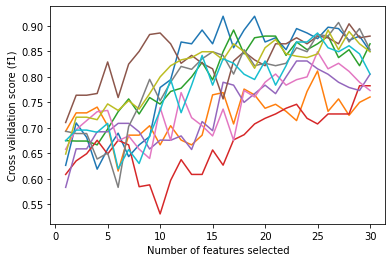

In [15]:

res_f1_gap = {}
res_recall_gap = {}
res_precision_gap = {}
avg_f1_local = {}
avg_f1_complete = {}
avg_recall_local = {}
avg_recall_complete = {}
avg_precision_local = {}
avg_precision_complete = {}


res_f1_local = {}
res_loss_local = {}
res_f1_complete = {}
res_loss_complete = {}

# Number of folds in cross validation
cv_fold_num = 10

# # Train-test split
# # Test observations are taken from the tail of the df (so they are the most recent observations)
# test_size_perc = 0.1
# df_train = class_input.head(int(np.floor((1-test_size_perc)*len(class_input))))
# df_test = class_input.tail(int(np.ceil(test_size_perc*len(class_input))))


for target in target_list_nodes:
    # Define issuer for which you want to classify jumps
    # Based on this, find list of issuers in the same connected component of the graph
    target_connected_component = [i for i in list(nx.node_connected_component(model_graph_final.to_undirected(), target)) if i != target]

    # Find all first level nodes (nodes with outgoing arcs and without incoming arcs) in the connected component
    # of the target node
    first_level_nodes_conn_comp = [i for i in target_connected_component if model_graph_final.out_degree()[i] > 0 and model_graph_final.in_degree()[i] == 0]

    possible_hierarchies = []
    for source in first_level_nodes_conn_comp : 
        current_paths = [i for i in nx.all_simple_paths(model_graph_final, source, target)]
        if len(current_paths) > 0:
            for i in current_paths:
                possible_hierarchies = [*possible_hierarchies, i]
            # Get the set of all nodes that precede target node in the network:
            # preceding nodes are nodes in a path to the target node
    list_nodes = set([j for i in possible_hierarchies for j in i if j != target])
    print(list_nodes)


    regressors_local = [i for i in list(nx.node_connected_component(model_graph_final.to_undirected(), target))
                        if i != target]
    regressors_complete = [i for i in input_data.columns if i != target]
    
    print('Target:\n' + target)
    print('Local regressors:\n' + ','.join(regressors_local))
    print('\n')


    # Use the whole df for cross validation (training), no test df will be used
    # since the gap on f1 will be computed based on the average results of cross validation
    X_train_local = class_input[regressors_local]
    X_train_complete = class_input[regressors_complete]
    y_train = class_input[target]
    
    scale_pos_weight = (len(y_train)-sum(y_train))/sum(y_train)
    
    # Cross validation to estimate model
    f_score_cv_local = cross_validate(XGBClassifier(use_label_encoder=False, n_estimators=100,
                                                    scale_pos_weight=scale_pos_weight),
                                      X=X_train_local, y=y_train,
                                      cv=StratifiedShuffleSplit(n_splits=cv_fold_num, test_size=1/cv_fold_num, random_state=0),
                                      fit_params={'eval_metric': 'error'},
                                      scoring=['f1', 'neg_log_loss', 'recall', 'precision'],
                                      return_estimator=True)

    f_score_cv_complete = cross_validate(XGBClassifier(use_label_encoder=False, n_estimators=100,
                                                       scale_pos_weight=scale_pos_weight),
                                         X=X_train_complete, y=y_train,
                                         cv=StratifiedShuffleSplit(n_splits=cv_fold_num, test_size=1/cv_fold_num, random_state=0),
                                         fit_params={'eval_metric': 'error'},
                                         scoring=['f1', 'neg_log_loss', 'recall', 'precision'],
                                         return_estimator=True)
    
    
    
    ## ESPRIMERE IL GAP IN RELAZIONE AI VALORI DI F1 CHE SI OTTENGONO
    ## (0.8 DI GAP SUL 13% E' DIVERSO CHE SUL 70%)
    
    # Collect the different values of f1 and loss from cross validation experiments
    res_f1_local[target] = f_score_cv_local['test_f1']
    res_loss_local[target] = f_score_cv_local['test_neg_log_loss']
    res_f1_complete[target] = f_score_cv_complete['test_f1']
    res_loss_complete[target] = f_score_cv_complete['test_neg_log_loss']
    
    # The gap on f1, recall and precision is defined as the average gap
    # between score on complete model and score on local model
    res_f1_gap[target] = np.average(f_score_cv_complete['test_f1']) - np.average(f_score_cv_local['test_f1'])
    res_recall_gap[target] = np.average(f_score_cv_complete['test_recall']) - np.average(f_score_cv_local['test_recall'])
    res_precision_gap[target] = np.average(f_score_cv_complete['test_precision']) - np.average(f_score_cv_local['test_precision'])
    
    # Collect the average f1, recall and precision on local and complete model
    avg_f1_local[target] = np.average(f_score_cv_local['test_f1'])
    avg_f1_complete[target] = np.average(f_score_cv_complete['test_f1'])
    avg_recall_local[target] = np.average(f_score_cv_local['test_recall'])
    avg_recall_complete[target] = np.average(f_score_cv_complete['test_recall'])
    avg_precision_local[target] = np.average(f_score_cv_local['test_precision'])
    avg_precision_complete[target] = np.average(f_score_cv_complete['test_precision'])
    
    print(np.mean(res_f1_local[target]))
    min_features_to_select = 1
    clf = XGBClassifier(use_label_encoder=False, n_estimators=100,scoring='f1',
                                                    scale_pos_weight=scale_pos_weight)
    rfe = RFECV(clf,scoring='f1', cv= StratifiedShuffleSplit(cv_fold_num, test_size=1/cv_fold_num, random_state=0), min_features_to_select = min_features_to_select)
    selector = rfe.fit(X_train_local, y_train)
    print(selector.support_)
    print(selector.cv_results_)
    print("Optimal number of features : %d" % selector.n_features_)

    # Plot number of features VS. cross-validation scores
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (f1)")
    plt.plot(
    range(min_features_to_select, len(selector.grid_scores_) + min_features_to_select),
    selector.grid_scores_,)
    plt.show()



In [16]:
# Print results of gap between local and complete models in terms of F1, recall and precision

print('GAP')
print('F1: ' + str(np.average(list(res_f1_gap.values()))))
print('RECALL: ' + str(np.average(list(res_recall_gap.values()))))
print('PRECISION: ' + str(np.average(list(res_precision_gap.values()))))

print('\n')

print('LOCAL')
print('F1: ' + str(np.average(list(avg_f1_local.values()))))
print('RECALL: ' + str(np.average(list(avg_recall_local.values()))))
print('PRECISION: ' + str(np.average(list(avg_precision_local.values()))))

print('\n')

print('COMPLETE')
print('F1: ' + str(np.average(list(avg_f1_complete.values()))))
print('RECALL: ' + str(np.average(list(avg_recall_complete.values()))))
print('PRECISION: ' + str(np.average(list(avg_precision_complete.values()))))

GAP
F1: -0.0034787319165406894
RECALL: -0.014301252471984252
PRECISION: 0.006410839702459074


LOCAL
F1: 0.81750815620507
RECALL: 0.8231081081081081
PRECISION: 0.8155916875344212


COMPLETE
F1: 0.8140294242885293
RECALL: 0.8088068556361239
PRECISION: 0.8220025272368803


## 1.2: Optuna HP tuning with single train-test split (random split, not taking the time series into account)

Before the for loop on the different target, a dictionary with the list of regressors per each target is specified. In this way, the list of regressors per each target can be changed by modifying this dictionary.

In [22]:
import numpy as np
import optuna

import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb

# Define
regressors_per_target = {target: [i for i in list(nx.node_connected_component(model_graph_final.to_undirected(), target))
                        if i != target] for target in target_list_nodes}


for target in target_list_nodes:
    
    regressors = regressors_per_target[target]
    
    def objective(trial):
    
        train_x, valid_x, train_y, valid_y = train_test_split(class_input[regressors], class_input[target], test_size=0.1)
        dtrain = xgb.DMatrix(train_x, label=train_y)
        dvalid = xgb.DMatrix(valid_x, label=valid_y)

        param = {
            "verbosity": 0,
            "objective": "binary:logistic",
            # use exact for small dataset.
            "tree_method": "exact",
            "n_estimators": trial.suggest_int("n_estimators",50,500),
            # defines booster, gblinear for linear functions.
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            # L2 regularization weight.
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            # L1 regularization weight.
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            # sampling ratio for training data.
            "subsample": trial.suggest_float("subsample", 0.2, 1.0),
            # sampling according to each tree.
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
         }

        if param["booster"] in ["gbtree", "dart"]:
           #aximum depth of the tree, signifies complexity of the tree.
           param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
         # minimum child weight, larger the term more conservative the tree.
           param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
           param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
         
           param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
           param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

        if param["booster"] == "dart":
           param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
           param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
           param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
           param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True) 
        bst = xgb.train(param, dtrain)
        preds = bst.predict(dvalid)
        pred_labels = np.rint(preds)
        f1 = sklearn.metrics.f1_score(valid_y, pred_labels)
        return f1

    print("target:" , target)
    print("Regressors : ", regressors)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1000, timeout=600)
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-10-21 07:52:32,866] A new study created in memory with name: no-name-33280409-58f3-4c1e-aee3-5ce32519c7cd
[I 2022-10-21 07:52:32,951] Trial 0 finished with value: 0.6835443037974684 and parameters: {'n_estimators': 135, 'booster': 'gbtree', 'lambda': 6.218826923293636e-06, 'alpha': 6.083148178290728e-08, 'subsample': 0.616822045489116, 'colsample_bytree': 0.9620263263893919, 'max_depth': 5, 'min_child_weight': 6, 'eta': 6.255914885541804e-07, 'gamma': 0.007766008902467301, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6835443037974684.
[I 2022-10-21 07:52:32,961] Trial 1 finished with value: 0.6428571428571428 and parameters: {'n_estimators': 136, 'booster': 'gblinear', 'lambda': 0.0021346667444144276, 'alpha': 9.69984396716675e-05, 'subsample': 0.44897008660697035, 'colsample_bytree': 0.840774245933368}. Best is trial 0 with value: 0.6835443037974684.
[I 2022-10-21 07:52:32,976] Trial 2 finished with value: 0.6067415730337078 and parameters: {'n_estimators': 426, 

target: KWELN_3275897
Regressors :  ['DAIGAG_3061106', 'GFCFP_17375', 'DLR_3909442', 'ICADFP_124606', 'LIFP_7145', 'DWNIGY_111980', 'WRTAU_2967093', 'DLR_155273', 'EQIX_3767', 'FLYFP_11184', 'MRLSM_3418414', 'ADLERR_100334', 'ATRSAV_22701', 'ALATPF_3576896', 'GYCGR_2649294', 'MERYFP_125403', 'PSPNSW_9487', 'AMB_PROPERTY_119304', 'AOXGR_85498', 'FLYFP_4066', 'IGDIM_51449', 'FDRFP_65964', 'VTR_24720', 'SOMI_116850', 'KIM_15352', 'IRM_5892', 'SPG_120218', 'AMT_456', 'UNIROD_12827', 'AKFAST_1191331']


[I 2022-10-21 07:52:33,070] Trial 8 finished with value: 0.46376811594202894 and parameters: {'n_estimators': 407, 'booster': 'gbtree', 'lambda': 0.016915587141686863, 'alpha': 7.836846542589555e-07, 'subsample': 0.5594754104757227, 'colsample_bytree': 0.9366547114073296, 'max_depth': 3, 'min_child_weight': 6, 'eta': 1.4809558626020231e-05, 'gamma': 7.802577792608632e-06, 'grow_policy': 'lossguide'}. Best is trial 4 with value: 0.6896551724137931.
[I 2022-10-21 07:52:33,084] Trial 9 finished with value: 0.5569620253164557 and parameters: {'n_estimators': 349, 'booster': 'dart', 'lambda': 8.584499881406875e-06, 'alpha': 0.28972533670485007, 'subsample': 0.20456887279937963, 'colsample_bytree': 0.7700624914669533, 'max_depth': 3, 'min_child_weight': 8, 'eta': 0.03536952422145011, 'gamma': 0.005283537706835119, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 9.177031066098201e-06, 'skip_drop': 0.0003114035813618557}. Best is trial 4 with value

Number of finished trials:  10
Best trial:
  Value: 0.6896551724137931
  Params: 
    n_estimators: 357
    booster: dart
    lambda: 1.0192797839751365e-06
    alpha: 2.697708353685464e-07
    subsample: 0.5588234408596449
    colsample_bytree: 0.7549164830963853
    max_depth: 7
    min_child_weight: 9
    eta: 1.2219111591342065e-06
    gamma: 0.00010424149865074057
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: forest
    rate_drop: 4.945885757897718e-07
    skip_drop: 6.50249712716575e-05
target: UNIROD_12827
Regressors :  ['DAIGAG_3061106', 'GFCFP_17375', 'DLR_3909442', 'ICADFP_124606', 'LIFP_7145', 'DWNIGY_111980', 'WRTAU_2967093', 'DLR_155273', 'EQIX_3767', 'FLYFP_11184', 'MRLSM_3418414', 'ADLERR_100334', 'KWELN_3275897', 'ATRSAV_22701', 'ALATPF_3576896', 'GYCGR_2649294', 'MERYFP_125403', 'PSPNSW_9487', 'AMB_PROPERTY_119304', 'AOXGR_85498', 'FLYFP_4066', 'IGDIM_51449', 'FDRFP_65964', 'VTR_24720', 'SOMI_116850', 'KIM_15352', 'IRM_5892', 'SPG_120218', 'AM

[I 2022-10-21 07:52:33,302] Trial 8 finished with value: 0.8045977011494252 and parameters: {'n_estimators': 464, 'booster': 'dart', 'lambda': 3.801462251934437e-06, 'alpha': 8.466439506740377e-08, 'subsample': 0.7705032088705421, 'colsample_bytree': 0.9773821583378111, 'max_depth': 3, 'min_child_weight': 3, 'eta': 1.108229508984623e-05, 'gamma': 0.0012737781281941015, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.276460711116976e-06, 'skip_drop': 0.001513165382940754}. Best is trial 8 with value: 0.8045977011494252.
[I 2022-10-21 07:52:33,321] Trial 9 finished with value: 0.7407407407407407 and parameters: {'n_estimators': 82, 'booster': 'dart', 'lambda': 5.271001115793377e-07, 'alpha': 0.05689784944674114, 'subsample': 0.809222713645452, 'colsample_bytree': 0.5757247307835013, 'max_depth': 5, 'min_child_weight': 3, 'eta': 0.15062767726444024, 'gamma': 0.012583396879615225, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normal

Number of finished trials:  10
Best trial:
  Value: 0.8045977011494252
  Params: 
    n_estimators: 464
    booster: dart
    lambda: 3.801462251934437e-06
    alpha: 8.466439506740377e-08
    subsample: 0.7705032088705421
    colsample_bytree: 0.9773821583378111
    max_depth: 3
    min_child_weight: 3
    eta: 1.108229508984623e-05
    gamma: 0.0012737781281941015
    grow_policy: depthwise
    sample_type: uniform
    normalize_type: forest
    rate_drop: 6.276460711116976e-06
    skip_drop: 0.001513165382940754
target: FLYFP_4066
Regressors :  ['DAIGAG_3061106', 'GFCFP_17375', 'DLR_3909442', 'ICADFP_124606', 'LIFP_7145', 'DWNIGY_111980', 'WRTAU_2967093', 'DLR_155273', 'EQIX_3767', 'FLYFP_11184', 'MRLSM_3418414', 'ADLERR_100334', 'KWELN_3275897', 'ATRSAV_22701', 'ALATPF_3576896', 'GYCGR_2649294', 'MERYFP_125403', 'PSPNSW_9487', 'AMB_PROPERTY_119304', 'AOXGR_85498', 'IGDIM_51449', 'FDRFP_65964', 'VTR_24720', 'SOMI_116850', 'KIM_15352', 'IRM_5892', 'SPG_120218', 'AMT_456', 'UNIROD_128

# STRATEGY 2: TimeSeries Cross Validation For loop

## 2.1: Per each split of a TimeSeries Test Split, fit XGBClassifier on a train set, then determine best threshold for probability using a validation set following the train set and then test the model on a test set following the validation set

In [24]:
class_input_final = pd.concat([class_input, class_input_test]).reset_index(drop=True)
class_input_final

ADLERR_100334  AMB_PROPERTY_119304  DWNIGY_111980  FLYFP_11184  \
0                 1                    1              1            1   
1                 0                    1              0            0   
2                 0                    1              0            0   
3                 0                    1              0            0   
4                 0                    0              0            0   
...             ...                  ...            ...          ...   
1340              0                    1              0            1   
1341              0                    1              1            0   
1342              0                    1              1            0   
1343              0                    1              1            0   
1344              0                    0              1            0   

      IGDIM_51449  IRM_5892  KIM_15352  LIFP_7145  MERYFP_125403  PSPNSW_9487  \
0               1         0          1          0              0            0   
1               0         0          1          0              0            0   
2               0         0          1          0              0            0   
3               0         0          1          0              0            0   
4               0         0          0          0              0            0   
...           ...       ...        ...        ...            ...          ...   
1340            0         0          1          1              1            1   
1341            0         0          1          1              1            1   
1342            0         0          1          1              1            1   
1343            0         0          1          1              1            1   
1344            0         0          0          0              0            1   

      ...  FDRFP_65964  FLYFP_4066  GFCFP_17375  GYCGR_2649294  ICADFP_124606  \
0     ...            1           0            1              1              0   
1     ...            1           0            0              1              0   
2     ...            1           0            0              1              0   
3     ...            0           0            0              1              0   
4     ...            0           0            0              0              0   
...   ...          ...         ...          ...            ...            ...   
1340  ...            0           1            1              1              1   
1341  ...            0           1            0              1              1   
1342  ...            0           1            0              1              1   
1343  ...            0           1            0              1              1   
1344  ...            0           0            0              0              0   

      KWELN_3275897  MRLSM_3418414  SOMI_116850  UNIROD_12827  WPC_45167  
0                 1              0            0             1          0  
1                 1              0            0             0          0  
2                 1              0            0             0          0  
3                 1              0            0             0          0  
4                 0              0            0             0          0  
...             ...            ...          ...           ...        ...  
1340              0              1            1             1          0  
1341              1              1            1             1          0  
1342              1              1            1             1          0  
1343              1              0            1             1          0  
1344              1              0            0             0          0  

[1345 rows x 34 columns]

In [25]:
from sklearn.metrics import auc, precision_recall_curve, roc_auc_score, roc_curve, PrecisionRecallDisplay

In [28]:
# Number of observations in validation set used to determine optimal threshold for probability
# based on precision-recall curve
validation_set_size = 60

# Number of observations in test size used in each split of the TimeSeriesSplit
test_set_size = 60

for target in target_list_nodes:
    # Define issuer for which you want to classify jumps
    # Based on this, find list of issuers in the same connected component of the graph
    target_connected_component = [i for i in list(nx.node_connected_component(model_graph_final.to_undirected(), target)) if i != target]

    # Find all first level nodes (nodes with outgoing arcs and without incoming arcs) in the connected component
    # of the target node
    first_level_nodes_conn_comp = [i for i in target_connected_component if model_graph_final.out_degree()[i] > 0 and model_graph_final.in_degree()[i] == 0]

    possible_hierarchies = []
    for source in first_level_nodes_conn_comp : 
        current_paths = [i for i in nx.all_simple_paths(model_graph_final, source, target)]
        if len(current_paths) > 0:
            for i in current_paths:
                possible_hierarchies = [*possible_hierarchies, i]
            # Get the set of all nodes that precede target node in the network:
            # preceding nodes are nodes in a path to the target node
    list_nodes = set([j for i in possible_hierarchies for j in i if j != target])
    
    
    regressors_local = [i for i in list(nx.node_connected_component(model_graph_final.to_undirected(), target))
                        if i != target]
    regressors_complete = [i for i in input_data.columns if i != target]
    
    print('\n')
    print('Target:\n' + target)
    print('Local regressors:\n' + ','.join(regressors_local))
    print('\n')
    X_local = class_input_final[regressors_local]
    X_complete = class_input_final[regressors_complete]
    #X_local_test = class_input_test[regressors_local]
    #y_test = class_input_test[target]
    y = class_input_final[target]
    cv = TimeSeriesSplit(n_splits=5, test_size=test_set_size)
    f1_local = []
    recall_local = []
    precision_local = []
    auc_local = []
    opt_thr_local = []
    f1_local_adj = []
    precision_local_adj = []
    recall_local_adj = []
    for train_index, test_index in cv.split(X_local):
        
        val_index = train_index[-validation_set_size:]
        train_index = train_index[:(len(train_index)-validation_set_size)]
        
        X_train = X_local.iloc[train_index]
        y_train = y[train_index]
        X_val = X_local.iloc[val_index]
        y_val = y[val_index]
        X_test = X_local.iloc[test_index]
        y_test = y[test_index]
        scale_pos_weight = (len(y_train)-sum(y_train))/sum(y_train)
        xgb_clf = XGBClassifier(use_label_encoder=False, n_estimators=100,eval_metric='error',
                                                       scale_pos_weight=scale_pos_weight).fit(X_train,y_train)
        
        f1_local.append(f1_score(y_test,xgb_clf.predict(X_test))) 
        recall_local.append(recall_score(y_test,xgb_clf.predict(X_test)))
        precision_local.append(precision_score(y_test,xgb_clf.predict(X_test)))
    
        auc_local.append(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:,1]))
        
        # Determine optimal probability threshold by maximizing F1 score on the validation set
        prec, rec, thr = precision_recall_curve(y_val, xgb_clf.predict_proba(X_val)[:,1])
        sel_thr = thr[np.argmax(2*prec*rec/(prec+rec))]
        opt_thr_local.append(sel_thr)
    
        probs = xgb_clf.predict_proba(X_test)[:,1]
        preds_adjusted = np.where(probs >= sel_thr, 1, 0)
        f1_local_adj.append(f1_score(y_test, preds_adjusted))
        precision_local_adj.append(precision_score(y_test, preds_adjusted))
        recall_local_adj.append(recall_score(y_test, preds_adjusted))
        
        
    print(target)
    print("f1: ")
    print(f1_local)
    print(np.mean(f1_local))
    print("recall : ")
    print(recall_local)
    print(np.mean(recall_local))
    print("precision: ")
    print(precision_local)
    print(np.mean(precision_local))
    print("roc_auc score: ")
    print(auc_local)
    print(np.mean(auc_local))
    print("optimal threshold: ")
    print(opt_thr_local)
    
    print("f1 adj: ")
    print(f1_local_adj)
    print(np.mean(f1_local_adj))
    print("recall adj: ")
    print(recall_local_adj)
    print(np.mean(recall_local_adj))
    print("precision adj: ")
    print(precision_local_adj)
    print(np.mean(precision_local_adj))




Target:
KWELN_3275897
Local regressors:
DAIGAG_3061106,GFCFP_17375,DLR_3909442,ICADFP_124606,LIFP_7145,DWNIGY_111980,WRTAU_2967093,DLR_155273,EQIX_3767,FLYFP_11184,MRLSM_3418414,ADLERR_100334,ATRSAV_22701,ALATPF_3576896,GYCGR_2649294,MERYFP_125403,PSPNSW_9487,AMB_PROPERTY_119304,AOXGR_85498,FLYFP_4066,IGDIM_51449,FDRFP_65964,VTR_24720,SOMI_116850,KIM_15352,IRM_5892,SPG_120218,AMT_456,UNIROD_12827,AKFAST_1191331


KWELN_3275897
f1: 
[0.05405405405405406, 0.4, 0.5283018867924528, 0.6, 0.509090909090909]
0.4182893699874832
recall : 
[0.14285714285714285, 0.5, 0.5185185185185185, 0.6521739130434783, 0.4117647058823529]
0.44506285606029855
precision: 
[0.03333333333333333, 0.3333333333333333, 0.5384615384615384, 0.5555555555555556, 0.6666666666666666]
0.42547008547008547
roc_auc score: 
[0.40431266846361186, 0.6440972222222222, 0.5925925925925926, 0.6603995299647474, 0.6176470588235293]
0.5838098144133407
optimal threshold: 
[0.98418844, 0.96436924, 0.82997984, 0.07296055, 0.99589264]
f1 

## 2.2: Optuna HP tuning with Time Series Split

### 2.2.1: The code in the following cell uses only train data (class_input) 

Per each parameters' configuration, a cv strategy based on TimeSeriesSplit is executed.

In [22]:
# xgboost complete regressors
# optuna cv - Time Series Split
import numpy as np
import optuna

import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb

from sklearn.metrics import f1_score
import numpy as np

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = 1/(1 + np.exp(-y_pred))
    f1 = f1_score(y_true, np.round(y_pred))
    return 'f1', f1

SEED = 0


def objective(trial):
    data = class_input[regressors_complete]
    y = class_input[target]
    dset = xgb.DMatrix(data, label=y)
        
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        "n_estimators": trial.suggest_int("n_estimators",50,500),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

        
    xgb_cv_results = xgb.cv(
        params=param,
        feval=f1_eval,
        dtrain=dset,
        maximize=True,
        num_boost_round=1000,
        folds=TimeSeriesSplit(n_splits=10, test_size=30),
        stratified=True,
        early_stopping_rounds=10,
        seed=SEED,
        verbose_eval=False
    )
    best_score = xgb_cv_results["test-f1-mean"].values[-1]
    
    return best_score

list_nodes = input_data.columns

best_params_per_target = {}

for target in target_list_nodes:
    # Define issuer for which you want to classify jumps
    # Based on this, find list of issuers in the same connected component of the graph

    node_name = [i for i in input_data.columns if i==target][0]
    
    regressors_local = [i for i in list(nx.node_connected_component(model_graph_final.to_undirected(), node_name))
                        if i != node_name]
    regressors_complete = [i for i in input_data.columns if i != node_name]
    
    print("target:" , target)
    print("Regressors : ", regressors_complete)
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=1000, timeout=600)
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
        
    best_params_per_target[target] = trial.params

[I 2022-10-21 08:25:46,847] A new study created in memory with name: no-name-80094acd-6c8a-4d39-aeab-83c2068c530c


target: KWELN_3275897
Regressors :  ['ADLERR_100334', 'AMB_PROPERTY_119304', 'DWNIGY_111980', 'FLYFP_11184', 'IGDIM_51449', 'IRM_5892', 'KIM_15352', 'LIFP_7145', 'MERYFP_125403', 'PSPNSW_9487', 'SCGAU_3544799', 'SPG_120218', 'VTR_24720', 'WRTAU_2967093', 'AKFAST_1191331', 'ALATPF_3576896', 'AMT_456', 'AOXGR_85498', 'ATRSAV_22701', 'DAIGAG_3061106', 'DLR_155273', 'DLR_2893508', 'DLR_3909442', 'EQIX_3767', 'FDRFP_65964', 'FLYFP_4066', 'GFCFP_17375', 'GYCGR_2649294', 'ICADFP_124606', 'MRLSM_3418414', 'SOMI_116850', 'UNIROD_12827', 'WPC_45167']


[I 2022-10-21 08:25:47,338] Trial 0 finished with value: 0.6421756000000001 and parameters: {'n_estimators': 456, 'booster': 'gblinear', 'lambda': 1.0136646972136567e-06, 'alpha': 4.372685375979701e-05, 'subsample': 0.7547270861921742, 'colsample_bytree': 0.7334801159431061}. Best is trial 0 with value: 0.6421756000000001.
[I 2022-10-21 08:25:47,631] Trial 1 finished with value: 0.6756825 and parameters: {'n_estimators': 455, 'booster': 'gblinear', 'lambda': 0.030837711669203748, 'alpha': 0.0021270919328405294, 'subsample': 0.8161686416320411, 'colsample_bytree': 0.8458690628540095}. Best is trial 1 with value: 0.6756825.
[I 2022-10-21 08:25:47,958] Trial 2 finished with value: 0.6764753 and parameters: {'n_estimators': 314, 'booster': 'gblinear', 'lambda': 0.08745119587859813, 'alpha': 2.229645463818658e-06, 'subsample': 0.6091719955140076, 'colsample_bytree': 0.5876773796025773}. Best is trial 2 with value: 0.6764753.
[I 2022-10-21 08:25:48,481] Trial 3 finished with value: 0.6034731

[I 2022-10-21 08:26:03,493] Trial 21 finished with value: 0.6885804 and parameters: {'n_estimators': 325, 'booster': 'gblinear', 'lambda': 0.13754531154220279, 'alpha': 7.46148033908412e-06, 'subsample': 0.6383906883107533, 'colsample_bytree': 0.5805205253102776}. Best is trial 21 with value: 0.6885804.
[I 2022-10-21 08:26:03,873] Trial 22 finished with value: 0.6800756000000001 and parameters: {'n_estimators': 319, 'booster': 'gblinear', 'lambda': 0.7277999497809979, 'alpha': 1.0104195638721437e-05, 'subsample': 0.7275053868743793, 'colsample_bytree': 0.547928953178134}. Best is trial 21 with value: 0.6885804.
[I 2022-10-21 08:26:04,215] Trial 23 finished with value: 0.6853682 and parameters: {'n_estimators': 350, 'booster': 'gblinear', 'lambda': 0.08230508522282495, 'alpha': 0.00012195562795839379, 'subsample': 0.735924189616043, 'colsample_bytree': 0.5979845218208522}. Best is trial 21 with value: 0.6885804.
[I 2022-10-21 08:26:04,517] Trial 24 finished with value: 0.655152200000000

[I 2022-10-21 08:26:13,086] Trial 45 finished with value: 0.5545602000000001 and parameters: {'n_estimators': 225, 'booster': 'gbtree', 'lambda': 0.01820263325134911, 'alpha': 2.3147679698887658e-07, 'subsample': 0.9317239841847634, 'colsample_bytree': 0.9937887293280435, 'max_depth': 5, 'min_child_weight': 6, 'eta': 6.051150683458021e-05, 'gamma': 1.4673025363499777e-06, 'grow_policy': 'depthwise'}. Best is trial 21 with value: 0.6885804.
[I 2022-10-21 08:26:13,461] Trial 46 finished with value: 0.6747407000000001 and parameters: {'n_estimators': 50, 'booster': 'gblinear', 'lambda': 0.035955905848839585, 'alpha': 9.386962687714429e-07, 'subsample': 0.9477461175749995, 'colsample_bytree': 0.9570255383591151}. Best is trial 21 with value: 0.6885804.
[I 2022-10-21 08:26:14,848] Trial 47 finished with value: 0.5652974000000001 and parameters: {'n_estimators': 163, 'booster': 'dart', 'lambda': 0.18708735552512085, 'alpha': 1.8212123770419194e-05, 'subsample': 0.8510722126662789, 'colsample

[I 2022-10-21 08:26:23,534] Trial 69 finished with value: 0.4745099999999999 and parameters: {'n_estimators': 305, 'booster': 'gblinear', 'lambda': 0.022939180398505395, 'alpha': 0.04307023544042117, 'subsample': 0.9720359596817613, 'colsample_bytree': 0.7240546140010237}. Best is trial 21 with value: 0.6885804.
[I 2022-10-21 08:26:24,044] Trial 70 finished with value: 0.5926809000000001 and parameters: {'n_estimators': 375, 'booster': 'dart', 'lambda': 0.11565717596384548, 'alpha': 1.0499341716648309e-07, 'subsample': 0.38913129200506075, 'colsample_bytree': 0.6303478479690999, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.00047563200589893697, 'gamma': 1.1594675863083526e-08, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.491287324722395e-08, 'skip_drop': 4.6833454593001135e-06}. Best is trial 21 with value: 0.6885804.
[I 2022-10-21 08:26:24,359] Trial 71 finished with value: 0.6864994 and parameters: {'n_estimators': 427, 'booster': 

[I 2022-10-21 08:26:34,816] Trial 92 finished with value: 0.6864994 and parameters: {'n_estimators': 425, 'booster': 'gblinear', 'lambda': 0.28528467862299123, 'alpha': 4.5348991511901605e-07, 'subsample': 0.9144608280925057, 'colsample_bytree': 0.9994612330938704}. Best is trial 78 with value: 0.6900791.
[I 2022-10-21 08:26:35,120] Trial 93 finished with value: 0.6777814 and parameters: {'n_estimators': 425, 'booster': 'gblinear', 'lambda': 0.6375595913395203, 'alpha': 3.718373623770071e-07, 'subsample': 0.9516465434698097, 'colsample_bytree': 0.9918291323236441}. Best is trial 78 with value: 0.6900791.
[I 2022-10-21 08:26:35,511] Trial 94 finished with value: 0.6499914 and parameters: {'n_estimators': 403, 'booster': 'gblinear', 'lambda': 0.014073685297851085, 'alpha': 6.166939021505418e-08, 'subsample': 0.9070411847042995, 'colsample_bytree': 0.5794034260407496}. Best is trial 78 with value: 0.6900791.
[I 2022-10-21 08:26:35,808] Trial 95 finished with value: 0.6783917 and parameter

[I 2022-10-21 08:26:44,359] Trial 117 finished with value: 0.6537113999999999 and parameters: {'n_estimators': 397, 'booster': 'gblinear', 'lambda': 0.019824603243676322, 'alpha': 0.0002445295951044172, 'subsample': 0.9582353655768264, 'colsample_bytree': 0.9342119128213975}. Best is trial 78 with value: 0.6900791.
[I 2022-10-21 08:26:44,653] Trial 118 finished with value: 0.6845224 and parameters: {'n_estimators': 418, 'booster': 'gblinear', 'lambda': 0.13427234483131636, 'alpha': 0.00039472838576280994, 'subsample': 0.9895426135180929, 'colsample_bytree': 0.9636690418585084}. Best is trial 78 with value: 0.6900791.
[I 2022-10-21 08:26:44,994] Trial 119 finished with value: 0.6852651000000001 and parameters: {'n_estimators': 408, 'booster': 'gblinear', 'lambda': 0.08999203205332337, 'alpha': 0.0016896505842581874, 'subsample': 0.9748812153439266, 'colsample_bytree': 0.9476830092796897}. Best is trial 78 with value: 0.6900791.
[I 2022-10-21 08:26:45,317] Trial 120 finished with value: 

[I 2022-10-21 08:26:54,006] Trial 141 finished with value: 0.6510248000000001 and parameters: {'n_estimators': 350, 'booster': 'gblinear', 'lambda': 0.00011988785047560567, 'alpha': 1.0123499011938769e-07, 'subsample': 0.6401185718519214, 'colsample_bytree': 0.9707278563039705}. Best is trial 133 with value: 0.6911889999999999.
[I 2022-10-21 08:26:54,335] Trial 142 finished with value: 0.6861074 and parameters: {'n_estimators': 360, 'booster': 'gblinear', 'lambda': 0.2039530939500311, 'alpha': 1.52672621715539e-07, 'subsample': 0.8728137061603803, 'colsample_bytree': 0.9556143263940321}. Best is trial 133 with value: 0.6911889999999999.
[I 2022-10-21 08:26:54,641] Trial 143 finished with value: 0.6779280999999999 and parameters: {'n_estimators': 340, 'booster': 'gblinear', 'lambda': 0.05787982074240371, 'alpha': 6.771057225388382e-08, 'subsample': 0.9060243035122396, 'colsample_bytree': 0.7050559128261276}. Best is trial 133 with value: 0.6911889999999999.
[I 2022-10-21 08:26:54,945] T

[I 2022-10-21 08:27:02,939] Trial 165 finished with value: 0.6813007 and parameters: {'n_estimators': 417, 'booster': 'gblinear', 'lambda': 0.086729025160521, 'alpha': 4.6172011502999946e-05, 'subsample': 0.895063779447421, 'colsample_bytree': 0.7441186258030295}. Best is trial 133 with value: 0.6911889999999999.
[I 2022-10-21 08:27:03,244] Trial 166 finished with value: 0.6808973 and parameters: {'n_estimators': 336, 'booster': 'gblinear', 'lambda': 0.1267363952481507, 'alpha': 2.6660990637797238e-06, 'subsample': 0.876926341283267, 'colsample_bytree': 0.8395539410099413}. Best is trial 133 with value: 0.6911889999999999.
[I 2022-10-21 08:27:03,557] Trial 167 finished with value: 0.6838732000000001 and parameters: {'n_estimators': 409, 'booster': 'gblinear', 'lambda': 0.3538576294099164, 'alpha': 1.5959065766729276e-08, 'subsample': 0.9300765773167619, 'colsample_bytree': 0.5814374022276462}. Best is trial 133 with value: 0.6911889999999999.
[I 2022-10-21 08:27:03,849] Trial 168 finis

[I 2022-10-21 08:27:11,057] Trial 190 finished with value: 0.6825629 and parameters: {'n_estimators': 395, 'booster': 'gblinear', 'lambda': 0.09020490970171431, 'alpha': 9.043480302835131e-08, 'subsample': 0.9670327422656909, 'colsample_bytree': 0.9205497510511573}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:11,402] Trial 191 finished with value: 0.6822022999999999 and parameters: {'n_estimators': 402, 'booster': 'gblinear', 'lambda': 0.12616701405824915, 'alpha': 2.5280525600738427e-07, 'subsample': 0.9200432216032106, 'colsample_bytree': 0.9588776132214878}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:11,695] Trial 192 finished with value: 0.6875567000000001 and parameters: {'n_estimators': 389, 'booster': 'gblinear', 'lambda': 0.20696972201221547, 'alpha': 1.3630708516040188e-07, 'subsample': 0.9505199703763699, 'colsample_bytree': 0.9724114386991477}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:12,015] T

[I 2022-10-21 08:27:20,107] Trial 214 finished with value: 0.6865823 and parameters: {'n_estimators': 426, 'booster': 'gblinear', 'lambda': 0.10736088636416771, 'alpha': 1.468246761226833e-07, 'subsample': 0.6608146380850999, 'colsample_bytree': 0.9776736092050087}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:20,420] Trial 215 finished with value: 0.6860899 and parameters: {'n_estimators': 346, 'booster': 'gblinear', 'lambda': 0.19985399870400158, 'alpha': 8.625207313251117e-08, 'subsample': 0.9208851323402935, 'colsample_bytree': 0.9569053745637411}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:20,722] Trial 216 finished with value: 0.2479136 and parameters: {'n_estimators': 435, 'booster': 'gblinear', 'lambda': 0.1384084911763381, 'alpha': 0.043177765935061965, 'subsample': 0.6148283082519769, 'colsample_bytree': 0.9439987711309175}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:21,078] Trial 217 finished with

[I 2022-10-21 08:27:30,126] Trial 238 finished with value: 0.6843669 and parameters: {'n_estimators': 374, 'booster': 'gblinear', 'lambda': 0.31809190409374766, 'alpha': 4.475159957661612e-08, 'subsample': 0.9499035090260004, 'colsample_bytree': 0.9160548308356218}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:30,464] Trial 239 finished with value: 0.6865965 and parameters: {'n_estimators': 353, 'booster': 'gblinear', 'lambda': 0.09690669360789549, 'alpha': 1.876668112086818e-08, 'subsample': 0.9192388436788003, 'colsample_bytree': 0.9846633439379465}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:30,762] Trial 240 finished with value: 0.6884263 and parameters: {'n_estimators': 441, 'booster': 'gblinear', 'lambda': 0.18528689322778133, 'alpha': 2.767333228910917e-07, 'subsample': 0.8964837788853842, 'colsample_bytree': 0.9744124753225971}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:31,056] Trial 241 finished wi

[I 2022-10-21 08:27:38,745] Trial 263 finished with value: 0.670312 and parameters: {'n_estimators': 407, 'booster': 'gblinear', 'lambda': 0.09510028013278936, 'alpha': 1.2349155720095483e-08, 'subsample': 0.46117703109280794, 'colsample_bytree': 0.975612202192906}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:40,201] Trial 264 finished with value: 0.6003301999999999 and parameters: {'n_estimators': 415, 'booster': 'dart', 'lambda': 0.12460464875308834, 'alpha': 4.415554137450907e-08, 'subsample': 0.9369668059603846, 'colsample_bytree': 0.5978837107947299, 'max_depth': 7, 'min_child_weight': 6, 'eta': 3.3379172909090193e-06, 'gamma': 1.1811243462341045e-08, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.15700860682844212, 'skip_drop': 0.0010776982123241472}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:40,615] Trial 265 finished with value: 0.6488193000000001 and parameters: {'n_estimat

[I 2022-10-21 08:27:50,850] Trial 286 finished with value: 0.6788510999999999 and parameters: {'n_estimators': 272, 'booster': 'gblinear', 'lambda': 0.05089213617226808, 'alpha': 1.5206366850950162e-08, 'subsample': 0.9470008138409552, 'colsample_bytree': 0.9560220530538384}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:51,697] Trial 287 finished with value: 0.5953827999999999 and parameters: {'n_estimators': 247, 'booster': 'gbtree', 'lambda': 0.10919045963180811, 'alpha': 0.07867309663837438, 'subsample': 0.9310695567415057, 'colsample_bytree': 0.9700894736183553, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.06662211187320331, 'gamma': 0.14813798318841706, 'grow_policy': 'depthwise'}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:27:52,100] Trial 288 finished with value: 0.6858622000000001 and parameters: {'n_estimators': 375, 'booster': 'gblinear', 'lambda': 0.1853308067363485, 'alpha': 2.6116314840062586e-07, 'subsample': 0.913045272

[I 2022-10-21 08:28:00,885] Trial 310 finished with value: 0.5855244 and parameters: {'n_estimators': 441, 'booster': 'gbtree', 'lambda': 0.12573593686442988, 'alpha': 0.0008194303149608914, 'subsample': 0.8917493466779565, 'colsample_bytree': 0.664850764265053, 'max_depth': 7, 'min_child_weight': 9, 'eta': 0.00012774361716767516, 'gamma': 8.242177484499465e-05, 'grow_policy': 'depthwise'}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:28:01,291] Trial 311 finished with value: 0.6740622000000001 and parameters: {'n_estimators': 448, 'booster': 'gblinear', 'lambda': 0.045267619117017086, 'alpha': 0.0020920736553223787, 'subsample': 0.9020566632246586, 'colsample_bytree': 0.6525854109160347}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:28:01,588] Trial 312 finished with value: 0.6740908 and parameters: {'n_estimators': 457, 'booster': 'gblinear', 'lambda': 0.0913998247890411, 'alpha': 4.0208128495906364e-08, 'subsample': 0.874263446754914, 'col

[I 2022-10-21 08:28:11,545] Trial 334 finished with value: 0.6483882000000001 and parameters: {'n_estimators': 457, 'booster': 'gblinear', 'lambda': 2.338628571968594e-07, 'alpha': 1.082268889295372e-05, 'subsample': 0.3164188321272966, 'colsample_bytree': 0.5031377020703686}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:28:11,858] Trial 335 finished with value: 0.6697717000000001 and parameters: {'n_estimators': 241, 'booster': 'gblinear', 'lambda': 0.05260894915732625, 'alpha': 5.336195072777095e-08, 'subsample': 0.9291279166818117, 'colsample_bytree': 0.5232297819280971}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:28:12,165] Trial 336 finished with value: 0.6837030000000001 and parameters: {'n_estimators': 473, 'booster': 'gblinear', 'lambda': 0.09223806726459012, 'alpha': 3.299525817966369e-05, 'subsample': 0.9113682369826427, 'colsample_bytree': 0.7432042221995727}. Best is trial 179 with value: 0.6925018000000001.
[I 2022-10-21 08:28:

[I 2022-10-21 08:28:21,423] Trial 358 finished with value: 0.6824607 and parameters: {'n_estimators': 441, 'booster': 'gblinear', 'lambda': 0.12530666642025295, 'alpha': 0.014464518050037019, 'subsample': 0.6684794984275864, 'colsample_bytree': 0.6189052135907444}. Best is trial 352 with value: 0.693259.
[I 2022-10-21 08:28:21,736] Trial 359 finished with value: 0.6793546 and parameters: {'n_estimators': 485, 'booster': 'gblinear', 'lambda': 0.09997192773903851, 'alpha': 0.001913558374965445, 'subsample': 0.6080862513255886, 'colsample_bytree': 0.6136930262572544}. Best is trial 352 with value: 0.693259.
[I 2022-10-21 08:28:22,072] Trial 360 finished with value: 0.6740622000000001 and parameters: {'n_estimators': 454, 'booster': 'gblinear', 'lambda': 0.058605490621548684, 'alpha': 0.0012888058094489441, 'subsample': 0.881079394293156, 'colsample_bytree': 0.5003440661930535}. Best is trial 352 with value: 0.693259.
[I 2022-10-21 08:28:22,463] Trial 361 finished with value: 0.67286540000

[I 2022-10-21 08:28:31,843] Trial 383 finished with value: 0.6736275 and parameters: {'n_estimators': 444, 'booster': 'gblinear', 'lambda': 0.05599871681889067, 'alpha': 8.363437711984427e-08, 'subsample': 0.9536973214317238, 'colsample_bytree': 0.5449065449981205}. Best is trial 352 with value: 0.693259.
[I 2022-10-21 08:28:32,137] Trial 384 finished with value: 0.6860899 and parameters: {'n_estimators': 411, 'booster': 'gblinear', 'lambda': 0.2174166837149533, 'alpha': 4.347877420481772e-08, 'subsample': 0.889194689900467, 'colsample_bytree': 0.9689197073908394}. Best is trial 352 with value: 0.693259.
[I 2022-10-21 08:28:32,530] Trial 385 finished with value: 0.6790012 and parameters: {'n_estimators': 420, 'booster': 'gblinear', 'lambda': 0.532770511115631, 'alpha': 1.5600207375326867e-08, 'subsample': 0.8691622007062954, 'colsample_bytree': 0.9820961269798963}. Best is trial 352 with value: 0.693259.
[I 2022-10-21 08:28:32,839] Trial 386 finished with value: 0.6825173999999999 and 

[I 2022-10-21 08:28:42,328] Trial 408 finished with value: 0.6824543 and parameters: {'n_estimators': 415, 'booster': 'gblinear', 'lambda': 0.04653641617423667, 'alpha': 0.015668777235330975, 'subsample': 0.9459445788942387, 'colsample_bytree': 0.930466735321768}. Best is trial 394 with value: 0.6949097.
[I 2022-10-21 08:28:42,694] Trial 409 finished with value: 0.6663829 and parameters: {'n_estimators': 403, 'booster': 'gblinear', 'lambda': 0.04021030060994388, 'alpha': 0.0018166312410677272, 'subsample': 0.974358821369504, 'colsample_bytree': 0.9348959800382532}. Best is trial 394 with value: 0.6949097.
[I 2022-10-21 08:28:42,993] Trial 410 finished with value: 0.6898348000000001 and parameters: {'n_estimators': 425, 'booster': 'gblinear', 'lambda': 0.05712596479676803, 'alpha': 0.0033660429055298057, 'subsample': 0.9573134481775827, 'colsample_bytree': 0.8524974097921687}. Best is trial 394 with value: 0.6949097.
[I 2022-10-21 08:28:43,395] Trial 411 finished with value: 0.6820104 a

[I 2022-10-21 08:28:51,635] Trial 433 finished with value: 0.6871394 and parameters: {'n_estimators': 399, 'booster': 'gblinear', 'lambda': 0.0378253053279971, 'alpha': 0.027253306649465535, 'subsample': 0.9831894053590198, 'colsample_bytree': 0.8586238242934069}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:28:51,939] Trial 434 finished with value: 0.6691429 and parameters: {'n_estimators': 427, 'booster': 'gblinear', 'lambda': 0.014492804717972756, 'alpha': 0.0043733319804105985, 'subsample': 0.9634072653525467, 'colsample_bytree': 0.8486735080414051}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:28:52,323] Trial 435 finished with value: 0.6682276 and parameters: {'n_estimators': 433, 'booster': 'gblinear', 'lambda': 0.011523716238842146, 'alpha': 0.0052293411733780664, 'subsample': 0.9988427968921073, 'colsample_bytree': 0.8157223850408446}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:28:52,627] Trial 436 finished with value: 0.6800557 and par

[I 2022-10-21 08:29:00,413] Trial 458 finished with value: 0.6850853 and parameters: {'n_estimators': 442, 'booster': 'gblinear', 'lambda': 0.000671116176286317, 'alpha': 0.007942093147222115, 'subsample': 0.9646835406295348, 'colsample_bytree': 0.835764337082608}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:00,791] Trial 459 finished with value: 0.6811977 and parameters: {'n_estimators': 466, 'booster': 'gblinear', 'lambda': 0.04298923478635544, 'alpha': 0.004529027442420853, 'subsample': 0.9432718826193498, 'colsample_bytree': 0.8028856718084667}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:01,104] Trial 460 finished with value: 0.6827164 and parameters: {'n_estimators': 429, 'booster': 'gblinear', 'lambda': 0.06584803278294071, 'alpha': 0.002146645893904915, 'subsample': 0.9647249728732534, 'colsample_bytree': 0.7733698782821299}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:01,433] Trial 461 finished with value: 0.6824543 and parame

[I 2022-10-21 08:29:09,807] Trial 483 finished with value: 0.6837553000000001 and parameters: {'n_estimators': 459, 'booster': 'gblinear', 'lambda': 0.016967025699136964, 'alpha': 0.013037320886859995, 'subsample': 0.4867339587548815, 'colsample_bytree': 0.8745162667220232}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:10,105] Trial 484 finished with value: 0.6831488000000001 and parameters: {'n_estimators': 449, 'booster': 'gblinear', 'lambda': 0.006921920237391009, 'alpha': 0.013899287079314454, 'subsample': 0.5023661834562627, 'colsample_bytree': 0.8559873598584334}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:10,422] Trial 485 finished with value: 0.6299899999999999 and parameters: {'n_estimators': 466, 'booster': 'gblinear', 'lambda': 0.030808236411485303, 'alpha': 0.03472593591944527, 'subsample': 0.4309806651369099, 'colsample_bytree': 0.8355921764432468}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:10,719] Trial 486 finished wit

[I 2022-10-21 08:29:21,438] Trial 508 finished with value: 0.6744419 and parameters: {'n_estimators': 438, 'booster': 'gblinear', 'lambda': 0.03369378147542664, 'alpha': 0.0056665429169966575, 'subsample': 0.9703923227416438, 'colsample_bytree': 0.8199109948980713}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:21,734] Trial 509 finished with value: 0.6846356000000001 and parameters: {'n_estimators': 371, 'booster': 'gblinear', 'lambda': 0.07471161892621005, 'alpha': 0.007475234357161038, 'subsample': 0.9844129072060468, 'colsample_bytree': 0.7629866797675936}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:22,100] Trial 510 finished with value: 0.6881066 and parameters: {'n_estimators': 492, 'booster': 'gblinear', 'lambda': 0.042661677831964465, 'alpha': 0.02664582258869774, 'subsample': 0.9990894306430516, 'colsample_bytree': 0.8470419442697064}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:22,461] Trial 511 finished with value: 0.6836487 

[I 2022-10-21 08:29:31,379] Trial 533 finished with value: 0.6943280000000001 and parameters: {'n_estimators': 453, 'booster': 'gblinear', 'lambda': 0.019102944680385158, 'alpha': 0.02573573487915133, 'subsample': 0.9757753495663231, 'colsample_bytree': 0.8514144083530463}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:31,699] Trial 534 finished with value: 0.0 and parameters: {'n_estimators': 462, 'booster': 'gblinear', 'lambda': 0.01347059445868165, 'alpha': 0.11180534310324826, 'subsample': 0.9783955031182459, 'colsample_bytree': 0.8552458378245416}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:32,092] Trial 535 finished with value: 0.6894688 and parameters: {'n_estimators': 450, 'booster': 'gblinear', 'lambda': 0.005833384807209918, 'alpha': 0.021797517518928642, 'subsample': 0.9871028071908537, 'colsample_bytree': 0.8459176036765151}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:32,483] Trial 536 finished with value: 0.6633272 and par

[I 2022-10-21 08:29:42,945] Trial 558 finished with value: 0.6040304000000001 and parameters: {'n_estimators': 475, 'booster': 'gblinear', 'lambda': 0.009982007715144445, 'alpha': 0.03815236305738681, 'subsample': 0.9705942432711068, 'colsample_bytree': 0.8915306974039103}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:43,262] Trial 559 finished with value: 0.6880413 and parameters: {'n_estimators': 485, 'booster': 'gblinear', 'lambda': 0.00644376699963979, 'alpha': 0.025244797494955225, 'subsample': 0.9898621313278443, 'colsample_bytree': 0.8993241560630917}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:43,633] Trial 560 finished with value: 0.6168093 and parameters: {'n_estimators': 489, 'booster': 'gblinear', 'lambda': 0.010826490497040606, 'alpha': 0.03683890304173617, 'subsample': 0.9811396323359556, 'colsample_bytree': 0.8752542250493716}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:44,089] Trial 561 finished with value: 0.2374139 a

[I 2022-10-21 08:29:52,495] Trial 583 finished with value: 0.6873647 and parameters: {'n_estimators': 490, 'booster': 'gblinear', 'lambda': 0.0014883507279893527, 'alpha': 0.020929471746692012, 'subsample': 0.9741494509863781, 'colsample_bytree': 0.9172973314169331}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:52,831] Trial 584 finished with value: 0.6877907 and parameters: {'n_estimators': 499, 'booster': 'gblinear', 'lambda': 0.0007984932656948537, 'alpha': 0.025822601113157817, 'subsample': 0.9445535130058054, 'colsample_bytree': 0.871425686725768}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:53,207] Trial 585 finished with value: 0.6836628 and parameters: {'n_estimators': 473, 'booster': 'gblinear', 'lambda': 0.002146260241404303, 'alpha': 0.019179001610452676, 'subsample': 0.9816758203015096, 'colsample_bytree': 0.895668739966035}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:29:53,539] Trial 586 finished with value: 0.5848256 and par

[I 2022-10-21 08:30:07,383] Trial 608 finished with value: 0.6884264 and parameters: {'n_estimators': 488, 'booster': 'gblinear', 'lambda': 0.004915054755678916, 'alpha': 0.026421439387756603, 'subsample': 0.9727436852947434, 'colsample_bytree': 0.9368514069596661}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:30:07,711] Trial 609 finished with value: 0.0 and parameters: {'n_estimators': 483, 'booster': 'gblinear', 'lambda': 0.012404442830570727, 'alpha': 0.08527960263394326, 'subsample': 0.9553267889987752, 'colsample_bytree': 0.9104687210268814}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:30:08,300] Trial 610 finished with value: 0.5566506999999999 and parameters: {'n_estimators': 474, 'booster': 'dart', 'lambda': 0.0033347162361983046, 'alpha': 0.016816630040558597, 'subsample': 0.9993728746528305, 'colsample_bytree': 0.893398384457651, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0020803463207274444, 'gamma': 0.30948312781243953, 'grow_policy': 'loss

[I 2022-10-21 08:30:17,122] Trial 633 finished with value: 0.0 and parameters: {'n_estimators': 55, 'booster': 'gblinear', 'lambda': 0.0016289314226527719, 'alpha': 0.07628449034979548, 'subsample': 0.9111934888110494, 'colsample_bytree': 0.9050609058015845}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:30:18,026] Trial 634 finished with value: 0.5356249 and parameters: {'n_estimators': 86, 'booster': 'dart', 'lambda': 0.0008982646169195111, 'alpha': 0.026032636066366382, 'subsample': 0.9386456779988085, 'colsample_bytree': 0.9026571087199208, 'max_depth': 7, 'min_child_weight': 7, 'eta': 2.490737133459216e-06, 'gamma': 0.8828572860483387, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.0021512728856112376, 'skip_drop': 0.0026458944369781453}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:30:18,459] Trial 635 finished with value: 0.5797117 and parameters: {'n_estimators': 205, 'booster': 'gblinear', 'lambda': 0.0

[I 2022-10-21 08:30:28,389] Trial 658 finished with value: 0.5833493 and parameters: {'n_estimators': 88, 'booster': 'dart', 'lambda': 0.012907995825598402, 'alpha': 0.05235350899603036, 'subsample': 0.9701497866385428, 'colsample_bytree': 0.8728999234452174, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.4418327597559907, 'gamma': 4.560296660804628e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.3665550351507362, 'skip_drop': 0.025088887511367047}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:30:29,091] Trial 659 finished with value: 0.5723249000000001 and parameters: {'n_estimators': 121, 'booster': 'gbtree', 'lambda': 0.026833106801141125, 'alpha': 0.034636359107737824, 'subsample': 0.9491127561955065, 'colsample_bytree': 0.8334301794173933, 'max_depth': 3, 'min_child_weight': 8, 'eta': 8.186054307793105e-06, 'gamma': 0.00019559267989870292, 'grow_policy': 'depthwise'}. Best is trial 423 with value: 0.7015093.
[I 202

[I 2022-10-21 08:30:38,726] Trial 682 finished with value: 0.5780557999999999 and parameters: {'n_estimators': 82, 'booster': 'gbtree', 'lambda': 0.003423095532129129, 'alpha': 0.03645454207618508, 'subsample': 0.9715919364251656, 'colsample_bytree': 0.9319336072053941, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.0006080966128095185, 'gamma': 0.06368678354611976, 'grow_policy': 'depthwise'}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:30:39,130] Trial 683 finished with value: 0.6788737000000001 and parameters: {'n_estimators': 185, 'booster': 'gblinear', 'lambda': 0.006949307695201926, 'alpha': 0.012207042072543488, 'subsample': 0.9626352112901313, 'colsample_bytree': 0.9144342135391295}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:30:39,461] Trial 684 finished with value: 0.688677 and parameters: {'n_estimators': 464, 'booster': 'gblinear', 'lambda': 0.002639540271154854, 'alpha': 0.02615454408552384, 'subsample': 0.9824972220062909, 'colsample_bytree':

[I 2022-10-21 08:30:49,793] Trial 707 finished with value: 0.685063 and parameters: {'n_estimators': 120, 'booster': 'gblinear', 'lambda': 0.022200468750512257, 'alpha': 0.01510878714305306, 'subsample': 0.9859180803377563, 'colsample_bytree': 0.8961768946600221}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:30:50,172] Trial 708 finished with value: 0.6870345000000001 and parameters: {'n_estimators': 58, 'booster': 'gblinear', 'lambda': 0.03807191313093033, 'alpha': 0.011519229680495586, 'subsample': 0.9992775583222528, 'colsample_bytree': 0.9170322635943406}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:30:50,546] Trial 709 finished with value: 0.6894688 and parameters: {'n_estimators': 160, 'booster': 'gblinear', 'lambda': 0.025381922575371977, 'alpha': 0.020844186427374407, 'subsample': 0.9647072966023884, 'colsample_bytree': 0.9050922166936777}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:30:50,866] Trial 710 finished with value: 0.4906138999

[I 2022-10-21 08:31:00,026] Trial 732 finished with value: 0.6931853 and parameters: {'n_estimators': 474, 'booster': 'gblinear', 'lambda': 0.01581601215436169, 'alpha': 0.023104761219959778, 'subsample': 0.8986009440797625, 'colsample_bytree': 0.8253100337362613}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:00,425] Trial 733 finished with value: 0.6821100000000001 and parameters: {'n_estimators': 489, 'booster': 'gblinear', 'lambda': 0.015220804946678459, 'alpha': 0.010536993528219898, 'subsample': 0.9018624893970842, 'colsample_bytree': 0.8197690486654778}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:00,749] Trial 734 finished with value: 0.5925007000000001 and parameters: {'n_estimators': 466, 'booster': 'gblinear', 'lambda': 0.024532524465815143, 'alpha': 0.03627690962205589, 'subsample': 0.8966105038286528, 'colsample_bytree': 0.8225714206181715}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:01,083] Trial 735 finished with value: 0

[I 2022-10-21 08:31:09,879] Trial 757 finished with value: 0.14991120000000002 and parameters: {'n_estimators': 453, 'booster': 'gblinear', 'lambda': 0.05188544684424013, 'alpha': 0.04990385743455328, 'subsample': 0.985624724846246, 'colsample_bytree': 0.8522963343294127}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:10,205] Trial 758 finished with value: 0.6545975 and parameters: {'n_estimators': 488, 'booster': 'gblinear', 'lambda': 0.00887430508428181, 'alpha': 0.034626995375307945, 'subsample': 0.9997683201825092, 'colsample_bytree': 0.9274052982379978}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:10,599] Trial 759 finished with value: 0.6813640000000001 and parameters: {'n_estimators': 123, 'booster': 'gblinear', 'lambda': 0.006288918850572592, 'alpha': 0.020139437874323658, 'subsample': 0.9638518845604528, 'colsample_bytree': 0.9015239378795589}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:10,938] Trial 760 finished with value: 0.

[I 2022-10-21 08:31:22,074] Trial 782 finished with value: 0.6805401000000001 and parameters: {'n_estimators': 98, 'booster': 'gblinear', 'lambda': 3.7952703865938614e-08, 'alpha': 0.013287030468449028, 'subsample': 0.9295386317446763, 'colsample_bytree': 0.7538400453652427}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:22,413] Trial 783 finished with value: 0.6842339 and parameters: {'n_estimators': 113, 'booster': 'gblinear', 'lambda': 0.019483557342215078, 'alpha': 0.012645336544293586, 'subsample': 0.8929031044210853, 'colsample_bytree': 0.9374431100050256}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:22,789] Trial 784 finished with value: 0.6868010000000001 and parameters: {'n_estimators': 79, 'booster': 'gblinear', 'lambda': 0.01315350748893991, 'alpha': 0.008160554448250949, 'subsample': 0.9287053819561107, 'colsample_bytree': 0.9335177461209417}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:23,133] Trial 785 finished with value: 

[I 2022-10-21 08:31:32,078] Trial 807 finished with value: 0.6824543 and parameters: {'n_estimators': 69, 'booster': 'gblinear', 'lambda': 0.0398528349055199, 'alpha': 0.015057606297752853, 'subsample': 0.973307113138834, 'colsample_bytree': 0.8318412533042773}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:32,484] Trial 808 finished with value: 0.6953161 and parameters: {'n_estimators': 136, 'booster': 'gblinear', 'lambda': 0.011533604288504222, 'alpha': 0.02452682957096484, 'subsample': 0.9487542684563903, 'colsample_bytree': 0.9443032311070211}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:32,857] Trial 809 finished with value: 0.6889965 and parameters: {'n_estimators': 117, 'booster': 'gblinear', 'lambda': 0.009384159809163947, 'alpha': 0.02497074389426843, 'subsample': 0.9463186183589078, 'colsample_bytree': 0.9508930103683838}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:33,180] Trial 810 finished with value: 0.5177836000000001 and 

[I 2022-10-21 08:31:42,187] Trial 832 finished with value: 0.6896604 and parameters: {'n_estimators': 215, 'booster': 'gblinear', 'lambda': 0.03020222182014972, 'alpha': 0.025302175841763152, 'subsample': 0.8823079348866981, 'colsample_bytree': 0.9343334692532959}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:42,542] Trial 833 finished with value: 0.6857669000000001 and parameters: {'n_estimators': 140, 'booster': 'gblinear', 'lambda': 0.01190771289416667, 'alpha': 0.017954650621256747, 'subsample': 0.9243537074424117, 'colsample_bytree': 0.9219251336715091}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:42,974] Trial 834 finished with value: 0.6800307 and parameters: {'n_estimators': 132, 'booster': 'gblinear', 'lambda': 0.015929255815867814, 'alpha': 0.03009391922395783, 'subsample': 0.9152830580278187, 'colsample_bytree': 0.9383319988080866}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:43,794] Trial 835 finished with value: 0.5548909 a

[I 2022-10-21 08:31:51,676] Trial 857 finished with value: 0.6799805 and parameters: {'n_estimators': 163, 'booster': 'gblinear', 'lambda': 0.01575460458519058, 'alpha': 0.028966415423883545, 'subsample': 0.9641058988686001, 'colsample_bytree': 0.9420585826786602}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:52,352] Trial 858 finished with value: 0.5694988 and parameters: {'n_estimators': 126, 'booster': 'dart', 'lambda': 0.05295784144045632, 'alpha': 0.054997301776306726, 'subsample': 0.9286409738883219, 'colsample_bytree': 0.8217490258626716, 'max_depth': 7, 'min_child_weight': 5, 'eta': 1.5114828329241188e-05, 'gamma': 5.515225279773974e-06, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.0025905905108298e-08, 'skip_drop': 0.008008479625684411}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:31:52,735] Trial 859 finished with value: 0.68423 and parameters: {'n_estimators': 134, 'booster': 'gblinear', 'lambd

[I 2022-10-21 08:32:02,778] Trial 881 finished with value: 0.0 and parameters: {'n_estimators': 168, 'booster': 'gblinear', 'lambda': 0.01730175532397958, 'alpha': 0.08124371358462602, 'subsample': 0.9414956576721214, 'colsample_bytree': 0.9336336756232053}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:03,591] Trial 882 finished with value: 0.2809723 and parameters: {'n_estimators': 167, 'booster': 'gblinear', 'lambda': 0.009895661519850562, 'alpha': 0.05020311886104333, 'subsample': 0.9548277086729402, 'colsample_bytree': 0.9369351978601164}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:04,624] Trial 883 finished with value: 0.6014142 and parameters: {'n_estimators': 155, 'booster': 'gbtree', 'lambda': 0.024216527312635003, 'alpha': 0.031180560587979977, 'subsample': 0.9192422369586734, 'colsample_bytree': 0.9258804895729129, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.034496223823443646, 'gamma': 1.742806151197753e-05, 'grow_policy': 'depthwise'}. 

[I 2022-10-21 08:32:14,140] Trial 906 finished with value: 0.6224142 and parameters: {'n_estimators': 165, 'booster': 'gblinear', 'lambda': 0.006844873295002043, 'alpha': 0.03654955196493172, 'subsample': 0.9128082389255112, 'colsample_bytree': 0.9313626695195554}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:14,533] Trial 907 finished with value: 0.6823917 and parameters: {'n_estimators': 399, 'booster': 'gblinear', 'lambda': 0.02401793064721322, 'alpha': 0.014246326583625988, 'subsample': 0.9832819952681692, 'colsample_bytree': 0.9406325767966193}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:14,909] Trial 908 finished with value: 0.0 and parameters: {'n_estimators': 139, 'booster': 'gblinear', 'lambda': 0.03983835531797586, 'alpha': 0.5321037102105293, 'subsample': 0.9546716984129007, 'colsample_bytree': 0.9153269783021808}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:15,238] Trial 909 finished with value: 0.6868912 and parameters: {'

[I 2022-10-21 08:32:24,541] Trial 931 finished with value: 0.6662168 and parameters: {'n_estimators': 465, 'booster': 'gblinear', 'lambda': 0.018776154872994617, 'alpha': 0.033538668835173785, 'subsample': 0.9857200028533964, 'colsample_bytree': 0.8221130537665091}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:24,866] Trial 932 finished with value: 0.0 and parameters: {'n_estimators': 461, 'booster': 'gblinear', 'lambda': 0.0533492872621489, 'alpha': 0.07558926046845729, 'subsample': 0.9994957773199749, 'colsample_bytree': 0.8535727202986141}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:25,195] Trial 933 finished with value: 0.6632841 and parameters: {'n_estimators': 447, 'booster': 'gblinear', 'lambda': 0.011036668606903098, 'alpha': 0.03242719839304502, 'subsample': 0.9652145117064628, 'colsample_bytree': 0.8401650372506082}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:25,618] Trial 934 finished with value: 0.6829107999999999 and para

[I 2022-10-21 08:32:34,845] Trial 956 finished with value: 0.0 and parameters: {'n_estimators': 467, 'booster': 'gblinear', 'lambda': 0.017197766188165042, 'alpha': 0.3354429883379673, 'subsample': 0.999410388685774, 'colsample_bytree': 0.8264689120984277}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:35,174] Trial 957 finished with value: 0.6824543 and parameters: {'n_estimators': 392, 'booster': 'gblinear', 'lambda': 0.06778054538113484, 'alpha': 0.013512803889903727, 'subsample': 0.9488651002517733, 'colsample_bytree': 0.835052795192126}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:35,506] Trial 958 finished with value: 0.0 and parameters: {'n_estimators': 448, 'booster': 'gblinear', 'lambda': 0.010909323615659895, 'alpha': 0.10343823704302549, 'subsample': 0.9723946668486477, 'colsample_bytree': 0.8615758437856113}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:35,907] Trial 959 finished with value: 0.6990081 and parameters: {'n_estim

[I 2022-10-21 08:32:45,216] Trial 981 finished with value: 0.6823870999999999 and parameters: {'n_estimators': 469, 'booster': 'gblinear', 'lambda': 0.0751435024404649, 'alpha': 0.025892508048027025, 'subsample': 0.9168711777554008, 'colsample_bytree': 0.838540381307916}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:45,541] Trial 982 finished with value: 0.6803502 and parameters: {'n_estimators': 455, 'booster': 'gblinear', 'lambda': 0.0178579683208838, 'alpha': 0.017727956214416064, 'subsample': 0.9743701697106308, 'colsample_bytree': 0.9631987033754159}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:45,879] Trial 983 finished with value: 0.6664502 and parameters: {'n_estimators': 384, 'booster': 'gblinear', 'lambda': 0.031054373736835908, 'alpha': 0.0017570238010575035, 'subsample': 0.999881469574929, 'colsample_bytree': 0.9526915235475991}. Best is trial 423 with value: 0.7015093.
[I 2022-10-21 08:32:46,257] Trial 984 finished with value: 0.6497781 and

Number of finished trials:  1000
Best trial:
  Value: 0.7015093
  Params: 
    n_estimators: 400
    booster: gblinear
    lambda: 0.022579028898664054
    alpha: 0.006275731184105429
    subsample: 0.9708753037934204
    colsample_bytree: 0.8362290935094765
target: UNIROD_12827
Regressors :  ['ADLERR_100334', 'AMB_PROPERTY_119304', 'DWNIGY_111980', 'FLYFP_11184', 'IGDIM_51449', 'IRM_5892', 'KIM_15352', 'LIFP_7145', 'MERYFP_125403', 'PSPNSW_9487', 'SCGAU_3544799', 'SPG_120218', 'VTR_24720', 'WRTAU_2967093', 'AKFAST_1191331', 'ALATPF_3576896', 'AMT_456', 'AOXGR_85498', 'ATRSAV_22701', 'DAIGAG_3061106', 'DLR_155273', 'DLR_2893508', 'DLR_3909442', 'EQIX_3767', 'FDRFP_65964', 'FLYFP_4066', 'GFCFP_17375', 'GYCGR_2649294', 'ICADFP_124606', 'KWELN_3275897', 'MRLSM_3418414', 'SOMI_116850', 'WPC_45167']


[I 2022-10-21 08:32:52,709] Trial 0 finished with value: 0.6769051 and parameters: {'n_estimators': 305, 'booster': 'dart', 'lambda': 1.1656616738524008e-07, 'alpha': 0.00031532616994681015, 'subsample': 0.7306845018668859, 'colsample_bytree': 0.7447509888851793, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.0002960379815476237, 'gamma': 0.01980144427001379, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.015802026262349902, 'skip_drop': 1.2465484064639343e-05}. Best is trial 0 with value: 0.6769051.
[I 2022-10-21 08:32:53,611] Trial 1 finished with value: 0.6369564999999999 and parameters: {'n_estimators': 83, 'booster': 'dart', 'lambda': 1.1325305794499161e-05, 'alpha': 0.937308886223245, 'subsample': 0.7734079438014587, 'colsample_bytree': 0.7489916859197654, 'max_depth': 9, 'min_child_weight': 2, 'eta': 2.2263443988645342e-05, 'gamma': 1.7824035092038163e-08, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type':

[I 2022-10-21 08:33:05,067] Trial 18 finished with value: 0.7113086999999999 and parameters: {'n_estimators': 239, 'booster': 'gbtree', 'lambda': 5.7319548072388314e-05, 'alpha': 0.9648429596917312, 'subsample': 0.5992594262389142, 'colsample_bytree': 0.798406926151915, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00787533877467125, 'gamma': 0.00013639125592421027, 'grow_policy': 'lossguide'}. Best is trial 18 with value: 0.7113086999999999.
[I 2022-10-21 08:33:05,379] Trial 19 finished with value: 0.0 and parameters: {'n_estimators': 144, 'booster': 'gblinear', 'lambda': 0.008626430603029039, 'alpha': 0.6535837788994439, 'subsample': 0.3894330929223755, 'colsample_bytree': 0.7976597103858566}. Best is trial 18 with value: 0.7113086999999999.
[I 2022-10-21 08:33:05,854] Trial 20 finished with value: 0.6906945 and parameters: {'n_estimators': 368, 'booster': 'gbtree', 'lambda': 6.120599852060433e-05, 'alpha': 0.06042835494957877, 'subsample': 0.5292570097386249, 'colsample_bytree': 

[I 2022-10-21 08:33:15,263] Trial 36 finished with value: 0.7062124 and parameters: {'n_estimators': 156, 'booster': 'gbtree', 'lambda': 2.3317214763793203e-05, 'alpha': 0.3144713507514063, 'subsample': 0.8199084308582315, 'colsample_bytree': 0.6642052567834906, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.00036181561322048777, 'gamma': 5.232911499347737e-08, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7379443000000001.
[I 2022-10-21 08:33:15,623] Trial 37 finished with value: 0.717927 and parameters: {'n_estimators': 189, 'booster': 'gbtree', 'lambda': 1.1092403556182073e-06, 'alpha': 0.0022927039034888455, 'subsample': 0.31937173297746974, 'colsample_bytree': 0.7225245314836516, 'max_depth': 5, 'min_child_weight': 7, 'eta': 0.0011777467592713863, 'gamma': 2.1471723855551377e-07, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7379443000000001.
[I 2022-10-21 08:33:17,245] Trial 38 finished with value: 0.6685732 and parameters: {'n_estimators': 127, 'boo

[I 2022-10-21 08:33:25,957] Trial 55 finished with value: 0.6999849 and parameters: {'n_estimators': 276, 'booster': 'gbtree', 'lambda': 4.696219550703307e-07, 'alpha': 0.11329967713478514, 'subsample': 0.40195177201166293, 'colsample_bytree': 0.7211998649590262, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0006184781451791954, 'gamma': 0.063849207514503, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7379443000000001.
[I 2022-10-21 08:33:26,427] Trial 56 finished with value: 0.6989470999999999 and parameters: {'n_estimators': 236, 'booster': 'gbtree', 'lambda': 0.09921180974221709, 'alpha': 0.5175573414857214, 'subsample': 0.49653987129066623, 'colsample_bytree': 0.785460974631724, 'max_depth': 7, 'min_child_weight': 8, 'eta': 0.002043491220087879, 'gamma': 4.900210497439831e-06, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7379443000000001.
[I 2022-10-21 08:33:26,881] Trial 57 finished with value: 0.7149634 and parameters: {'n_estimators': 494, 'booste

[I 2022-10-21 08:33:37,623] Trial 72 finished with value: 0.7272099999999999 and parameters: {'n_estimators': 212, 'booster': 'gbtree', 'lambda': 7.510744934225585e-06, 'alpha': 0.8971068193088184, 'subsample': 0.5966834450227446, 'colsample_bytree': 0.6525748670674381, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.004478707959264037, 'gamma': 5.563886701601538e-05, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7379443000000001.
[I 2022-10-21 08:33:38,020] Trial 73 finished with value: 0.7289885 and parameters: {'n_estimators': 218, 'booster': 'gbtree', 'lambda': 7.191500327428258e-06, 'alpha': 0.6710223052657652, 'subsample': 0.6233826582133856, 'colsample_bytree': 0.7266741423517225, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00363090313118559, 'gamma': 8.560399313508936e-06, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7379443000000001.
[I 2022-10-21 08:33:38,546] Trial 74 finished with value: 0.7180644 and parameters: {'n_estimators': 216, 'boo

[I 2022-10-21 08:33:46,227] Trial 91 finished with value: 0.7293274999999999 and parameters: {'n_estimators': 154, 'booster': 'gbtree', 'lambda': 2.9886298860107495e-06, 'alpha': 0.20990724245114406, 'subsample': 0.7418312013562561, 'colsample_bytree': 0.7758373120809929, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.038555094278057096, 'gamma': 1.5867214603251523e-05, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7379443000000001.
[I 2022-10-21 08:33:47,110] Trial 92 finished with value: 0.7237912 and parameters: {'n_estimators': 151, 'booster': 'gbtree', 'lambda': 6.194639721744453e-07, 'alpha': 0.15907068571761232, 'subsample': 0.7487767262899983, 'colsample_bytree': 0.7750473667962631, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.40086310667130926, 'gamma': 0.00017971014496061494, 'grow_policy': 'lossguide'}. Best is trial 22 with value: 0.7379443000000001.
[I 2022-10-21 08:33:47,565] Trial 93 finished with value: 0.689934 and parameters: {'n_estimators': 109, 

[I 2022-10-21 08:33:54,997] Trial 110 finished with value: 0.7443419 and parameters: {'n_estimators': 269, 'booster': 'gbtree', 'lambda': 1.5697639437740607e-05, 'alpha': 0.10856295329932744, 'subsample': 0.7357717629594449, 'colsample_bytree': 0.754240667321557, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0008274308031336233, 'gamma': 8.643974558047318e-06, 'grow_policy': 'lossguide'}. Best is trial 104 with value: 0.7473419000000001.
[I 2022-10-21 08:33:55,462] Trial 111 finished with value: 0.7454700999999999 and parameters: {'n_estimators': 268, 'booster': 'gbtree', 'lambda': 4.890224608212909e-05, 'alpha': 2.796045213792186e-06, 'subsample': 0.7373222592489161, 'colsample_bytree': 0.7580410449237533, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0007354542184456977, 'gamma': 3.245911901090035e-05, 'grow_policy': 'lossguide'}. Best is trial 104 with value: 0.7473419000000001.
[I 2022-10-21 08:33:55,898] Trial 112 finished with value: 0.7340859 and parameters: {'n_estimators

[I 2022-10-21 08:34:03,257] Trial 128 finished with value: 0.7337484 and parameters: {'n_estimators': 324, 'booster': 'gbtree', 'lambda': 0.00027196054736543175, 'alpha': 4.271623172797211e-06, 'subsample': 0.8604007859907845, 'colsample_bytree': 0.8246693386572138, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0006124302649189204, 'gamma': 1.2070422488330797e-05, 'grow_policy': 'lossguide'}. Best is trial 104 with value: 0.7473419000000001.
[I 2022-10-21 08:34:03,717] Trial 129 finished with value: 0.718579 and parameters: {'n_estimators': 316, 'booster': 'gbtree', 'lambda': 0.0006939352085240526, 'alpha': 1.8948816826923004e-05, 'subsample': 0.8568856577053661, 'colsample_bytree': 0.8765943773367944, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0007983437234987028, 'gamma': 1.2168505612874174e-05, 'grow_policy': 'lossguide'}. Best is trial 104 with value: 0.7473419000000001.
[I 2022-10-21 08:34:04,443] Trial 130 finished with value: 0.6904307 and parameters: {'n_estimators': 3

[I 2022-10-21 08:34:11,867] Trial 146 finished with value: 0.7597347999999999 and parameters: {'n_estimators': 402, 'booster': 'gbtree', 'lambda': 0.00015924307340171967, 'alpha': 4.1987925230758954e-06, 'subsample': 0.8283765562232617, 'colsample_bytree': 0.7975731845615891, 'max_depth': 9, 'min_child_weight': 10, 'eta': 9.705533383029014e-05, 'gamma': 8.597493848236722e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:12,369] Trial 147 finished with value: 0.7564738999999999 and parameters: {'n_estimators': 403, 'booster': 'gbtree', 'lambda': 0.00016616523260620065, 'alpha': 3.894802014803697e-06, 'subsample': 0.8282204063063046, 'colsample_bytree': 0.8407135611481932, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.00011196090228659229, 'gamma': 7.399681305817521e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:12,789] Trial 148 finished with value: 0.6611407 and parameters:

[I 2022-10-21 08:34:20,315] Trial 164 finished with value: 0.70989 and parameters: {'n_estimators': 406, 'booster': 'gbtree', 'lambda': 3.144132271096371e-05, 'alpha': 2.7350965943076847e-06, 'subsample': 0.8301315515242352, 'colsample_bytree': 0.89699564743327, 'max_depth': 9, 'min_child_weight': 10, 'eta': 5.5728495039946846e-05, 'gamma': 3.290915239200576e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:20,697] Trial 165 finished with value: 0.7342852000000001 and parameters: {'n_estimators': 382, 'booster': 'gbtree', 'lambda': 8.442834281645258e-05, 'alpha': 5.547463826089857e-06, 'subsample': 0.8748674603959832, 'colsample_bytree': 0.880937517644107, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.00010340556473719186, 'gamma': 1.7554493452992471e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:21,134] Trial 166 finished with value: 0.709344 and parameters: {'n_estimators

[I 2022-10-21 08:34:28,416] Trial 182 finished with value: 0.7181046 and parameters: {'n_estimators': 372, 'booster': 'gbtree', 'lambda': 0.00023977276503083184, 'alpha': 3.607697172032901e-07, 'subsample': 0.8640944385586256, 'colsample_bytree': 0.851722311338104, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.0004524834022594742, 'gamma': 3.437302468705738e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:28,825] Trial 183 finished with value: 0.7346793999999999 and parameters: {'n_estimators': 393, 'booster': 'gbtree', 'lambda': 0.0001461104095434887, 'alpha': 6.089725308387616e-07, 'subsample': 0.8489363591402892, 'colsample_bytree': 0.8378805975410619, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.0012295222714997045, 'gamma': 4.7261691702414414e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:29,243] Trial 184 finished with value: 0.7147209 and parameters: {'n_estimat

[I 2022-10-21 08:34:37,410] Trial 200 finished with value: 0.7410131999999999 and parameters: {'n_estimators': 402, 'booster': 'gbtree', 'lambda': 0.000462059102919429, 'alpha': 3.725022627274906e-06, 'subsample': 0.828035221373381, 'colsample_bytree': 0.8621755654736467, 'max_depth': 9, 'min_child_weight': 10, 'eta': 8.090603746282817e-05, 'gamma': 3.118578386203708e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:37,847] Trial 201 finished with value: 0.7300327999999999 and parameters: {'n_estimators': 404, 'booster': 'gbtree', 'lambda': 0.00045765768083035687, 'alpha': 3.455387750748103e-06, 'subsample': 0.8261446193297476, 'colsample_bytree': 0.8694580255605813, 'max_depth': 9, 'min_child_weight': 10, 'eta': 7.445547762276934e-05, 'gamma': 3.1768098906529077e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:38,258] Trial 202 finished with value: 0.737141 and parameters: {'n_

[I 2022-10-21 08:34:45,719] Trial 218 finished with value: 0.7128485 and parameters: {'n_estimators': 415, 'booster': 'gbtree', 'lambda': 0.00014650060188414112, 'alpha': 1.3501378245244745e-06, 'subsample': 0.8776013875489795, 'colsample_bytree': 0.8576632104689796, 'max_depth': 9, 'min_child_weight': 9, 'eta': 4.3592180720308515e-06, 'gamma': 4.135219661003969e-06, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:46,134] Trial 219 finished with value: 0.6611407 and parameters: {'n_estimators': 410, 'booster': 'gblinear', 'lambda': 9.658968290148057e-05, 'alpha': 2.1716728531158288e-06, 'subsample': 0.8192154895926391, 'colsample_bytree': 0.8762566019343611}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:46,604] Trial 220 finished with value: 0.6817662 and parameters: {'n_estimators': 401, 'booster': 'gbtree', 'lambda': 0.0001851125881742644, 'alpha': 8.150061366501625e-07, 'subsample': 0.9107451458314741, 'cols

[I 2022-10-21 08:34:54,075] Trial 236 finished with value: 0.7337484 and parameters: {'n_estimators': 270, 'booster': 'gbtree', 'lambda': 0.0003983148482090601, 'alpha': 4.5617195508244645e-06, 'subsample': 0.8593482951211275, 'colsample_bytree': 0.8401301601720782, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.0001690115283506931, 'gamma': 1.4842951678878263e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:54,562] Trial 237 finished with value: 0.7234757 and parameters: {'n_estimators': 393, 'booster': 'gbtree', 'lambda': 0.00015104863913804615, 'alpha': 0.00011424558007089064, 'subsample': 0.873228739126814, 'colsample_bytree': 0.7610883966726908, 'max_depth': 9, 'min_child_weight': 10, 'eta': 2.9094395320236266e-05, 'gamma': 7.034058060497245e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:34:54,928] Trial 238 finished with value: 0.6933112000000001 and parameters: {'n_esti

[I 2022-10-21 08:35:02,185] Trial 254 finished with value: 0.6629156 and parameters: {'n_estimators': 398, 'booster': 'gblinear', 'lambda': 0.00026657540677755534, 'alpha': 3.500540506616508e-06, 'subsample': 0.8266883902545776, 'colsample_bytree': 0.8165672895435003}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:02,650] Trial 255 finished with value: 0.7226725999999999 and parameters: {'n_estimators': 274, 'booster': 'gbtree', 'lambda': 0.00017365831669457623, 'alpha': 1.6057453483183568e-06, 'subsample': 0.7736782879627567, 'colsample_bytree': 0.7762127371534888, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.0022452257569594417, 'gamma': 1.701711135619491e-05, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:03,064] Trial 256 finished with value: 0.7280698 and parameters: {'n_estimators': 416, 'booster': 'gbtree', 'lambda': 0.00010152223098348517, 'alpha': 3.005285467163231e-06, 'subsample': 0.8626276852625

[I 2022-10-21 08:35:10,718] Trial 272 finished with value: 0.6857366 and parameters: {'n_estimators': 285, 'booster': 'gbtree', 'lambda': 9.169179645626475e-05, 'alpha': 9.922703288217816e-07, 'subsample': 0.7615993768085965, 'colsample_bytree': 0.7874210762398967, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.0002990820568751651, 'gamma': 3.3320039656399697e-06, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:11,402] Trial 273 finished with value: 0.7064116000000001 and parameters: {'n_estimators': 281, 'booster': 'gbtree', 'lambda': 7.872426567416091e-05, 'alpha': 4.786493806501967e-07, 'subsample': 0.7877618183181646, 'colsample_bytree': 0.7991154633923222, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00033842301770802463, 'gamma': 1.813996776045314e-06, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:11,890] Trial 274 finished with value: 0.7268777999999999 and parameters: {'

[I 2022-10-21 08:35:19,939] Trial 290 finished with value: 0.7378604 and parameters: {'n_estimators': 403, 'booster': 'gbtree', 'lambda': 4.502724383942494e-05, 'alpha': 2.199619200618984e-06, 'subsample': 0.7486586990953821, 'colsample_bytree': 0.7482423838082445, 'max_depth': 9, 'min_child_weight': 10, 'eta': 3.30107627270866e-05, 'gamma': 6.393469858861407e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:20,481] Trial 291 finished with value: 0.6959550999999999 and parameters: {'n_estimators': 447, 'booster': 'gbtree', 'lambda': 1.4642521692432773e-05, 'alpha': 1.8550928645276736e-06, 'subsample': 0.7209087609607044, 'colsample_bytree': 0.7675829483440264, 'max_depth': 5, 'min_child_weight': 3, 'eta': 3.558293854815307e-05, 'gamma': 6.877570367596428e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:20,918] Trial 292 finished with value: 0.6906068000000001 and parameters: {'n

[I 2022-10-21 08:35:28,790] Trial 308 finished with value: 0.7167259 and parameters: {'n_estimators': 280, 'booster': 'gbtree', 'lambda': 1.7041422752439705e-06, 'alpha': 1.2390924756885711e-06, 'subsample': 0.7145602034394902, 'colsample_bytree': 0.81937226256814, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.0009860974467862634, 'gamma': 5.806794730358216e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:29,348] Trial 309 finished with value: 0.7154407 and parameters: {'n_estimators': 265, 'booster': 'dart', 'lambda': 1.9644278276114954e-05, 'alpha': 0.3342996746228485, 'subsample': 0.5433386152065814, 'colsample_bytree': 0.7789426148296411, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0018992190972260737, 'gamma': 1.0362487123415759e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 2.9527854039091583e-05, 'skip_drop': 1.5058411213795894e-06}. Best is trial 144 with value: 0

[I 2022-10-21 08:35:37,632] Trial 326 finished with value: 0.6840244999999999 and parameters: {'n_estimators': 265, 'booster': 'gbtree', 'lambda': 0.0013711096455379193, 'alpha': 6.041985469083357e-06, 'subsample': 0.8654522223515845, 'colsample_bytree': 0.8227735459997482, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.024212437913419, 'gamma': 5.489545817722258e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:38,044] Trial 327 finished with value: 0.718208 and parameters: {'n_estimators': 334, 'booster': 'gbtree', 'lambda': 0.0006477105712760509, 'alpha': 0.11916810482367438, 'subsample': 0.7508620417368725, 'colsample_bytree': 0.8027921491790179, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0003620845859178457, 'gamma': 8.00124562692681e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:38,465] Trial 328 finished with value: 0.7101891 and parameters: {'n_estimators': 246,

[I 2022-10-21 08:35:46,138] Trial 344 finished with value: 0.7269162 and parameters: {'n_estimators': 434, 'booster': 'gbtree', 'lambda': 4.1309408457414125e-05, 'alpha': 0.9336272420217807, 'subsample': 0.7536828566402667, 'colsample_bytree': 0.7188829054985534, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0013017865978436373, 'gamma': 1.3540536682456727e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:46,463] Trial 345 finished with value: 0.0 and parameters: {'n_estimators': 435, 'booster': 'gblinear', 'lambda': 2.4167387344002116e-05, 'alpha': 0.5026122846784672, 'subsample': 0.7088353941115025, 'colsample_bytree': 0.743057824120168}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:46,932] Trial 346 finished with value: 0.737392 and parameters: {'n_estimators': 448, 'booster': 'gbtree', 'lambda': 7.062044098984833e-05, 'alpha': 0.26525036125194407, 'subsample': 0.7182936325464806, 'colsample_bytree': 0

[I 2022-10-21 08:35:54,430] Trial 362 finished with value: 0.7372475 and parameters: {'n_estimators': 492, 'booster': 'gbtree', 'lambda': 0.00010666455276678846, 'alpha': 0.2677518695254842, 'subsample': 0.7320174781988367, 'colsample_bytree': 0.7411038007747293, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0010543857127214304, 'gamma': 2.2408065303487623e-05, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:54,889] Trial 363 finished with value: 0.7307298 and parameters: {'n_estimators': 450, 'booster': 'gbtree', 'lambda': 6.898182156269617e-05, 'alpha': 0.13554834541046631, 'subsample': 0.7417366207625677, 'colsample_bytree': 0.778779480553456, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0004490087578826416, 'gamma': 1.1349331788316146e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:35:55,338] Trial 364 finished with value: 0.7416248 and parameters: {'n_estimators': 487, 'b

[I 2022-10-21 08:36:04,036] Trial 381 finished with value: 0.7443419 and parameters: {'n_estimators': 500, 'booster': 'gbtree', 'lambda': 2.337985583335108e-05, 'alpha': 0.08125620600951507, 'subsample': 0.7311064495285431, 'colsample_bytree': 0.7330919161409589, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0005638702330730883, 'gamma': 3.1131321267992876e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:04,512] Trial 382 finished with value: 0.7207703999999999 and parameters: {'n_estimators': 486, 'booster': 'gbtree', 'lambda': 2.262419662443194e-05, 'alpha': 0.08054635281882894, 'subsample': 0.728331984898223, 'colsample_bytree': 0.7373042094293653, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0007417733240092327, 'gamma': 4.3478554883175355e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:04,906] Trial 383 finished with value: 0.7443419 and parameters: {'n_estimators'

[I 2022-10-21 08:36:13,251] Trial 400 finished with value: 0.6763124 and parameters: {'n_estimators': 498, 'booster': 'gbtree', 'lambda': 2.4534297044870952e-05, 'alpha': 0.040584140938972765, 'subsample': 0.9727959546271105, 'colsample_bytree': 0.7437827823515687, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00025909970078832385, 'gamma': 2.1094639358107495e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:13,696] Trial 401 finished with value: 0.7310191 and parameters: {'n_estimators': 489, 'booster': 'gbtree', 'lambda': 3.682049038946206e-05, 'alpha': 0.056748233665560116, 'subsample': 0.7028091163862842, 'colsample_bytree': 0.7143300822382173, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0012003950103831428, 'gamma': 3.437842109753569e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:14,155] Trial 402 finished with value: 0.7385448000000001 and parameters: {'n_estimat

[I 2022-10-21 08:36:21,867] Trial 418 finished with value: 0.7330191 and parameters: {'n_estimators': 500, 'booster': 'gbtree', 'lambda': 2.8058757825848573e-06, 'alpha': 0.1358113441544625, 'subsample': 0.70289300369991, 'colsample_bytree': 0.7043127237898401, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00016591716929933217, 'gamma': 2.0407238202865998e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:22,250] Trial 419 finished with value: 0.7327133000000001 and parameters: {'n_estimators': 467, 'booster': 'gbtree', 'lambda': 8.856225847167629e-06, 'alpha': 0.029391129764021893, 'subsample': 0.751769351452216, 'colsample_bytree': 0.7560113553118754, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0008390191107091174, 'gamma': 3.9403581308384864e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:22,786] Trial 420 finished with value: 0.7301089000000001 and parameters: {'n_es

[I 2022-10-21 08:36:30,956] Trial 436 finished with value: 0.7230613000000001 and parameters: {'n_estimators': 500, 'booster': 'gbtree', 'lambda': 9.590205865357626e-05, 'alpha': 0.00930214330914144, 'subsample': 0.7134329284575294, 'colsample_bytree': 0.7504163917218855, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0006481020160582923, 'gamma': 1.4007395820764208e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:31,477] Trial 437 finished with value: 0.7269162 and parameters: {'n_estimators': 300, 'booster': 'gbtree', 'lambda': 2.1927911354345057e-05, 'alpha': 0.017272347409492603, 'subsample': 0.7521450030547704, 'colsample_bytree': 0.7230634108865933, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.000977281306121555, 'gamma': 4.786823521210079e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:31,955] Trial 438 finished with value: 0.6521014 and parameters: {'n_estimators

[I 2022-10-21 08:36:40,226] Trial 454 finished with value: 0.7306858 and parameters: {'n_estimators': 338, 'booster': 'gbtree', 'lambda': 0.00010300979058912181, 'alpha': 4.75847235792615e-07, 'subsample': 0.7082162305617888, 'colsample_bytree': 0.7239362562991338, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00033192996786828407, 'gamma': 9.249415062007781e-07, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:40,728] Trial 455 finished with value: 0.7152063 and parameters: {'n_estimators': 422, 'booster': 'gbtree', 'lambda': 2.2495628501995965e-05, 'alpha': 0.16496902601129781, 'subsample': 0.769417697728716, 'colsample_bytree': 0.7473825620450713, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0015991851275928715, 'gamma': 2.0092340194525253e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:41,227] Trial 456 finished with value: 0.7449074 and parameters: {'n_estimators': 407,

[I 2022-10-21 08:36:49,522] Trial 472 finished with value: 0.7325271 and parameters: {'n_estimators': 491, 'booster': 'gbtree', 'lambda': 3.405410108986552e-05, 'alpha': 1.1127542855732308e-08, 'subsample': 0.7399090991427832, 'colsample_bytree': 0.7384698800494008, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0004912442795168144, 'gamma': 3.00439481086288e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:49,929] Trial 473 finished with value: 0.6984663 and parameters: {'n_estimators': 203, 'booster': 'gbtree', 'lambda': 0.00011281532045364848, 'alpha': 0.9648997158716983, 'subsample': 0.6732120011836505, 'colsample_bytree': 0.7976186268480039, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00029579369658486523, 'gamma': 7.946117998909927e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:50,417] Trial 474 finished with value: 0.7178516 and parameters: {'n_estimators': 472, 

[I 2022-10-21 08:36:58,091] Trial 490 finished with value: 0.7425841 and parameters: {'n_estimators': 181, 'booster': 'gbtree', 'lambda': 2.3200551146222585e-07, 'alpha': 7.01603842569849e-08, 'subsample': 0.7269448357289994, 'colsample_bytree': 0.739282170188663, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.001058070114718517, 'gamma': 6.579579185051023e-05, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:58,589] Trial 491 finished with value: 0.7162408 and parameters: {'n_estimators': 190, 'booster': 'gbtree', 'lambda': 4.50216045687235e-07, 'alpha': 2.917153397616573e-08, 'subsample': 0.7090178185932026, 'colsample_bytree': 0.8010996452934133, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00011776764958814667, 'gamma': 1.3816036000756636e-05, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:36:59,059] Trial 492 finished with value: 0.7426907 and parameters: {'n_estimators': 376, 

[I 2022-10-21 08:37:07,327] Trial 508 finished with value: 0.7257216 and parameters: {'n_estimators': 476, 'booster': 'gbtree', 'lambda': 0.00014212764980146532, 'alpha': 1.2088103308703454e-07, 'subsample': 0.8681184332355556, 'colsample_bytree': 0.7628575579101738, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00021794599983823774, 'gamma': 0.00017729693623911295, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:08,100] Trial 509 finished with value: 0.7002162000000001 and parameters: {'n_estimators': 407, 'booster': 'gbtree', 'lambda': 0.00010133587658121059, 'alpha': 2.7784462333886817e-06, 'subsample': 0.8222469452316578, 'colsample_bytree': 0.5192410524389275, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0003967940838178331, 'gamma': 6.662655294470594e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:08,639] Trial 510 finished with value: 0.7168393 and parameters: {'n_es

[I 2022-10-21 08:37:17,369] Trial 526 finished with value: 0.7189658999999999 and parameters: {'n_estimators': 404, 'booster': 'gbtree', 'lambda': 7.946145839055772e-05, 'alpha': 2.0618086984117515e-06, 'subsample': 0.780814171784799, 'colsample_bytree': 0.7311447607125909, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0008443306653210617, 'gamma': 6.721733133901278e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:17,867] Trial 527 finished with value: 0.7245803999999999 and parameters: {'n_estimators': 271, 'booster': 'gbtree', 'lambda': 0.0006085301934351185, 'alpha': 1.2787474230939183e-06, 'subsample': 0.7545444775461022, 'colsample_bytree': 0.7694470499185917, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0002362771996914178, 'gamma': 2.110855809876581e-05, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:18,331] Trial 528 finished with value: 0.6611407 and parameters: {'

[I 2022-10-21 08:37:26,523] Trial 544 finished with value: 0.7176184999999999 and parameters: {'n_estimators': 345, 'booster': 'gbtree', 'lambda': 0.000252737990581304, 'alpha': 3.2250948204595267e-07, 'subsample': 0.7609412300250595, 'colsample_bytree': 0.740734968776418, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0001273861087032233, 'gamma': 3.6998887818970616e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:27,052] Trial 545 finished with value: 0.6737992 and parameters: {'n_estimators': 377, 'booster': 'gbtree', 'lambda': 0.00014598659156430828, 'alpha': 6.325568406090708e-08, 'subsample': 0.9299672471993466, 'colsample_bytree': 0.822990362148372, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.0003691160615803073, 'gamma': 2.892000484909311e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:27,546] Trial 546 finished with value: 0.7144181 and parameters: {'n_estimato

[I 2022-10-21 08:37:35,762] Trial 562 finished with value: 0.7189387 and parameters: {'n_estimators': 290, 'booster': 'gbtree', 'lambda': 1.775550494969664e-05, 'alpha': 0.05702227632607677, 'subsample': 0.7106840465866121, 'colsample_bytree': 0.7983221090170493, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.0021580039211374713, 'gamma': 4.950159057811042e-06, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:36,339] Trial 563 finished with value: 0.6881063000000001 and parameters: {'n_estimators': 388, 'booster': 'gbtree', 'lambda': 0.00012597588511065194, 'alpha': 5.387522694843981e-07, 'subsample': 0.841166044543122, 'colsample_bytree': 0.7368386378927838, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.0003473974964277487, 'gamma': 1.963831509155815e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:36,752] Trial 564 finished with value: 0.6787547 and parameters: {'n_estimators'

[I 2022-10-21 08:37:45,255] Trial 581 finished with value: 0.6758673 and parameters: {'n_estimators': 488, 'booster': 'dart', 'lambda': 2.195757028804647e-05, 'alpha': 0.027798051475784756, 'subsample': 0.6907425411101266, 'colsample_bytree': 0.8257192027447912, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.005641295734781039, 'gamma': 2.1716840868840195e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 0.005683618954213883, 'skip_drop': 2.006394838753332e-06}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:45,746] Trial 582 finished with value: 0.7116244 and parameters: {'n_estimators': 466, 'booster': 'gbtree', 'lambda': 3.381370999613481e-05, 'alpha': 5.030869205680041e-06, 'subsample': 0.8866210084365779, 'colsample_bytree': 0.7300385509807819, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.0008180813811669551, 'gamma': 5.041454265588463e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.75

[I 2022-10-21 08:37:54,463] Trial 599 finished with value: 0.7281545 and parameters: {'n_estimators': 310, 'booster': 'gbtree', 'lambda': 0.0008168749733917089, 'alpha': 1.048546632686964e-07, 'subsample': 0.7400003608990798, 'colsample_bytree': 0.7804516193933367, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00013994081790092764, 'gamma': 1.4769141903028363e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:54,964] Trial 600 finished with value: 0.7047800000000002 and parameters: {'n_estimators': 479, 'booster': 'gbtree', 'lambda': 4.142101890912255e-05, 'alpha': 0.0129649928722047, 'subsample': 0.6908928842289844, 'colsample_bytree': 0.7918772570397951, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.011806834083113962, 'gamma': 5.484112210439505e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:37:55,607] Trial 601 finished with value: 0.7167849 and parameters: {'n_estimators'

[I 2022-10-21 08:38:03,895] Trial 617 finished with value: 0.7075074000000001 and parameters: {'n_estimators': 371, 'booster': 'gbtree', 'lambda': 0.0001883052437793979, 'alpha': 2.113429858680146e-07, 'subsample': 0.8120593559450547, 'colsample_bytree': 0.7559079335018516, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00010218395920887599, 'gamma': 1.0972867526811145e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:04,459] Trial 618 finished with value: 0.7130531999999999 and parameters: {'n_estimators': 277, 'booster': 'gbtree', 'lambda': 0.00042728810335823506, 'alpha': 0.03640460620750862, 'subsample': 0.6807284961502829, 'colsample_bytree': 0.7484218877601215, 'max_depth': 5, 'min_child_weight': 10, 'eta': 7.945010864059407e-05, 'gamma': 7.722674596029294e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:04,917] Trial 619 finished with value: 0.7145332000000001 and param

[I 2022-10-21 08:38:13,811] Trial 635 finished with value: 0.7298952000000001 and parameters: {'n_estimators': 319, 'booster': 'gbtree', 'lambda': 0.0008923912291604255, 'alpha': 8.208393944769074e-08, 'subsample': 0.7470165272369266, 'colsample_bytree': 0.8040366390997116, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00145444897569143, 'gamma': 3.942923765411103e-06, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:14,239] Trial 636 finished with value: 0.7000763999999999 and parameters: {'n_estimators': 178, 'booster': 'gbtree', 'lambda': 0.0002908515420530023, 'alpha': 0.0033870752363730485, 'subsample': 0.8370430746390477, 'colsample_bytree': 0.8160378028111709, 'max_depth': 5, 'min_child_weight': 9, 'eta': 0.00011268084182614936, 'gamma': 7.901690095185921e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:14,701] Trial 637 finished with value: 0.7179360000000001 and paramete

[I 2022-10-21 08:38:22,552] Trial 653 finished with value: 0.6878959 and parameters: {'n_estimators': 380, 'booster': 'gbtree', 'lambda': 0.00046123411468271735, 'alpha': 1.7708322481103033e-07, 'subsample': 0.6871821198719729, 'colsample_bytree': 0.9570688546770749, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00013109716903647584, 'gamma': 3.824845431968459e-06, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:23,148] Trial 654 finished with value: 0.7306858 and parameters: {'n_estimators': 419, 'booster': 'gbtree', 'lambda': 0.0001898879672273714, 'alpha': 2.124319484456833e-06, 'subsample': 0.7134567289915741, 'colsample_bytree': 0.725843470693006, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.00028145904216103515, 'gamma': 2.717585221539079e-07, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:23,578] Trial 655 finished with value: 0.6974191000000001 and parameters: {'n_estim

[I 2022-10-21 08:38:31,898] Trial 671 finished with value: 0.7453995000000001 and parameters: {'n_estimators': 361, 'booster': 'gbtree', 'lambda': 0.0003267221937571951, 'alpha': 1.1251827883488769e-07, 'subsample': 0.7721994867058491, 'colsample_bytree': 0.7707396994035391, 'max_depth': 5, 'min_child_weight': 10, 'eta': 9.08452582229222e-05, 'gamma': 8.298206611814802e-06, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:32,404] Trial 672 finished with value: 0.7109668000000001 and parameters: {'n_estimators': 298, 'booster': 'gbtree', 'lambda': 0.0003517558554866757, 'alpha': 6.837384880410426e-08, 'subsample': 0.7930980841482258, 'colsample_bytree': 0.7765901387637842, 'max_depth': 5, 'min_child_weight': 10, 'eta': 5.656448460831207e-05, 'gamma': 8.135430344821741e-06, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:32,896] Trial 673 finished with value: 0.7408018000000001 and parame

[I 2022-10-21 08:38:41,193] Trial 689 finished with value: 0.7064116000000001 and parameters: {'n_estimators': 348, 'booster': 'gbtree', 'lambda': 0.0012496019002608536, 'alpha': 5.00993394582987e-08, 'subsample': 0.7865553110990487, 'colsample_bytree': 0.7924586374993134, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.00021879551057455316, 'gamma': 3.8589140272077795e-06, 'grow_policy': 'lossguide'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:41,641] Trial 690 finished with value: 0.7390388 and parameters: {'n_estimators': 368, 'booster': 'gbtree', 'lambda': 0.0006029888992508931, 'alpha': 1.588214072235187e-07, 'subsample': 0.736818414341426, 'colsample_bytree': 0.7932463456932365, 'max_depth': 5, 'min_child_weight': 10, 'eta': 0.00010545313954721719, 'gamma': 6.700900542208781e-06, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:42,124] Trial 691 finished with value: 0.7330814 and parameters: {'n_estimat

[I 2022-10-21 08:38:49,958] Trial 707 finished with value: 0.7455206999999999 and parameters: {'n_estimators': 344, 'booster': 'gbtree', 'lambda': 0.0005140711946445406, 'alpha': 2.1950399996345048e-07, 'subsample': 0.7622237063954259, 'colsample_bytree': 0.8741115890156671, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.00012939933162325318, 'gamma': 0.0001680210635822655, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:50,461] Trial 708 finished with value: 0.7400531 and parameters: {'n_estimators': 324, 'booster': 'gbtree', 'lambda': 0.0006789027539395516, 'alpha': 1.86868440953523e-07, 'subsample': 0.7727453243172461, 'colsample_bytree': 0.888458429648073, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.00012053822660719422, 'gamma': 9.359187332268383e-05, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:50,976] Trial 709 finished with value: 0.7290865999999999 and parameters: {'

[I 2022-10-21 08:38:59,175] Trial 725 finished with value: 0.7229848000000001 and parameters: {'n_estimators': 326, 'booster': 'gbtree', 'lambda': 0.0014303629372829486, 'alpha': 3.809434114209231e-06, 'subsample': 0.791795116974749, 'colsample_bytree': 0.9105030420600261, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.00015849594098568825, 'gamma': 6.938202646365743e-05, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:38:59,597] Trial 726 finished with value: 0.7484837 and parameters: {'n_estimators': 360, 'booster': 'gbtree', 'lambda': 0.0005189978938881763, 'alpha': 1.650580814092803e-07, 'subsample': 0.764167726714947, 'colsample_bytree': 0.8964156716176627, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.00010909425248177864, 'gamma': 2.206153774066068e-05, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:00,100] Trial 727 finished with value: 0.7347197999999999 and parameters: {'n

[I 2022-10-21 08:39:08,101] Trial 743 finished with value: 0.7152206000000001 and parameters: {'n_estimators': 358, 'booster': 'gbtree', 'lambda': 0.0002574036103974981, 'alpha': 3.353772421339439e-07, 'subsample': 0.7676529780644288, 'colsample_bytree': 0.9141906035219034, 'max_depth': 9, 'min_child_weight': 10, 'eta': 2.6088544090395312e-05, 'gamma': 5.125089010190296e-05, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:08,643] Trial 744 finished with value: 0.7091677000000001 and parameters: {'n_estimators': 348, 'booster': 'gbtree', 'lambda': 0.0002924513199591689, 'alpha': 2.3483731123186533e-07, 'subsample': 0.7932689306452095, 'colsample_bytree': 0.8991086280455399, 'max_depth': 9, 'min_child_weight': 10, 'eta': 3.3364177666454697e-05, 'gamma': 0.00011342887198300589, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:09,035] Trial 745 finished with value: 0.6982915 and parameters:

[I 2022-10-21 08:39:16,635] Trial 761 finished with value: 0.7395631 and parameters: {'n_estimators': 349, 'booster': 'gbtree', 'lambda': 0.0005567531327400809, 'alpha': 1.1009701218705145e-07, 'subsample': 0.7716719440447278, 'colsample_bytree': 0.9152201758917977, 'max_depth': 9, 'min_child_weight': 10, 'eta': 0.0001036840134044223, 'gamma': 9.217502531821475e-05, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:17,129] Trial 762 finished with value: 0.7335228 and parameters: {'n_estimators': 357, 'booster': 'gbtree', 'lambda': 0.00016494093732999842, 'alpha': 3.907534516425769e-07, 'subsample': 0.8018653203754432, 'colsample_bytree': 0.8762030756537323, 'max_depth': 9, 'min_child_weight': 10, 'eta': 6.364577427482929e-05, 'gamma': 0.00013661993274950902, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:17,806] Trial 763 finished with value: 0.6875335 and parameters: {'n_estimators': 3

[I 2022-10-21 08:39:25,492] Trial 779 finished with value: 0.7377556 and parameters: {'n_estimators': 322, 'booster': 'gbtree', 'lambda': 1.59350019985393e-07, 'alpha': 6.486186617220807e-07, 'subsample': 0.8001677588595077, 'colsample_bytree': 0.8554397487074396, 'max_depth': 9, 'min_child_weight': 10, 'eta': 1.9436884351354796e-05, 'gamma': 0.00012520677253230445, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:25,930] Trial 780 finished with value: 0.744068 and parameters: {'n_estimators': 331, 'booster': 'gbtree', 'lambda': 2.895734004102224e-07, 'alpha': 8.83091075322453e-07, 'subsample': 0.7777503795140174, 'colsample_bytree': 0.8695053475990596, 'max_depth': 9, 'min_child_weight': 10, 'eta': 1.0790510429265063e-05, 'gamma': 0.00039179155870162685, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:26,485] Trial 781 finished with value: 0.7256258000000001 and parameters: {'n_estimat

[I 2022-10-21 08:39:34,486] Trial 797 finished with value: 0.7258861000000001 and parameters: {'n_estimators': 343, 'booster': 'gbtree', 'lambda': 1.2950859161284864e-07, 'alpha': 1.2865392880847565e-06, 'subsample': 0.7821625025227393, 'colsample_bytree': 0.8606094738869752, 'max_depth': 9, 'min_child_weight': 10, 'eta': 5.696948464128323e-06, 'gamma': 0.001031857967090859, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:34,930] Trial 798 finished with value: 0.744068 and parameters: {'n_estimators': 323, 'booster': 'gbtree', 'lambda': 2.039925333434806e-07, 'alpha': 9.099849088858974e-07, 'subsample': 0.7783333153658293, 'colsample_bytree': 0.8492721143573552, 'max_depth': 9, 'min_child_weight': 10, 'eta': 7.890821160871358e-06, 'gamma': 0.0005404495886273593, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:35,443] Trial 799 finished with value: 0.7564472 and parameters: {'n_estimato

[I 2022-10-21 08:39:44,005] Trial 815 finished with value: 0.6664324999999999 and parameters: {'n_estimators': 305, 'booster': 'gbtree', 'lambda': 2.855652660293948e-07, 'alpha': 1.461564395560783e-06, 'subsample': 0.7680576546357258, 'colsample_bytree': 0.845165951894031, 'max_depth': 9, 'min_child_weight': 3, 'eta': 5.603577353951617e-06, 'gamma': 0.0009474500124768253, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:44,506] Trial 816 finished with value: 0.7510425000000001 and parameters: {'n_estimators': 309, 'booster': 'gbtree', 'lambda': 8.615105622279454e-08, 'alpha': 2.190249957469476e-06, 'subsample': 0.7748490316589273, 'colsample_bytree': 0.8557189705019027, 'max_depth': 9, 'min_child_weight': 10, 'eta': 1.5206130540734609e-06, 'gamma': 0.00042971364254456364, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:44,967] Trial 817 finished with value: 0.7335228 and parameters: {'n

[I 2022-10-21 08:39:53,762] Trial 833 finished with value: 0.6762267000000001 and parameters: {'n_estimators': 331, 'booster': 'dart', 'lambda': 2.830186257528482e-08, 'alpha': 2.8360802517362447e-06, 'subsample': 0.7670059617048152, 'colsample_bytree': 0.8747995269079468, 'max_depth': 9, 'min_child_weight': 10, 'eta': 1.1854849119011518e-05, 'gamma': 0.0005251096443732748, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 1.582738771199652e-05, 'skip_drop': 0.012015118779493301}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:39:54,319] Trial 834 finished with value: 0.7022671 and parameters: {'n_estimators': 302, 'booster': 'gbtree', 'lambda': 8.011543161587197e-08, 'alpha': 1.1621144375465122e-06, 'subsample': 0.5278045137397538, 'colsample_bytree': 0.8733412042422477, 'max_depth': 9, 'min_child_weight': 10, 'eta': 4.63249945382071e-06, 'gamma': 0.0003717754007820614, 'grow_policy': 'depthwise'}. Best is trial 144 with

[I 2022-10-21 08:40:03,158] Trial 851 finished with value: 0.7152394 and parameters: {'n_estimators': 332, 'booster': 'gbtree', 'lambda': 5.1943519752383806e-08, 'alpha': 3.1204441983982315e-06, 'subsample': 0.8382465937090117, 'colsample_bytree': 0.870075371385412, 'max_depth': 9, 'min_child_weight': 10, 'eta': 4.273992680498101e-06, 'gamma': 0.00020597979413172022, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:03,631] Trial 852 finished with value: 0.7269464 and parameters: {'n_estimators': 321, 'booster': 'gbtree', 'lambda': 1.805908762943858e-07, 'alpha': 1.0711141396282714e-06, 'subsample': 0.7398792626627066, 'colsample_bytree': 0.846429345190784, 'max_depth': 9, 'min_child_weight': 10, 'eta': 1.8506038612914195e-05, 'gamma': 0.00038495673717947013, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:04,121] Trial 853 finished with value: 0.744068 and parameters: {'n_estimators': 3

[I 2022-10-21 08:40:12,955] Trial 869 finished with value: 0.6871472999999999 and parameters: {'n_estimators': 321, 'booster': 'gbtree', 'lambda': 1.4504177189132954e-07, 'alpha': 7.563224913438613e-07, 'subsample': 0.7288401169057721, 'colsample_bytree': 0.8330229405224495, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.503666977011958e-06, 'gamma': 0.0009041270876510233, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:13,503] Trial 870 finished with value: 0.7397329 and parameters: {'n_estimators': 325, 'booster': 'gbtree', 'lambda': 9.610014600783591e-08, 'alpha': 1.7070292280765947e-06, 'subsample': 0.7692182421036391, 'colsample_bytree': 0.8539896435131649, 'max_depth': 9, 'min_child_weight': 10, 'eta': 2.5480435174635158e-05, 'gamma': 0.0005176727491921802, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:13,979] Trial 871 finished with value: 0.7179342999999999 and parameters: {

[I 2022-10-21 08:40:22,158] Trial 887 finished with value: 0.7377556 and parameters: {'n_estimators': 319, 'booster': 'gbtree', 'lambda': 1.7227623265111147e-07, 'alpha': 5.156120265226753e-07, 'subsample': 0.8004454404165879, 'colsample_bytree': 0.8541909052767362, 'max_depth': 9, 'min_child_weight': 10, 'eta': 2.0421239681768735e-05, 'gamma': 0.0002662080656950174, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:22,745] Trial 888 finished with value: 0.7348407000000001 and parameters: {'n_estimators': 335, 'booster': 'gbtree', 'lambda': 3.4979953294672154e-07, 'alpha': 8.042025984102855e-07, 'subsample': 0.7560566662283896, 'colsample_bytree': 0.8770429970114806, 'max_depth': 9, 'min_child_weight': 10, 'eta': 1.3124601672354758e-05, 'gamma': 0.0013286795928733103, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:23,260] Trial 889 finished with value: 0.6545525000000001 and parameters:

[I 2022-10-21 08:40:31,431] Trial 905 finished with value: 0.7575360000000001 and parameters: {'n_estimators': 288, 'booster': 'gbtree', 'lambda': 3.43886386567464e-07, 'alpha': 4.545226319818861e-06, 'subsample': 0.7728611768699443, 'colsample_bytree': 0.8653923835284012, 'max_depth': 9, 'min_child_weight': 10, 'eta': 2.474446363741445e-06, 'gamma': 0.0002967468173450655, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:31,929] Trial 906 finished with value: 0.7172876 and parameters: {'n_estimators': 284, 'booster': 'gbtree', 'lambda': 7.302053247281154e-07, 'alpha': 4.580858958056565e-06, 'subsample': 0.7995210908904067, 'colsample_bytree': 0.8459356485140077, 'max_depth': 9, 'min_child_weight': 10, 'eta': 2.4278777257189743e-06, 'gamma': 0.0003075578081422538, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:32,636] Trial 907 finished with value: 0.703429 and parameters: {'n_estimator

[I 2022-10-21 08:40:41,661] Trial 923 finished with value: 0.7342183999999999 and parameters: {'n_estimators': 280, 'booster': 'gbtree', 'lambda': 4.74259412045155e-07, 'alpha': 2.6714871687394066e-06, 'subsample': 0.7646535883794416, 'colsample_bytree': 0.8649546210160016, 'max_depth': 9, 'min_child_weight': 9, 'eta': 3.335590670083776e-06, 'gamma': 0.0005250307661163134, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:42,100] Trial 924 finished with value: 0.7219061 and parameters: {'n_estimators': 299, 'booster': 'gbtree', 'lambda': 3.3742843571393994e-07, 'alpha': 4.840941712244333e-06, 'subsample': 0.8340483208713554, 'colsample_bytree': 0.8261236580794421, 'max_depth': 9, 'min_child_weight': 10, 'eta': 2.73941670388809e-06, 'gamma': 0.000327891628062962, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:42,586] Trial 925 finished with value: 0.7335071 and parameters: {'n_estimators

[I 2022-10-21 08:40:50,638] Trial 941 finished with value: 0.7012158 and parameters: {'n_estimators': 264, 'booster': 'gbtree', 'lambda': 2.046998162936326e-07, 'alpha': 1.1030339379333462e-05, 'subsample': 0.7581530359677583, 'colsample_bytree': 0.8807342668075387, 'max_depth': 9, 'min_child_weight': 9, 'eta': 1.4263536798746801e-06, 'gamma': 0.00013496836808022056, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:51,187] Trial 942 finished with value: 0.7575360000000001 and parameters: {'n_estimators': 311, 'booster': 'gbtree', 'lambda': 1.2918898899660553e-07, 'alpha': 1.7875882475700765e-06, 'subsample': 0.7732470592607755, 'colsample_bytree': 0.8525546631987748, 'max_depth': 9, 'min_child_weight': 10, 'eta': 9.108465391295203e-06, 'gamma': 0.0004654970397089151, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:40:51,648] Trial 943 finished with value: 0.7384013 and parameters: {'n_esti

[I 2022-10-21 08:40:59,794] Trial 959 finished with value: 0.7251295000000001 and parameters: {'n_estimators': 345, 'booster': 'gbtree', 'lambda': 1.0579699895442873e-07, 'alpha': 8.66274079654642e-07, 'subsample': 0.8049936616701766, 'colsample_bytree': 0.8428035493719656, 'max_depth': 9, 'min_child_weight': 9, 'eta': 9.451235417620253e-06, 'gamma': 0.0018552809791445625, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:41:00,251] Trial 960 finished with value: 0.7074419000000001 and parameters: {'n_estimators': 302, 'booster': 'gbtree', 'lambda': 2.664326908023952e-07, 'alpha': 7.991082553204995e-06, 'subsample': 0.75145865508431, 'colsample_bytree': 0.8496691953639819, 'max_depth': 7, 'min_child_weight': 7, 'eta': 4.849617954463603e-06, 'gamma': 0.0013606668461480728, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:41:00,764] Trial 961 finished with value: 0.7314284 and parameters: {'n_est

[I 2022-10-21 08:41:09,373] Trial 977 finished with value: 0.732805 and parameters: {'n_estimators': 294, 'booster': 'gbtree', 'lambda': 1.5708466512206492e-07, 'alpha': 1.2804155470867502e-06, 'subsample': 0.7519201898140718, 'colsample_bytree': 0.8532471894199322, 'max_depth': 9, 'min_child_weight': 10, 'eta': 1.0856423079087161e-05, 'gamma': 0.0004113262506710794, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:41:09,840] Trial 978 finished with value: 0.7515508 and parameters: {'n_estimators': 301, 'booster': 'gbtree', 'lambda': 6.409098547577597e-07, 'alpha': 2.083688192850377e-06, 'subsample': 0.8241036360326033, 'colsample_bytree': 0.8443378606646627, 'max_depth': 9, 'min_child_weight': 10, 'eta': 6.5521353737060755e-06, 'gamma': 0.0005147206068334037, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:41:10,299] Trial 979 finished with value: 0.6635525 and parameters: {'n_estimators': 3

[I 2022-10-21 08:41:18,773] Trial 995 finished with value: 0.7219061 and parameters: {'n_estimators': 260, 'booster': 'gbtree', 'lambda': 1.2090207346547534e-07, 'alpha': 2.5408714182521054e-06, 'subsample': 0.837188605418663, 'colsample_bytree': 0.8514356555788547, 'max_depth': 9, 'min_child_weight': 10, 'eta': 1.4692995930776358e-05, 'gamma': 0.00021215909434440632, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:41:19,242] Trial 996 finished with value: 0.718708 and parameters: {'n_estimators': 318, 'booster': 'gbtree', 'lambda': 2.633099843286149e-07, 'alpha': 1.318125908452115e-06, 'subsample': 0.8013295367203139, 'colsample_bytree': 0.8448426359930479, 'max_depth': 9, 'min_child_weight': 10, 'eta': 8.805274976872221e-06, 'gamma': 0.000638345217752756, 'grow_policy': 'depthwise'}. Best is trial 144 with value: 0.7597347999999999.
[I 2022-10-21 08:41:19,670] Trial 997 finished with value: 0.7212597999999999 and parameters: {'n_estimat

Number of finished trials:  1000
Best trial:
  Value: 0.7597347999999999
  Params: 
    n_estimators: 380
    booster: gbtree
    lambda: 8.352282815599635e-05
    alpha: 4.231862099553975e-06
    subsample: 0.828498797694394
    colsample_bytree: 0.7927576179707592
    max_depth: 9
    min_child_weight: 10
    eta: 0.0001472527825475011
    gamma: 7.848237945556149e-07
    grow_policy: lossguide
target: FLYFP_4066
Regressors :  ['ADLERR_100334', 'AMB_PROPERTY_119304', 'DWNIGY_111980', 'FLYFP_11184', 'IGDIM_51449', 'IRM_5892', 'KIM_15352', 'LIFP_7145', 'MERYFP_125403', 'PSPNSW_9487', 'SCGAU_3544799', 'SPG_120218', 'VTR_24720', 'WRTAU_2967093', 'AKFAST_1191331', 'ALATPF_3576896', 'AMT_456', 'AOXGR_85498', 'ATRSAV_22701', 'DAIGAG_3061106', 'DLR_155273', 'DLR_2893508', 'DLR_3909442', 'EQIX_3767', 'FDRFP_65964', 'GFCFP_17375', 'GYCGR_2649294', 'ICADFP_124606', 'KWELN_3275897', 'MRLSM_3418414', 'SOMI_116850', 'UNIROD_12827', 'WPC_45167']


[I 2022-10-21 08:41:21,606] Trial 0 finished with value: 0.6538316999999999 and parameters: {'n_estimators': 54, 'booster': 'gblinear', 'lambda': 0.00016477220395835442, 'alpha': 4.9513812285571397e-08, 'subsample': 0.5870118072571071, 'colsample_bytree': 0.8035370225836393}. Best is trial 0 with value: 0.6538316999999999.
[I 2022-10-21 08:41:22,384] Trial 1 finished with value: 0.7113142 and parameters: {'n_estimators': 151, 'booster': 'gbtree', 'lambda': 1.3021479068841885e-08, 'alpha': 0.06806829826358429, 'subsample': 0.7162438710571224, 'colsample_bytree': 0.9493112222799275, 'max_depth': 9, 'min_child_weight': 5, 'eta': 1.6753628369676805e-07, 'gamma': 3.579856278777308e-06, 'grow_policy': 'lossguide'}. Best is trial 1 with value: 0.7113142.
[I 2022-10-21 08:41:23,016] Trial 2 finished with value: 0.7145463000000001 and parameters: {'n_estimators': 374, 'booster': 'dart', 'lambda': 0.12401765006003726, 'alpha': 0.0004661296960801863, 'subsample': 0.7337686593723816, 'colsample_by

[I 2022-10-21 08:41:36,526] Trial 17 finished with value: 0.6749922 and parameters: {'n_estimators': 345, 'booster': 'gbtree', 'lambda': 1.180933019315523e-05, 'alpha': 0.03984982699868167, 'subsample': 0.8832561614276239, 'colsample_bytree': 0.6757717818307883, 'max_depth': 7, 'min_child_weight': 2, 'eta': 0.0135841673825173, 'gamma': 5.430340815988904e-07, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.7145463000000001.
[I 2022-10-21 08:41:39,318] Trial 18 finished with value: 0.6996844 and parameters: {'n_estimators': 225, 'booster': 'dart', 'lambda': 9.94044974619259e-08, 'alpha': 4.023801432109153e-05, 'subsample': 0.4692370951503907, 'colsample_bytree': 0.7584544301534977, 'max_depth': 3, 'min_child_weight': 4, 'eta': 6.198364502978751e-05, 'gamma': 0.00019126343965333894, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 5.271930637786438e-07, 'skip_drop': 7.484304652236679e-07}. Best is trial 2 with value: 0.71454630000000

[I 2022-10-21 08:41:51,355] Trial 35 finished with value: 0.6959023999999999 and parameters: {'n_estimators': 79, 'booster': 'dart', 'lambda': 0.000275520632780267, 'alpha': 7.24596383845046e-07, 'subsample': 0.5750312025686273, 'colsample_bytree': 0.5427747091138566, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.00011461045645460624, 'gamma': 4.279050884828677e-08, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 3.103347580874574e-05, 'skip_drop': 0.07803738148627486}. Best is trial 26 with value: 0.7415788.
[I 2022-10-21 08:41:51,989] Trial 36 finished with value: 0.681812 and parameters: {'n_estimators': 138, 'booster': 'gbtree', 'lambda': 0.08061380619992352, 'alpha': 1.2025767819506289e-08, 'subsample': 0.5184426420997812, 'colsample_bytree': 0.6101765599741157, 'max_depth': 7, 'min_child_weight': 8, 'eta': 3.118052311899992e-07, 'gamma': 3.9837671626606416e-07, 'grow_policy': 'depthwise'}. Best is trial 26 with value: 0.7415788.
[I

[I 2022-10-21 08:42:01,705] Trial 52 finished with value: 0.746361 and parameters: {'n_estimators': 121, 'booster': 'dart', 'lambda': 3.057018467731433e-08, 'alpha': 1.771399865331141e-05, 'subsample': 0.7755904742908635, 'colsample_bytree': 0.5720709034840348, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.095870423236785e-05, 'gamma': 2.9017936596029505e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 2.3768482890893816e-05, 'skip_drop': 0.07462355386764952}. Best is trial 40 with value: 0.7609979.
[I 2022-10-21 08:42:02,665] Trial 53 finished with value: 0.6731214 and parameters: {'n_estimators': 125, 'booster': 'dart', 'lambda': 4.4991776872888494e-08, 'alpha': 1.9063646277099996e-05, 'subsample': 0.7855355521664199, 'colsample_bytree': 0.5988321308205642, 'max_depth': 9, 'min_child_weight': 6, 'eta': 4.007072506914045e-05, 'gamma': 2.7502487557905417e-06, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tr

[I 2022-10-21 08:42:14,556] Trial 69 finished with value: 0.7639031000000001 and parameters: {'n_estimators': 155, 'booster': 'gbtree', 'lambda': 1.18603843615465e-08, 'alpha': 2.0471068889275975e-06, 'subsample': 0.6495505482755616, 'colsample_bytree': 0.7935227131753232, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.0013041074252755774, 'gamma': 0.011897537840260876, 'grow_policy': 'lossguide'}. Best is trial 68 with value: 0.7759872000000001.
[I 2022-10-21 08:42:15,293] Trial 70 finished with value: 0.6983449 and parameters: {'n_estimators': 177, 'booster': 'gbtree', 'lambda': 2.1295476254198772e-08, 'alpha': 1.5896945393346703e-06, 'subsample': 0.5845423414209863, 'colsample_bytree': 0.850796579312397, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.002555051237991419, 'gamma': 0.08040242473028547, 'grow_policy': 'lossguide'}. Best is trial 68 with value: 0.7759872000000001.
[I 2022-10-21 08:42:15,849] Trial 71 finished with value: 0.7587083 and parameters: {'n_estimators': 158, 

[I 2022-10-21 08:42:27,047] Trial 87 finished with value: 0.7121858999999999 and parameters: {'n_estimators': 178, 'booster': 'gbtree', 'lambda': 1.5700793646530696e-08, 'alpha': 4.380334914492771e-06, 'subsample': 0.7432614501472482, 'colsample_bytree': 0.7501052707526119, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.0036488627848539038, 'gamma': 0.00023041734132633437, 'grow_policy': 'lossguide'}. Best is trial 68 with value: 0.7759872000000001.
[I 2022-10-21 08:42:27,645] Trial 88 finished with value: 0.7641689 and parameters: {'n_estimators': 144, 'booster': 'gbtree', 'lambda': 1.8019306358438962e-07, 'alpha': 2.092089904372511e-07, 'subsample': 0.6352351587240362, 'colsample_bytree': 0.8283781197169287, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.000303102826422953, 'gamma': 0.0072971743977739804, 'grow_policy': 'lossguide'}. Best is trial 68 with value: 0.7759872000000001.
[I 2022-10-21 08:42:28,112] Trial 89 finished with value: 0.776135 and parameters: {'n_estimators': 1

[I 2022-10-21 08:42:39,472] Trial 106 finished with value: 0.7608796999999999 and parameters: {'n_estimators': 128, 'booster': 'gbtree', 'lambda': 2.2087490235877366e-07, 'alpha': 1.7295304959946391e-06, 'subsample': 0.6424614822998391, 'colsample_bytree': 0.8902166273132193, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.00012843365487703678, 'gamma': 0.0011641505003736805, 'grow_policy': 'lossguide'}. Best is trial 92 with value: 0.7895393.
[I 2022-10-21 08:42:40,028] Trial 107 finished with value: 0.7469772000000001 and parameters: {'n_estimators': 378, 'booster': 'gbtree', 'lambda': 4.4807742587882e-08, 'alpha': 1.2141043094873516e-07, 'subsample': 0.5578786483195775, 'colsample_bytree': 0.9158116695896031, 'max_depth': 9, 'min_child_weight': 7, 'eta': 0.0027240433237011173, 'gamma': 0.010343879610609119, 'grow_policy': 'lossguide'}. Best is trial 92 with value: 0.7895393.
[I 2022-10-21 08:42:40,583] Trial 108 finished with value: 0.6541346000000001 and parameters: {'n_estimators'

[I 2022-10-21 08:42:52,705] Trial 125 finished with value: 0.7776619 and parameters: {'n_estimators': 157, 'booster': 'gbtree', 'lambda': 1.0744795936442443e-08, 'alpha': 3.408246367436095e-06, 'subsample': 0.6678504570751211, 'colsample_bytree': 0.8449057177535944, 'max_depth': 9, 'min_child_weight': 6, 'eta': 8.082183145369716e-05, 'gamma': 0.00011013749083059304, 'grow_policy': 'lossguide'}. Best is trial 92 with value: 0.7895393.
[I 2022-10-21 08:42:53,593] Trial 126 finished with value: 0.7726434999999999 and parameters: {'n_estimators': 157, 'booster': 'gbtree', 'lambda': 1.0546679493040263e-08, 'alpha': 3.4856875779700815e-06, 'subsample': 0.6536555598361283, 'colsample_bytree': 0.8427540279565945, 'max_depth': 9, 'min_child_weight': 6, 'eta': 4.630883505045892e-05, 'gamma': 5.9528033931276866e-05, 'grow_policy': 'lossguide'}. Best is trial 92 with value: 0.7895393.
[I 2022-10-21 08:42:54,155] Trial 127 finished with value: 0.7335 and parameters: {'n_estimators': 159, 'booster':

[I 2022-10-21 08:43:05,510] Trial 144 finished with value: 0.7377447 and parameters: {'n_estimators': 170, 'booster': 'gbtree', 'lambda': 1.831880304110066e-08, 'alpha': 5.218983666234614e-06, 'subsample': 0.6765876344068327, 'colsample_bytree': 0.7681131305860205, 'max_depth': 9, 'min_child_weight': 6, 'eta': 4.4800589683890006e-05, 'gamma': 7.703857761448228e-06, 'grow_policy': 'lossguide'}. Best is trial 92 with value: 0.7895393.
[I 2022-10-21 08:43:06,026] Trial 145 finished with value: 0.7354204999999999 and parameters: {'n_estimators': 187, 'booster': 'gbtree', 'lambda': 2.6903391014106177e-08, 'alpha': 2.590057660525627e-06, 'subsample': 0.6919002875993859, 'colsample_bytree': 0.7517233382211964, 'max_depth': 9, 'min_child_weight': 7, 'eta': 7.031255586808064e-05, 'gamma': 1.4873812431238728e-05, 'grow_policy': 'lossguide'}. Best is trial 92 with value: 0.7895393.
[I 2022-10-21 08:43:06,535] Trial 146 finished with value: 0.7650132000000001 and parameters: {'n_estimators': 153, 

[I 2022-10-21 08:43:18,368] Trial 163 finished with value: 0.7917865 and parameters: {'n_estimators': 113, 'booster': 'gbtree', 'lambda': 1.429731685135878e-08, 'alpha': 9.09853599295317e-06, 'subsample': 0.6478003626741841, 'colsample_bytree': 0.7645107231501446, 'max_depth': 9, 'min_child_weight': 6, 'eta': 5.3114186637381256e-05, 'gamma': 0.00010799593791883408, 'grow_policy': 'lossguide'}. Best is trial 163 with value: 0.7917865.
[I 2022-10-21 08:43:18,911] Trial 164 finished with value: 0.7957364 and parameters: {'n_estimators': 115, 'booster': 'gbtree', 'lambda': 2.398947731380415e-08, 'alpha': 2.7350018196731198e-05, 'subsample': 0.6442102867901169, 'colsample_bytree': 0.7444087365791047, 'max_depth': 9, 'min_child_weight': 6, 'eta': 5.08846920188464e-05, 'gamma': 0.00011028038656458939, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:43:19,384] Trial 165 finished with value: 0.6815279 and parameters: {'n_estimators': 116, 'booster': 'gbtre

[I 2022-10-21 08:43:30,367] Trial 182 finished with value: 0.7859824000000001 and parameters: {'n_estimators': 145, 'booster': 'gbtree', 'lambda': 1.3399840178205038e-08, 'alpha': 1.9928961311949913e-08, 'subsample': 0.6614278337201219, 'colsample_bytree': 0.8627362314863347, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.041177990483749e-05, 'gamma': 4.3946757222145964e-05, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:43:31,218] Trial 183 finished with value: 0.7726434999999999 and parameters: {'n_estimators': 146, 'booster': 'gbtree', 'lambda': 1.0209766176374722e-08, 'alpha': 4.159525081530813e-08, 'subsample': 0.6542545387272931, 'colsample_bytree': 0.840542330133988, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.3969700534036175e-05, 'gamma': 1.0008519791129179e-05, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:43:31,947] Trial 184 finished with value: 0.7625997000000001 and parameters: {'n_estim

[I 2022-10-21 08:43:43,797] Trial 201 finished with value: 0.76149 and parameters: {'n_estimators': 159, 'booster': 'gbtree', 'lambda': 1.4062810658667377e-08, 'alpha': 2.2315477217803522e-08, 'subsample': 0.6697756854285848, 'colsample_bytree': 0.8471526221112412, 'max_depth': 9, 'min_child_weight': 6, 'eta': 4.705016866562409e-05, 'gamma': 0.4361319896590679, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:43:44,299] Trial 202 finished with value: 0.7822718999999999 and parameters: {'n_estimators': 142, 'booster': 'gbtree', 'lambda': 2.1719890459475696e-08, 'alpha': 1.5993113639196065e-08, 'subsample': 0.6446812487591191, 'colsample_bytree': 0.8387368591845368, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.472115366714423e-05, 'gamma': 0.0708742409674978, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:43:44,962] Trial 203 finished with value: 0.7543265000000001 and parameters: {'n_estimators': 143, 'boos

[I 2022-10-21 08:43:55,613] Trial 220 finished with value: 0.7480008 and parameters: {'n_estimators': 123, 'booster': 'gbtree', 'lambda': 0.0004976271382152136, 'alpha': 4.45234511212031e-08, 'subsample': 0.6665478777407028, 'colsample_bytree': 0.871803449986734, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.05784809765725919, 'gamma': 0.8752739695747984, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:43:56,173] Trial 221 finished with value: 0.7465868 and parameters: {'n_estimators': 297, 'booster': 'gbtree', 'lambda': 0.001708257197115456, 'alpha': 2.3353068383000535e-08, 'subsample': 0.7046432618118534, 'colsample_bytree': 0.8832961245470569, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.584515569802441e-05, 'gamma': 0.22312763584534884, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:43:56,718] Trial 222 finished with value: 0.7732853000000001 and parameters: {'n_estimators': 270, 'booster': 'gbtree'

[I 2022-10-21 08:44:08,083] Trial 239 finished with value: 0.7882192 and parameters: {'n_estimators': 356, 'booster': 'gbtree', 'lambda': 0.006430000819028451, 'alpha': 3.96343477574496e-08, 'subsample': 0.6484257771503636, 'colsample_bytree': 0.8758678402795038, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.8981516255257154e-05, 'gamma': 1.7807812265344086e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:44:08,648] Trial 240 finished with value: 0.774117 and parameters: {'n_estimators': 361, 'booster': 'gbtree', 'lambda': 0.005000457468574716, 'alpha': 4.3158358967315904e-08, 'subsample': 0.6449776300075556, 'colsample_bytree': 0.8786115314371742, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.65581220210756e-05, 'gamma': 2.8426675476619194e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:44:09,337] Trial 241 finished with value: 0.7882192 and parameters: {'n_estimators': 362, 'booster': 'gbtree',

[I 2022-10-21 08:44:19,839] Trial 258 finished with value: 0.7570608999999999 and parameters: {'n_estimators': 404, 'booster': 'gbtree', 'lambda': 0.014002459236287646, 'alpha': 9.606067703635877e-08, 'subsample': 0.6291003640208942, 'colsample_bytree': 0.8826426088873459, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.2521937987549604e-05, 'gamma': 2.0006182676103667e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:44:20,452] Trial 259 finished with value: 0.7781002 and parameters: {'n_estimators': 387, 'booster': 'gbtree', 'lambda': 0.022818541127258927, 'alpha': 4.839588293117496e-08, 'subsample': 0.6540340579728596, 'colsample_bytree': 0.871368899768469, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.7254940945643962e-05, 'gamma': 3.3677011188961397e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:44:20,910] Trial 260 finished with value: 0.7452621999999999 and parameters: {'n_estimators': 351, 

[I 2022-10-21 08:44:33,058] Trial 276 finished with value: 0.7154902 and parameters: {'n_estimators': 324, 'booster': 'gbtree', 'lambda': 0.005905536790437054, 'alpha': 1.076036399720487e-08, 'subsample': 0.6595294013378465, 'colsample_bytree': 0.8649833775964351, 'max_depth': 9, 'min_child_weight': 3, 'eta': 5.109718685247795e-05, 'gamma': 3.819156465571224e-07, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:44:34,057] Trial 277 finished with value: 0.7877218 and parameters: {'n_estimators': 373, 'booster': 'gbtree', 'lambda': 0.013133105546201262, 'alpha': 2.9674171236629857e-08, 'subsample': 0.678462385728353, 'colsample_bytree': 0.8519889805523739, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.5521918958705214e-05, 'gamma': 1.2611601060731991e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:44:34,672] Trial 278 finished with value: 0.76149 and parameters: {'n_estimators': 421, 'booster': 'gbtree', 

[I 2022-10-21 08:44:48,983] Trial 295 finished with value: 0.7930234 and parameters: {'n_estimators': 338, 'booster': 'gbtree', 'lambda': 0.016239504680125735, 'alpha': 0.5024200346278551, 'subsample': 0.6585821207735655, 'colsample_bytree': 0.8711135632524601, 'max_depth': 9, 'min_child_weight': 6, 'eta': 8.104013860590014e-05, 'gamma': 6.136829552710296e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:44:49,694] Trial 296 finished with value: 0.7380532 and parameters: {'n_estimators': 337, 'booster': 'gbtree', 'lambda': 0.027369448311140174, 'alpha': 0.0009931871136509291, 'subsample': 0.6676846236026945, 'colsample_bytree': 0.8737956919854187, 'max_depth': 9, 'min_child_weight': 5, 'eta': 1.7635014052846075e-05, 'gamma': 5.192568528087999e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:44:50,129] Trial 297 finished with value: 0.7650905 and parameters: {'n_estimators': 337, 'booster': 'gbtree', 'l

[I 2022-10-21 08:45:01,046] Trial 314 finished with value: 0.7306280999999999 and parameters: {'n_estimators': 351, 'booster': 'gbtree', 'lambda': 0.0064374245120988865, 'alpha': 2.3129368504906377e-08, 'subsample': 0.6264232320136983, 'colsample_bytree': 0.8719172773659196, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.7237486354882386e-05, 'gamma': 1.684810815517962e-05, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:45:01,543] Trial 315 finished with value: 0.7286367 and parameters: {'n_estimators': 377, 'booster': 'gbtree', 'lambda': 0.013165573745776456, 'alpha': 1.2190048472771128e-08, 'subsample': 0.5953686494072203, 'colsample_bytree': 0.85638041699249, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.4266695218654498e-05, 'gamma': 7.545587900709271e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:45:02,133] Trial 316 finished with value: 0.7566954000000001 and parameters: {'n_estimators': 403, 

[I 2022-10-21 08:45:12,916] Trial 333 finished with value: 0.7791906 and parameters: {'n_estimators': 361, 'booster': 'gbtree', 'lambda': 0.005854484478274033, 'alpha': 0.34929332620104653, 'subsample': 0.6556558098204506, 'colsample_bytree': 0.8837848852284876, 'max_depth': 9, 'min_child_weight': 6, 'eta': 6.233342124674548e-05, 'gamma': 7.713143024836378e-05, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:45:13,503] Trial 334 finished with value: 0.7577249 and parameters: {'n_estimators': 373, 'booster': 'gbtree', 'lambda': 0.034102605866103794, 'alpha': 0.43133914216046393, 'subsample': 0.6346803730737937, 'colsample_bytree': 0.7395846534672911, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.2343584780575176e-05, 'gamma': 3.2041754596655324e-05, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:45:14,016] Trial 335 finished with value: 0.7023166 and parameters: {'n_estimators': 315, 'booster': 'gbtree', 'l

[I 2022-10-21 08:45:26,649] Trial 352 finished with value: 0.7687425 and parameters: {'n_estimators': 93, 'booster': 'gbtree', 'lambda': 0.012828561027312798, 'alpha': 3.32070017944048e-07, 'subsample': 0.6722514022081967, 'colsample_bytree': 0.8921213015018072, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.5130398035049544e-05, 'gamma': 0.00014819711992699903, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:45:27,183] Trial 353 finished with value: 0.6850987 and parameters: {'n_estimators': 110, 'booster': 'dart', 'lambda': 0.0017873162825370317, 'alpha': 3.879044409378677e-08, 'subsample': 0.62015652436462, 'colsample_bytree': 0.9137687371072236, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.1678317904900982e-05, 'gamma': 0.0001160797323050502, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.6705005002398432, 'skip_drop': 1.3909499706906548e-07}. Best is trial 164 with value: 0.7957364.
[I 202

[I 2022-10-21 08:45:38,484] Trial 370 finished with value: 0.7690376 and parameters: {'n_estimators': 359, 'booster': 'gbtree', 'lambda': 0.024176945241074995, 'alpha': 2.5735896506702093e-07, 'subsample': 0.6638774659240254, 'colsample_bytree': 0.8636027860568521, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.522715643728485e-05, 'gamma': 9.369159874188152e-05, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:45:39,198] Trial 371 finished with value: 0.7837510999999999 and parameters: {'n_estimators': 338, 'booster': 'gbtree', 'lambda': 0.012013212254089509, 'alpha': 1.3932305470842947e-07, 'subsample': 0.6458717658265104, 'colsample_bytree': 0.8794766375146137, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.3593521362367547e-05, 'gamma': 1.7395701286437316e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:45:39,851] Trial 372 finished with value: 0.7131397 and parameters: {'n_estimators': 409, 'booster

[I 2022-10-21 08:45:50,992] Trial 389 finished with value: 0.7929424 and parameters: {'n_estimators': 385, 'booster': 'gbtree', 'lambda': 0.014941797533460609, 'alpha': 4.5253359476016244e-08, 'subsample': 0.6313517848663569, 'colsample_bytree': 0.7695923870322269, 'max_depth': 7, 'min_child_weight': 6, 'eta': 4.931676524454319e-05, 'gamma': 4.421236867387025e-07, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:45:51,530] Trial 390 finished with value: 0.7528899 and parameters: {'n_estimators': 384, 'booster': 'gbtree', 'lambda': 0.018748671964855305, 'alpha': 7.141553179785628e-08, 'subsample': 0.6215000053643365, 'colsample_bytree': 0.7702934332164743, 'max_depth': 7, 'min_child_weight': 5, 'eta': 7.955498147642939e-05, 'gamma': 3.952914440317152e-07, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:45:52,057] Trial 391 finished with value: 0.7141955 and parameters: {'n_estimators': 382, 'booster': 'gbtree',

[I 2022-10-21 08:46:03,468] Trial 408 finished with value: 0.7599222 and parameters: {'n_estimators': 376, 'booster': 'gbtree', 'lambda': 0.004665151726503121, 'alpha': 3.428824986728235e-08, 'subsample': 0.7060710087121429, 'colsample_bytree': 0.8332668941145815, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.943324742377142e-05, 'gamma': 4.271881840304034e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:46:04,083] Trial 409 finished with value: 0.7821906 and parameters: {'n_estimators': 355, 'booster': 'gbtree', 'lambda': 0.008026118255642258, 'alpha': 0.26579724561471435, 'subsample': 0.6569737892415684, 'colsample_bytree': 0.8879902772567454, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.9289336539329276e-05, 'gamma': 9.42504528757586e-07, 'grow_policy': 'depthwise'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:46:04,614] Trial 410 finished with value: 0.7709753 and parameters: {'n_estimators': 403, 'booster': 'gbtree', 'l

[I 2022-10-21 08:46:17,107] Trial 427 finished with value: 0.7047323999999999 and parameters: {'n_estimators': 376, 'booster': 'gbtree', 'lambda': 0.0033040298726230827, 'alpha': 0.31765533647486827, 'subsample': 0.6405852143235278, 'colsample_bytree': 0.7497122065457854, 'max_depth': 9, 'min_child_weight': 4, 'eta': 3.3595752869719264e-05, 'gamma': 0.0001006313695502846, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:46:17,616] Trial 428 finished with value: 0.762405 and parameters: {'n_estimators': 362, 'booster': 'gbtree', 'lambda': 0.02232987827116865, 'alpha': 1.2629500870729957e-07, 'subsample': 0.6178085152829782, 'colsample_bytree': 0.7418120675917889, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.991977572216051e-05, 'gamma': 2.391964640832788e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:46:18,180] Trial 429 finished with value: 0.7650132000000001 and parameters: {'n_estimators': 386, 'boo

[I 2022-10-21 08:46:30,102] Trial 446 finished with value: 0.7433875000000001 and parameters: {'n_estimators': 367, 'booster': 'gbtree', 'lambda': 0.005262722848678726, 'alpha': 0.6519417768978826, 'subsample': 0.6301608596050798, 'colsample_bytree': 0.710719316485631, 'max_depth': 5, 'min_child_weight': 6, 'eta': 1.6708316255598353e-05, 'gamma': 1.352870246056611e-05, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:46:30,804] Trial 447 finished with value: 0.757462 and parameters: {'n_estimators': 351, 'booster': 'gbtree', 'lambda': 0.023120565788355463, 'alpha': 0.09642017702847015, 'subsample': 0.6766680728503625, 'colsample_bytree': 0.9771470208693961, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.012477919510751702, 'gamma': 6.085904576253815e-07, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:46:31,363] Trial 448 finished with value: 0.7612907 and parameters: {'n_estimators': 464, 'booster': 'gbtree'

[I 2022-10-21 08:46:42,087] Trial 465 finished with value: 0.7172441 and parameters: {'n_estimators': 342, 'booster': 'gbtree', 'lambda': 0.018337355625995772, 'alpha': 3.3904772462239715e-08, 'subsample': 0.6253460153878194, 'colsample_bytree': 0.7260046351678132, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.00023513927120137032, 'gamma': 0.00010675564605180947, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:46:45,197] Trial 466 finished with value: 0.6722682999999999 and parameters: {'n_estimators': 369, 'booster': 'dart', 'lambda': 0.009773091370437007, 'alpha': 1.717734367050933e-08, 'subsample': 0.6034890473008155, 'colsample_bytree': 0.754594813025011, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.00012494669649147866, 'gamma': 6.196834029493855e-05, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 0.021570819468049875, 'skip_drop': 5.11187606990296e-07}. Best is trial 164 with value: 0.795

[I 2022-10-21 08:46:56,198] Trial 483 finished with value: 0.7844688999999999 and parameters: {'n_estimators': 345, 'booster': 'gbtree', 'lambda': 0.0055898534960127306, 'alpha': 0.26118183902232184, 'subsample': 0.6475507922069098, 'colsample_bytree': 0.8894231432761363, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.409696414970224e-05, 'gamma': 9.79713837497956e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:46:56,915] Trial 484 finished with value: 0.7557522 and parameters: {'n_estimators': 359, 'booster': 'gbtree', 'lambda': 0.0003009689276750198, 'alpha': 0.2965734360662848, 'subsample': 0.6974426140678078, 'colsample_bytree': 0.8837708755387825, 'max_depth': 9, 'min_child_weight': 6, 'eta': 5.918613175578389e-05, 'gamma': 1.1098935882924793e-05, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:46:57,717] Trial 485 finished with value: 0.7601487 and parameters: {'n_estimators': 325, 'booster': 'gbt

[I 2022-10-21 08:47:07,262] Trial 502 finished with value: 0.6865644999999999 and parameters: {'n_estimators': 359, 'booster': 'gbtree', 'lambda': 0.010875490441635677, 'alpha': 0.0026683776926894405, 'subsample': 0.6337999937109009, 'colsample_bytree': 0.5508080528582379, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.1389914878370775e-05, 'gamma': 4.3695254732940326e-07, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:47:08,057] Trial 503 finished with value: 0.7234915999999999 and parameters: {'n_estimators': 329, 'booster': 'gbtree', 'lambda': 0.031794922014994766, 'alpha': 0.9156952470618224, 'subsample': 0.5995018164472745, 'colsample_bytree': 0.8911275815731223, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.6543788562624264e-05, 'gamma': 0.000797410688286161, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:47:08,590] Trial 504 finished with value: 0.7254241 and parameters: {'n_estimators': 366, 'boo

[I 2022-10-21 08:47:21,391] Trial 521 finished with value: 0.7712557 and parameters: {'n_estimators': 346, 'booster': 'gbtree', 'lambda': 0.002200001641891175, 'alpha': 4.614472520894407e-08, 'subsample': 0.6248878128691931, 'colsample_bytree': 0.8114966991768554, 'max_depth': 9, 'min_child_weight': 6, 'eta': 5.912404898503505e-05, 'gamma': 4.256887620608869e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:47:21,938] Trial 522 finished with value: 0.6985812 and parameters: {'n_estimators': 376, 'booster': 'gbtree', 'lambda': 0.0064456918243258115, 'alpha': 0.39756844580151524, 'subsample': 0.5749355318287708, 'colsample_bytree': 0.8287575117791064, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.2584332420347066e-05, 'gamma': 1.6661433521143356e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:47:22,522] Trial 523 finished with value: 0.7781002 and parameters: {'n_estimators': 358, 'booster': 'gbtree',

[I 2022-10-21 08:47:35,933] Trial 540 finished with value: 0.7731543000000001 and parameters: {'n_estimators': 379, 'booster': 'gbtree', 'lambda': 0.001168655670453422, 'alpha': 0.2479174145097645, 'subsample': 0.6714678395514541, 'colsample_bytree': 0.8597235880904054, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.994330357308056e-05, 'gamma': 3.236617698957029e-06, 'grow_policy': 'depthwise'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:47:36,768] Trial 541 finished with value: 0.7212964000000001 and parameters: {'n_estimators': 370, 'booster': 'gbtree', 'lambda': 0.003630083913461615, 'alpha': 0.09011888227557133, 'subsample': 0.6130357621409624, 'colsample_bytree': 0.8388892370121476, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.120666868551067e-05, 'gamma': 8.603135386066288e-07, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:47:37,351] Trial 542 finished with value: 0.7071742999999999 and parameters: {'n_estimators': 344,

[I 2022-10-21 08:47:48,955] Trial 559 finished with value: 0.7687955 and parameters: {'n_estimators': 360, 'booster': 'gbtree', 'lambda': 1.6866000715959396e-06, 'alpha': 1.52279968553464e-08, 'subsample': 0.6724612037457318, 'colsample_bytree': 0.844408691741179, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.634829796511218e-05, 'gamma': 7.904047994041693e-06, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:47:49,602] Trial 560 finished with value: 0.7450818 and parameters: {'n_estimators': 342, 'booster': 'gbtree', 'lambda': 0.008299572947300729, 'alpha': 3.900624426736641e-08, 'subsample': 0.63284047645576, 'colsample_bytree': 0.9008110867719081, 'max_depth': 7, 'min_child_weight': 6, 'eta': 2.8996489026489156e-05, 'gamma': 8.164168908659884e-07, 'grow_policy': 'lossguide'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:47:50,235] Trial 561 finished with value: 0.7796539 and parameters: {'n_estimators': 373, 'booster': 'gbtree', '

[I 2022-10-21 08:48:02,023] Trial 578 finished with value: 0.7877218 and parameters: {'n_estimators': 386, 'booster': 'gbtree', 'lambda': 0.022819149304270297, 'alpha': 3.1481898206925514e-08, 'subsample': 0.6761208297392433, 'colsample_bytree': 0.8503499041920236, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.3245586281553947e-05, 'gamma': 0.0388716714794586, 'grow_policy': 'depthwise'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:48:03,414] Trial 579 finished with value: 0.7330439 and parameters: {'n_estimators': 375, 'booster': 'dart', 'lambda': 0.04654802830685196, 'alpha': 2.7755611470382455e-08, 'subsample': 0.700973760134537, 'colsample_bytree': 0.839606115519921, 'max_depth': 9, 'min_child_weight': 6, 'eta': 7.61413550099145e-06, 'gamma': 0.18509900639859886, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 0.0007798461390013852, 'skip_drop': 0.24153178695812808}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21

[I 2022-10-21 08:48:18,925] Trial 596 finished with value: 0.7880055 and parameters: {'n_estimators': 339, 'booster': 'gbtree', 'lambda': 0.009760003899115487, 'alpha': 2.4680253580416064e-08, 'subsample': 0.6383153616542311, 'colsample_bytree': 0.8674124997612174, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.3921231756484087e-05, 'gamma': 0.011394658670267689, 'grow_policy': 'depthwise'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:48:19,461] Trial 597 finished with value: 0.7286367 and parameters: {'n_estimators': 325, 'booster': 'gbtree', 'lambda': 0.007470447344776347, 'alpha': 2.3305567512845152e-08, 'subsample': 0.5952155949120896, 'colsample_bytree': 0.8636903542575991, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.820520657792517e-05, 'gamma': 0.006194853709893252, 'grow_policy': 'depthwise'}. Best is trial 164 with value: 0.7957364.
[I 2022-10-21 08:48:20,012] Trial 598 finished with value: 0.7656015999999999 and parameters: {'n_estimators': 338, 'booster': 

[I 2022-10-21 08:48:32,681] Trial 615 finished with value: 0.7730385 and parameters: {'n_estimators': 368, 'booster': 'gbtree', 'lambda': 0.006791953341254581, 'alpha': 1.3365244728703354e-07, 'subsample': 0.6442197791991423, 'colsample_bytree': 0.7775205157204141, 'max_depth': 9, 'min_child_weight': 6, 'eta': 4.728389148800559e-05, 'gamma': 6.297531204089418e-07, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:48:33,192] Trial 616 finished with value: 0.7084870000000001 and parameters: {'n_estimators': 347, 'booster': 'gbtree', 'lambda': 0.004184042356797996, 'alpha': 9.088372906776743e-08, 'subsample': 0.6493824000377199, 'colsample_bytree': 0.7818546762690174, 'max_depth': 9, 'min_child_weight': 3, 'eta': 4.236260236484869e-05, 'gamma': 2.7411758187812404e-06, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:48:34,158] Trial 617 finished with value: 0.7195303 and parameters: {'n_estimators': 355, 'booster': '

[I 2022-10-21 08:48:47,198] Trial 634 finished with value: 0.7116716 and parameters: {'n_estimators': 381, 'booster': 'gbtree', 'lambda': 4.4591043608436315e-08, 'alpha': 3.406548635770597e-08, 'subsample': 0.6182290269474588, 'colsample_bytree': 0.8447429050907989, 'max_depth': 9, 'min_child_weight': 6, 'eta': 5.53989224406054e-08, 'gamma': 0.12123932120714401, 'grow_policy': 'depthwise'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:48:47,836] Trial 635 finished with value: 0.7725266 and parameters: {'n_estimators': 324, 'booster': 'gbtree', 'lambda': 0.004988254587662649, 'alpha': 2.204489767252268e-08, 'subsample': 0.6662344654631154, 'colsample_bytree': 0.8830399092645496, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.5212664917421122e-05, 'gamma': 0.6318523490604382, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:48:48,341] Trial 636 finished with value: 0.7486579999999999 and parameters: {'n_estimators': 391, 'booster': 'gbtre

[I 2022-10-21 08:49:04,761] Trial 653 finished with value: 0.7943102 and parameters: {'n_estimators': 359, 'booster': 'gbtree', 'lambda': 0.4100182902314454, 'alpha': 3.8277471423790946e-08, 'subsample': 0.6520346000266781, 'colsample_bytree': 0.8641318127413715, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.00010371629651268464, 'gamma': 1.679831713026708e-05, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:49:05,229] Trial 654 finished with value: 0.7609147999999999 and parameters: {'n_estimators': 354, 'booster': 'gbtree', 'lambda': 0.24931034990728926, 'alpha': 9.89458679174459e-08, 'subsample': 0.6163358796966449, 'colsample_bytree': 0.8723462346277203, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.00010078870660993304, 'gamma': 2.1005996007938455e-05, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:49:05,716] Trial 655 finished with value: 0.7809052999999999 and parameters: {'n_estimators': 360, 'boos

[I 2022-10-21 08:49:18,422] Trial 672 finished with value: 0.7784807 and parameters: {'n_estimators': 110, 'booster': 'gbtree', 'lambda': 2.048033531326814e-08, 'alpha': 4.476449374715998e-08, 'subsample': 0.658569184760972, 'colsample_bytree': 0.8775695583796391, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.00026291118848432917, 'gamma': 4.727649403923086e-06, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:49:18,933] Trial 673 finished with value: 0.7719355999999999 and parameters: {'n_estimators': 361, 'booster': 'gbtree', 'lambda': 0.002117248940433272, 'alpha': 1.3264676858240343e-05, 'subsample': 0.6425128972536077, 'colsample_bytree': 0.7577469796125317, 'max_depth': 5, 'min_child_weight': 6, 'eta': 5.598719207974029e-05, 'gamma': 2.420762200629128e-06, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:49:20,055] Trial 674 finished with value: 0.7022017999999999 and parameters: {'n_estimators': 96, 'boo

[I 2022-10-21 08:49:31,080] Trial 691 finished with value: 0.777724 and parameters: {'n_estimators': 398, 'booster': 'gbtree', 'lambda': 0.4852241985354271, 'alpha': 1.3903897401639879e-07, 'subsample': 0.652916411770699, 'colsample_bytree': 0.8288003655192104, 'max_depth': 9, 'min_child_weight': 6, 'eta': 7.63966377663923e-05, 'gamma': 1.0734633739388176e-05, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:49:31,658] Trial 692 finished with value: 0.7542644000000001 and parameters: {'n_estimators': 63, 'booster': 'gbtree', 'lambda': 0.3609730734021419, 'alpha': 2.263747252961679e-07, 'subsample': 0.6313455904823441, 'colsample_bytree': 0.8451109992791235, 'max_depth': 9, 'min_child_weight': 6, 'eta': 9.381827168464099e-06, 'gamma': 6.099371171039991e-06, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:49:32,518] Trial 693 finished with value: 0.7696172000000001 and parameters: {'n_estimators': 75, 'booster': '

[I 2022-10-21 08:49:43,294] Trial 710 finished with value: 0.7791118 and parameters: {'n_estimators': 373, 'booster': 'gbtree', 'lambda': 0.0012849532847103663, 'alpha': 1.5647614414726213e-07, 'subsample': 0.6476842712292378, 'colsample_bytree': 0.7560108733368652, 'max_depth': 9, 'min_child_weight': 6, 'eta': 4.449698273547982e-06, 'gamma': 8.529541441930344e-06, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:49:43,785] Trial 711 finished with value: 0.6508083000000001 and parameters: {'n_estimators': 129, 'booster': 'gblinear', 'lambda': 0.005815461257430566, 'alpha': 3.939881663925505e-08, 'subsample': 0.6844647666224393, 'colsample_bytree': 0.8338892255044348}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:49:44,495] Trial 712 finished with value: 0.7345642 and parameters: {'n_estimators': 357, 'booster': 'gbtree', 'lambda': 2.6794572833070837e-07, 'alpha': 5.3274782466544347e-08, 'subsample': 0.6150887105341457, 'colsample_bytree'

[I 2022-10-21 08:50:03,417] Trial 729 finished with value: 0.7297099 and parameters: {'n_estimators': 100, 'booster': 'gbtree', 'lambda': 0.0017983541596615794, 'alpha': 2.165036007660783e-08, 'subsample': 0.5725722521059701, 'colsample_bytree': 0.8702926356348537, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.9140126454390234e-05, 'gamma': 1.9424346745053352e-07, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:50:04,108] Trial 730 finished with value: 0.6822100000000001 and parameters: {'n_estimators': 351, 'booster': 'gbtree', 'lambda': 0.007239965819174603, 'alpha': 4.4506592953817754e-08, 'subsample': 0.2015118970775237, 'colsample_bytree': 0.8767511562127813, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.0581881539037858e-05, 'gamma': 4.730859517529996e-07, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:50:04,841] Trial 731 finished with value: 0.7410845000000001 and parameters: {'n_estimators': 347, 

[I 2022-10-21 08:50:20,397] Trial 748 finished with value: 0.7478933 and parameters: {'n_estimators': 382, 'booster': 'gbtree', 'lambda': 0.008678090566127755, 'alpha': 4.107432664254421e-08, 'subsample': 0.6736439161384298, 'colsample_bytree': 0.7477831802303561, 'max_depth': 9, 'min_child_weight': 6, 'eta': 1.6550996085067025e-05, 'gamma': 5.078092315662082e-06, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:50:21,032] Trial 749 finished with value: 0.7878944999999999 and parameters: {'n_estimators': 273, 'booster': 'gbtree', 'lambda': 0.004324396099030427, 'alpha': 0.6160557259465876, 'subsample': 0.6508462526222172, 'colsample_bytree': 0.8497982039560806, 'max_depth': 9, 'min_child_weight': 6, 'eta': 8.715433604757906e-05, 'gamma': 2.057895645133602e-05, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:50:21,636] Trial 750 finished with value: 0.7261835999999999 and parameters: {'n_estimators': 94, 'booster

[I 2022-10-21 08:50:32,574] Trial 767 finished with value: 0.7853363 and parameters: {'n_estimators': 347, 'booster': 'gbtree', 'lambda': 0.0009930150433182156, 'alpha': 0.37095166859499973, 'subsample': 0.6498679035608088, 'colsample_bytree': 0.8941853979587485, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.0002847192856851536, 'gamma': 6.239495253008761e-07, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:50:33,167] Trial 768 finished with value: 0.7261835999999999 and parameters: {'n_estimators': 383, 'booster': 'gbtree', 'lambda': 0.5846629446375136, 'alpha': 3.4889880688518174e-08, 'subsample': 0.692280991308796, 'colsample_bytree': 0.7709715904813906, 'max_depth': 9, 'min_child_weight': 6, 'eta': 2.282287134291398e-05, 'gamma': 7.107533274523978e-06, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:50:33,728] Trial 769 finished with value: 0.7564128 and parameters: {'n_estimators': 355, 'booster': 'gbtre

[I 2022-10-21 08:50:46,712] Trial 786 finished with value: 0.7056457 and parameters: {'n_estimators': 108, 'booster': 'gbtree', 'lambda': 0.017627323054365575, 'alpha': 4.3333197483022234e-08, 'subsample': 0.6079325380354421, 'colsample_bytree': 0.8784725526922527, 'max_depth': 9, 'min_child_weight': 6, 'eta': 3.0612275231355764e-05, 'gamma': 2.006459435143787e-06, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:50:47,209] Trial 787 finished with value: 0.7506896999999999 and parameters: {'n_estimators': 66, 'booster': 'gbtree', 'lambda': 0.00012568626596402946, 'alpha': 3.058159009367986e-08, 'subsample': 0.6777866929856055, 'colsample_bytree': 0.7440557462896018, 'max_depth': 9, 'min_child_weight': 6, 'eta': 9.717748658248866e-06, 'gamma': 0.28910765647410147, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:50:47,775] Trial 788 finished with value: 0.7576591 and parameters: {'n_estimators': 98, 'booster': 'gb

[I 2022-10-21 08:51:00,652] Trial 805 finished with value: 0.7571231 and parameters: {'n_estimators': 378, 'booster': 'gbtree', 'lambda': 0.00650448349176393, 'alpha': 0.3758486216697611, 'subsample': 0.6209922013356449, 'colsample_bytree': 0.8629545363740673, 'max_depth': 5, 'min_child_weight': 6, 'eta': 7.963302250643075e-05, 'gamma': 0.00011109776412612544, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:51:01,403] Trial 806 finished with value: 0.7395662000000001 and parameters: {'n_estimators': 209, 'booster': 'gbtree', 'lambda': 0.0035852571043565014, 'alpha': 0.6320422796308409, 'subsample': 0.6606445452987733, 'colsample_bytree': 0.8308508770060444, 'max_depth': 5, 'min_child_weight': 5, 'eta': 3.77014232998692e-05, 'gamma': 1.3693766122555911e-05, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:51:02,081] Trial 807 finished with value: 0.7121303999999999 and parameters: {'n_estimators': 403, 'booster':

[I 2022-10-21 08:51:12,359] Trial 824 finished with value: 0.7876257 and parameters: {'n_estimators': 414, 'booster': 'gbtree', 'lambda': 4.257345267872773e-08, 'alpha': 0.2585568109332649, 'subsample': 0.6461812793237147, 'colsample_bytree': 0.8550370994404473, 'max_depth': 5, 'min_child_weight': 6, 'eta': 7.594483451688773e-05, 'gamma': 3.7951478946207485e-05, 'grow_policy': 'lossguide'}. Best is trial 613 with value: 0.799747.
[I 2022-10-21 08:51:13,124] Trial 825 finished with value: 0.7430005 and parameters: {'n_estimators': 114, 'booster': 'dart', 'lambda': 0.027533067683232573, 'alpha': 0.45588548771847925, 'subsample': 0.6299699669571845, 'colsample_bytree': 0.8673589334462006, 'max_depth': 5, 'min_child_weight': 6, 'eta': 0.00013294459074938408, 'gamma': 2.6989851368646023e-06, 'grow_policy': 'lossguide', 'sample_type': 'weighted', 'normalize_type': 'tree', 'rate_drop': 1.025370500519502e-08, 'skip_drop': 0.002794632750525561}. Best is trial 613 with value: 0.799747.
[I 2022-1

Number of finished trials:  840
Best trial:
  Value: 0.799747
  Params: 
    n_estimators: 360
    booster: gbtree
    lambda: 0.00628681416808733
    alpha: 8.996472088217355e-08
    subsample: 0.6514013196048366
    colsample_bytree: 0.7798042864827418
    max_depth: 9
    min_child_weight: 6
    eta: 4.649367619843613e-05
    gamma: 1.5541939562243904e-06
    grow_policy: lossguide


### 2.2.2: The code in the following cell uses all data (class_input and class_input_test)

The entire dataframe (class_input plus class_input_test) is with a Time Series Split strategy. Per each split, HP tuning is performed on the train set and then the model with the best parameters' configuration is used to make predictions on the test set.

In [30]:
# TRAIN -> 2016-11-29 -- 2020-03-31
# TEST -> 2020-03-31 -- 2022-02-04

# Concatenate train and test dfs, keeping train on top since it refers to earlier observation
# Before doing it, take only columns which are both in the train and in the test set
common_columns = set(class_input.columns).intersection(set(class_input_test.columns))
df_train = class_input[common_columns]
df_test = class_input_test[common_columns]
df_train_test = pd.concat([df_train, df_test]).reset_index(drop=True)

# First index test observations
min_index_test = len(df_train)

# Number of observations in train set and number of observations in test set
num_train_obs = len(df_train)
num_test_obs = len(df_test)

In [34]:
# List with indices of the different splits
# Each element of the list is a dictionary with keys 'train' and 'test' and values the lists of indices
splits = []
test_size = 30
remaining_test_set = df_train_test.index[min_index_test:]
start_index_test = min_index_test
while len(remaining_test_set) >= test_size:
    splits.append({'train': df_train_test.index[:start_index_test],
                   'test': remaining_test_set[:test_size]})
    start_index_test += test_size
    remaining_test_set = df_train_test.index[start_index_test:]

In [37]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    y_pred = 1/(1 + np.exp(-y_pred))
    f1 = f1_score(y_true, np.round(y_pred))
    return 'f1', f1

SEED = 0


def objective(trial):
    data = X_train
    y = y_train
    dset = xgb.DMatrix(data, label=y)
    
    param = {
        "verbosity": 0,
        "objective": "binary:logistic",
        # use exact for small dataset.
        "tree_method": "exact",
        "n_estimators": trial.suggest_int("n_estimators",50,500),
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weigth", 1.0, 3.0)
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 9, step=2)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 10)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

        
    xgb_cv_results = xgb.cv(
        params=param,
        feval=f1_eval,
        dtrain=dset,
        maximize=True,
        num_boost_round=1000,
        folds=TimeSeriesSplit(n_splits=10, test_size=30),
        stratified=True,
        early_stopping_rounds=10,
        seed=SEED,
        verbose_eval=False
    )
    best_score = xgb_cv_results["test-f1-mean"].values[-1]
    
    return best_score

In [226]:
# Specify target and list of regressors
target = 'KWELN_3275897'
    
regressors = [i for i in list(nx.node_connected_component(model_graph_final.to_undirected(), target))
                    if i != target]

X_train_test = df_train_test[regressors]
y_train_test = df_train_test[target]    

# With this line, we try to specify an autoregressive term consisting in the rolling average of the frequency
# of positive label in the test set
X_train_test['auto_reg'] = y_train_test.shift(test_size).rolling(test_size, min_periods=1).mean().fillna(method='bfill')

f1_curr_target = []
recall_curr_target = []
precision_curr_target = []

for i in splits:
    X_train = X_train_test.iloc[i['train']]
    X_test = X_train_test.iloc[i['test']]
    y_train = y_train_test.iloc[i['train']]
    y_test = y_train_test.iloc[i['test']]
     
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10, timeout=600)
    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))
    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
   
    xgb_fit = xgb.train(dtrain=xgb.DMatrix(X_train, label=y_train), params=trial.params)
    predictions = xgb_fit.predict(xgb.DMatrix(X_test))

    
#    #### This is an alternative approach, using cross validation with stratified split on the training set
#    #### without performing HP tuning
#     # Cross validation to estimate model
#     f_score_cv_local = cross_validate(XGBClassifier(use_label_encoder=False, n_estimators=100),
#                                       X=X_train, y=y_train,
#                                       cv=StratifiedShuffleSplit(n_splits=5, test_size=1/5, random_state=0),
#                                       fit_params={'eval_metric': 'error'},
#                                       scoring=['f1', 'neg_log_loss', 'recall', 'precision'],
#                                       return_estimator=True)
    
#     xgb_fit = f_score_cv_local['estimator'][0]
#     predictions = xgb_fit.predict(X_test)

    f1_curr_target.append(f1_score(y_test, np.round(predictions)))
    recall_curr_target.append(recall_score(y_test, np.round(predictions)))
    precision_curr_target.append(precision_score(y_test, np.round(predictions)))

[I 2022-10-17 15:00:42,918] A new study created in memory with name: no-name-b0c41140-20d0-4672-b86a-1d7296061879
[I 2022-10-17 15:00:43,835] Trial 0 finished with value: 0.6198348 and parameters: {'n_estimators': 385, 'booster': 'gbtree', 'lambda': 0.08624485246647351, 'alpha': 0.15201069302741926, 'subsample': 0.9559734519292313, 'colsample_bytree': 0.7756470965058411, 'scale_pos_weigth': 2.5149951560649977, 'max_depth': 9, 'min_child_weight': 6, 'eta': 0.28217037747378, 'gamma': 0.2591912219594105, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.6198348.
[I 2022-10-17 15:00:45,301] Trial 1 finished with value: 0.6229797 and parameters: {'n_estimators': 250, 'booster': 'dart', 'lambda': 3.618458959209469e-07, 'alpha': 0.016913563263157093, 'subsample': 0.6944138437434246, 'colsample_bytree': 0.8956421760966552, 'scale_pos_weigth': 1.9620076737601198, 'max_depth': 3, 'min_child_weight': 6, 'eta': 0.37024429617169513, 'gamma': 0.1471250552971027, 'grow_policy': 'depthwise', 

[I 2022-10-17 15:00:54,046] Trial 16 finished with value: 0.6131029 and parameters: {'n_estimators': 498, 'booster': 'dart', 'lambda': 0.003381244000393978, 'alpha': 0.00015980774133957193, 'subsample': 0.4522958394248794, 'colsample_bytree': 0.8022048642373721, 'scale_pos_weigth': 1.9497028307588027, 'max_depth': 5, 'min_child_weight': 7, 'eta': 1.0611094025983967e-06, 'gamma': 1.1960839559837349e-05, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 1.120358039067901e-06, 'skip_drop': 1.443806437702211e-05}. Best is trial 11 with value: 0.631188.
[I 2022-10-17 15:00:54,409] Trial 17 finished with value: 0.6131029 and parameters: {'n_estimators': 324, 'booster': 'gblinear', 'lambda': 2.3583485252524663e-06, 'alpha': 0.00015068488797924284, 'subsample': 0.663648738402703, 'colsample_bytree': 0.6435591137190725, 'scale_pos_weigth': 2.298249471520713}. Best is trial 11 with value: 0.631188.
[I 2022-10-17 15:00:55,054] Trial 18 finished with valu

[I 2022-10-17 15:01:03,082] Trial 33 finished with value: 0.6131029 and parameters: {'n_estimators': 398, 'booster': 'gbtree', 'lambda': 0.00019212409269371369, 'alpha': 0.06107410386656481, 'subsample': 0.8703341126400639, 'colsample_bytree': 0.7888230293305388, 'scale_pos_weigth': 2.498314125264199, 'max_depth': 9, 'min_child_weight': 5, 'eta': 0.05035636514927517, 'gamma': 0.015017515767938132, 'grow_policy': 'depthwise'}. Best is trial 21 with value: 0.6458085.
[I 2022-10-17 15:01:03,793] Trial 34 finished with value: 0.6197758999999999 and parameters: {'n_estimators': 295, 'booster': 'gbtree', 'lambda': 4.0418741508168687e-07, 'alpha': 0.2729525525015543, 'subsample': 0.606533673736892, 'colsample_bytree': 0.8705566385401937, 'scale_pos_weigth': 2.8982222654438012, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.4280915373681608, 'gamma': 0.2759319052969976, 'grow_policy': 'depthwise'}. Best is trial 21 with value: 0.6458085.
[I 2022-10-17 15:01:04,262] Trial 35 finished with valu

[I 2022-10-17 15:01:16,690] Trial 50 finished with value: 0.6131029 and parameters: {'n_estimators': 125, 'booster': 'gbtree', 'lambda': 6.345411488244551e-06, 'alpha': 0.0023117719043207136, 'subsample': 0.8463960734441026, 'colsample_bytree': 0.7622034588505917, 'scale_pos_weigth': 1.1691589564176972, 'max_depth': 7, 'min_child_weight': 4, 'eta': 0.03149985763311137, 'gamma': 0.00011304744385185485, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.6458085.
[I 2022-10-17 15:01:17,304] Trial 51 finished with value: 0.6144966 and parameters: {'n_estimators': 187, 'booster': 'gbtree', 'lambda': 0.00041011614489029006, 'alpha': 4.9751572508515345e-05, 'subsample': 0.9658530978137119, 'colsample_bytree': 0.795114893801717, 'scale_pos_weigth': 1.2792323935889078, 'max_depth': 7, 'min_child_weight': 5, 'eta': 0.4224702764914787, 'gamma': 0.0010102278183333855, 'grow_policy': 'lossguide'}. Best is trial 21 with value: 0.6458085.
[I 2022-10-17 15:01:17,757] Trial 52 finished with va

[I 2022-10-17 15:01:25,948] Trial 66 finished with value: 0.6235341 and parameters: {'n_estimators': 473, 'booster': 'dart', 'lambda': 0.020683460600659325, 'alpha': 0.00017406013680737543, 'subsample': 0.5481729026950709, 'colsample_bytree': 0.6768757162216605, 'scale_pos_weigth': 1.4480952132704943, 'max_depth': 7, 'min_child_weight': 6, 'eta': 0.4623619166222263, 'gamma': 0.00045845305036288443, 'grow_policy': 'lossguide', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.21681741107083108, 'skip_drop': 1.1799119428905355e-06}. Best is trial 21 with value: 0.6458085.
[I 2022-10-17 15:01:26,418] Trial 67 finished with value: 0.6131029 and parameters: {'n_estimators': 176, 'booster': 'gblinear', 'lambda': 0.0006373468383091025, 'alpha': 7.3140615267234275e-06, 'subsample': 0.8621485172858236, 'colsample_bytree': 0.762347593437192, 'scale_pos_weigth': 1.4408245879539143}. Best is trial 21 with value: 0.6458085.
[I 2022-10-17 15:01:27,001] Trial 68 finished with value: 

[I 2022-10-17 15:01:37,633] Trial 83 finished with value: 0.6371654999999999 and parameters: {'n_estimators': 331, 'booster': 'gbtree', 'lambda': 0.11769279620540506, 'alpha': 3.2158633044291554e-08, 'subsample': 0.996779863653027, 'colsample_bytree': 0.840739790969217, 'scale_pos_weigth': 1.7767947335656549, 'max_depth': 9, 'min_child_weight': 4, 'eta': 0.30857600092744036, 'gamma': 3.4711054110719486e-05, 'grow_policy': 'depthwise'}. Best is trial 21 with value: 0.6458085.
[I 2022-10-17 15:01:38,227] Trial 84 finished with value: 0.6131029 and parameters: {'n_estimators': 328, 'booster': 'gbtree', 'lambda': 0.013776828384641454, 'alpha': 3.665790037220496e-08, 'subsample': 0.9894782333493365, 'colsample_bytree': 0.9078633207338602, 'scale_pos_weigth': 1.7841754447045535, 'max_depth': 9, 'min_child_weight': 3, 'eta': 0.16372382520655726, 'gamma': 3.838660899774594e-05, 'grow_policy': 'depthwise'}. Best is trial 21 with value: 0.6458085.
[I 2022-10-17 15:01:38,716] Trial 85 finished wi

[I 2022-10-17 15:01:48,126] A new study created in memory with name: no-name-5ee0a0e2-8583-44ca-abd9-e983284e01ff


Number of finished trials:  100
Best trial:
  Value: 0.6458085
  Params: 
    n_estimators: 377
    booster: gbtree
    lambda: 0.0457437117709132
    alpha: 0.011229139904904666
    subsample: 0.9597905205673349
    colsample_bytree: 0.760983966341901
    scale_pos_weigth: 2.427601899068708
    max_depth: 9
    min_child_weight: 6
    eta: 0.9923010107530907
    gamma: 0.3311100335102466
    grow_policy: depthwise


[I 2022-10-17 15:01:48,581] Trial 0 finished with value: 0.632408 and parameters: {'n_estimators': 353, 'booster': 'gbtree', 'lambda': 0.005377727990835918, 'alpha': 0.030939153485944417, 'subsample': 0.541128896556674, 'colsample_bytree': 0.9895861339243727, 'scale_pos_weigth': 2.1317460049043033, 'max_depth': 9, 'min_child_weight': 7, 'eta': 1.1325296366626972e-07, 'gamma': 0.0006790828104827086, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.632408.
[I 2022-10-17 15:01:48,997] Trial 1 finished with value: 0.632408 and parameters: {'n_estimators': 491, 'booster': 'gblinear', 'lambda': 0.04578966507286455, 'alpha': 1.6582974147276975e-05, 'subsample': 0.3733326401695798, 'colsample_bytree': 0.7910834399654703, 'scale_pos_weigth': 1.8945409213093545}. Best is trial 0 with value: 0.632408.
[I 2022-10-17 15:01:49,492] Trial 2 finished with value: 0.632408 and parameters: {'n_estimators': 174, 'booster': 'dart', 'lambda': 5.1895620228547755e-08, 'alpha': 5.027975421987965e-06,

[I 2022-10-17 15:01:57,503] Trial 17 finished with value: 0.632408 and parameters: {'n_estimators': 374, 'booster': 'gbtree', 'lambda': 1.360662747061167e-07, 'alpha': 7.886172770260103e-07, 'subsample': 0.7476755922720335, 'colsample_bytree': 0.5608253773550008, 'scale_pos_weigth': 1.2047665593892216, 'max_depth': 7, 'min_child_weight': 10, 'eta': 2.326786708119248e-05, 'gamma': 1.1333487035567892e-08, 'grow_policy': 'lossguide'}. Best is trial 10 with value: 0.6520889000000001.
[I 2022-10-17 15:01:57,910] Trial 18 finished with value: 0.632408 and parameters: {'n_estimators': 272, 'booster': 'gblinear', 'lambda': 7.785312148257545e-06, 'alpha': 3.175971143093817e-08, 'subsample': 0.8919829703435814, 'colsample_bytree': 0.824376918477701, 'scale_pos_weigth': 1.0025445041048884}. Best is trial 10 with value: 0.6520889000000001.
[I 2022-10-17 15:01:58,420] Trial 19 finished with value: 0.632408 and parameters: {'n_estimators': 455, 'booster': 'dart', 'lambda': 3.7602626734948674e-06, 'a

[I 2022-10-17 15:02:07,876] Trial 34 finished with value: 0.632408 and parameters: {'n_estimators': 372, 'booster': 'gbtree', 'lambda': 1.1857791020866063e-07, 'alpha': 6.0374045380050705e-06, 'subsample': 0.7703028602041895, 'colsample_bytree': 0.6621018626436588, 'scale_pos_weigth': 1.937448932402192, 'max_depth': 5, 'min_child_weight': 5, 'eta': 0.07114263955919971, 'gamma': 2.6548592236474313e-05, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.677507.
[I 2022-10-17 15:02:08,329] Trial 35 finished with value: 0.632408 and parameters: {'n_estimators': 476, 'booster': 'gbtree', 'lambda': 4.3919889669958906e-07, 'alpha': 4.489179464777599e-05, 'subsample': 0.8504864469922759, 'colsample_bytree': 0.809245808918986, 'scale_pos_weigth': 2.4938859235303923, 'max_depth': 3, 'min_child_weight': 3, 'eta': 0.2643440638135261, 'gamma': 0.01153439475935549, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.677507.
[I 2022-10-17 15:02:08,722] Trial 36 finished with value: 0

[I 2022-10-17 15:02:17,640] Trial 51 finished with value: 0.6381222 and parameters: {'n_estimators': 96, 'booster': 'gbtree', 'lambda': 1.7829195904493948e-08, 'alpha': 1.5511368772626028e-06, 'subsample': 0.5702932032021873, 'colsample_bytree': 0.6148104993984794, 'scale_pos_weigth': 1.0225690658444466, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.41293913465679727, 'gamma': 6.873974943744078e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.677507.
[I 2022-10-17 15:02:18,398] Trial 52 finished with value: 0.6466171999999999 and parameters: {'n_estimators': 187, 'booster': 'gbtree', 'lambda': 6.922963714130814e-08, 'alpha': 3.254905169825052e-05, 'subsample': 0.4828333489853092, 'colsample_bytree': 0.577618816887404, 'scale_pos_weigth': 1.2401299460412516, 'max_depth': 3, 'min_child_weight': 10, 'eta': 0.4381768992962042, 'gamma': 5.802338892265202e-06, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.677507.
[I 2022-10-17 15:02:18,963] Trial 53 finished w

[I 2022-10-17 15:02:26,940] Trial 68 finished with value: 0.6476704 and parameters: {'n_estimators': 485, 'booster': 'gbtree', 'lambda': 1.7053636170640774e-08, 'alpha': 6.065932933963917e-07, 'subsample': 0.688654711453705, 'colsample_bytree': 0.6545354856708874, 'scale_pos_weigth': 1.1525963527883814, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.9895386183496814, 'gamma': 3.883490716161963e-06, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.677507.
[I 2022-10-17 15:02:27,312] Trial 69 finished with value: 0.632408 and parameters: {'n_estimators': 492, 'booster': 'gblinear', 'lambda': 1.9479811836522657e-08, 'alpha': 3.949733109876154e-06, 'subsample': 0.6710135948917011, 'colsample_bytree': 0.6703243701420969, 'scale_pos_weigth': 1.4579077356778747}. Best is trial 23 with value: 0.677507.
[I 2022-10-17 15:02:27,940] Trial 70 finished with value: 0.632408 and parameters: {'n_estimators': 55, 'booster': 'dart', 'lambda': 1.682711723865302e-07, 'alpha': 6.965346944837678

[I 2022-10-17 15:02:35,710] Trial 85 finished with value: 0.6470300999999999 and parameters: {'n_estimators': 484, 'booster': 'gbtree', 'lambda': 2.8297603460054443e-08, 'alpha': 8.434433688842597e-06, 'subsample': 0.2887264777753175, 'colsample_bytree': 0.6234882414732892, 'scale_pos_weigth': 1.2548737804951897, 'max_depth': 9, 'min_child_weight': 9, 'eta': 0.9731409645420267, 'gamma': 1.4780785103346668e-07, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.677507.
[I 2022-10-17 15:02:36,206] Trial 86 finished with value: 0.632408 and parameters: {'n_estimators': 373, 'booster': 'gbtree', 'lambda': 9.403871903034035e-08, 'alpha': 0.0004202207789501278, 'subsample': 0.910416229891316, 'colsample_bytree': 0.9921598708231039, 'scale_pos_weigth': 1.0614056343668274, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.13788346264464368, 'gamma': 1.90329760645366e-08, 'grow_policy': 'lossguide'}. Best is trial 23 with value: 0.677507.
[I 2022-10-17 15:02:37,094] Trial 87 finished wit

Number of finished trials:  100
Best trial:
  Value: 0.677507
  Params: 
    n_estimators: 121
    booster: gbtree
    lambda: 4.997917632008906e-08
    alpha: 0.00015881294239265573
    subsample: 0.7646745987862609
    colsample_bytree: 0.6657073781077285
    scale_pos_weigth: 1.2615564368078498
    max_depth: 3
    min_child_weight: 10
    eta: 0.9850227589279154
    gamma: 5.703093629161286e-07
    grow_policy: lossguide


[I 2022-10-17 15:02:47,015] Trial 0 finished with value: 0.6407413 and parameters: {'n_estimators': 327, 'booster': 'gblinear', 'lambda': 7.302049114748044e-07, 'alpha': 0.27351875952087223, 'subsample': 0.30153140029599995, 'colsample_bytree': 0.575149984011984, 'scale_pos_weigth': 1.4563926666589768}. Best is trial 0 with value: 0.6407413.
[I 2022-10-17 15:02:47,620] Trial 1 finished with value: 0.6407413 and parameters: {'n_estimators': 245, 'booster': 'dart', 'lambda': 7.394578745466554e-07, 'alpha': 0.0001045311048086851, 'subsample': 0.2697828649603697, 'colsample_bytree': 0.8397392622904123, 'scale_pos_weigth': 2.3885894929769527, 'max_depth': 3, 'min_child_weight': 9, 'eta': 0.03036636690798447, 'gamma': 0.6916438803554149, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'forest', 'rate_drop': 6.89185653021571e-06, 'skip_drop': 0.13319230586988018}. Best is trial 0 with value: 0.6407413.
[I 2022-10-17 15:02:47,967] Trial 2 finished with value: 0.6407413 

[I 2022-10-17 15:02:57,140] Trial 17 finished with value: 0.6407413 and parameters: {'n_estimators': 406, 'booster': 'dart', 'lambda': 0.00029431918644454624, 'alpha': 0.0021917477509617194, 'subsample': 0.727562527009895, 'colsample_bytree': 0.9818206359215749, 'scale_pos_weigth': 2.3978915716083122, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.023686816109389382, 'gamma': 0.010530676939639464, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 7.779779125290154e-07, 'skip_drop': 1.0515481875107584e-08}. Best is trial 11 with value: 0.6577080000000001.
[I 2022-10-17 15:02:57,621] Trial 18 finished with value: 0.6407413 and parameters: {'n_estimators': 125, 'booster': 'dart', 'lambda': 0.011777909638736305, 'alpha': 0.061995359440026036, 'subsample': 0.510835371331766, 'colsample_bytree': 0.7279236080606002, 'scale_pos_weigth': 1.7196633029500141, 'max_depth': 5, 'min_child_weight': 4, 'eta': 0.0004428528587792633, 'gamma': 0.000918665209

[I 2022-10-17 15:03:08,527] Trial 32 finished with value: 0.6536835 and parameters: {'n_estimators': 386, 'booster': 'dart', 'lambda': 5.156427283286002e-07, 'alpha': 0.3023877103081781, 'subsample': 0.31784262342593095, 'colsample_bytree': 0.6275423772184354, 'scale_pos_weigth': 2.030177236684316, 'max_depth': 5, 'min_child_weight': 8, 'eta': 0.2026798018510072, 'gamma': 0.02813372572193857, 'grow_policy': 'depthwise', 'sample_type': 'weighted', 'normalize_type': 'forest', 'rate_drop': 2.141436829695312e-06, 'skip_drop': 0.0016381505650610157}. Best is trial 26 with value: 0.6612066999999999.
[I 2022-10-17 15:03:09,119] Trial 33 finished with value: 0.6407413 and parameters: {'n_estimators': 378, 'booster': 'dart', 'lambda': 8.884975847320122e-07, 'alpha': 0.1854198641987892, 'subsample': 0.29869499863311655, 'colsample_bytree': 0.588821993507801, 'scale_pos_weigth': 2.2554863324787853, 'max_depth': 7, 'min_child_weight': 7, 'eta': 0.05139666054534756, 'gamma': 0.002850402131156241, '

KeyboardInterrupt: 